In [1]:
import numpy as np
import deepthought, mne, os
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level('WARNING')
# mne.set_log_level('INFO')
verbose = False

from openmiir.constants import STIMULUS_IDS
from openmiir.metadata import load_stimuli_metadata, get_stimuli_version
from openmiir.events import get_event_id
from deepthought.util.fs_util import save

sfreq = 512  # no down-sampling

# select data to be extracted
# subjects = ['P01','P04','P05','P06','P07','P09','P11','P12','P13','P14']
subjects = ['P01']#,'P04','P06','P07','P09','P11','P12','P13','P14']  # excluding P05

conditions = [1,2]
stimuli = STIMULUS_IDS

include_cue = False
use_mastoid_reference = False

data_root = 'E:/eeg_data/'
mne_data_root = os.path.join(data_root, 'eeg', 'mne')
ica_data_root = os.path.join(data_root, 'eeg', 'preprocessing', 'ica')
target_path = 'data/OpenMIIR-Perception-512Hz_2.pklz'

In [2]:
print(mne_data_root)

E:/eeg_data/eeg\mne


In [3]:
print(ica_data_root)

E:/eeg_data/eeg\preprocessing\ica


In [4]:
cache = dict()

In [5]:
from openmiir.preprocessing import load_and_preprocess_raw
from openmiir.preprocessing.pipeline import load_raw_info

for subject in subjects:
    print (subject)
    if subject in cache: continue
    
    info = load_raw_info(subject, mne_data_root=mne_data_root)  # need to keep info with bad channels for later

    raw, trial_events = load_and_preprocess_raw(subject, 
                                            mne_data_root=mne_data_root,
                                            ica_data_root=ica_data_root,
                                            onsets='audio',
                                            interpolate_bad_channels=True, 
                                            reference_mastoids=use_mastoid_reference,
                                            l_freq=0.5,
                                            h_freq=30,
                                            sfreq=sfreq,
                                            ica_cleaning=True,
                                            verbose=None,
                                            n_jobs=4)
    cache[subject] = raw, trial_events, info

C:\Users\Akshay\openmiir-rl
P01
An average reference projection was already added. The data has been left untouched.


In [6]:
trials = []
metadata = []


def load_meta(data_root,version):
    import xlrd
    
    if version is None:
        version = 1

    if data_root is None:
        data_root = os.path.join(deepthought.DATA_PATH, 'OpenMIIR')
        
    xlsx_filepath = os.path.join(data_root, 'meta', 'Stimuli_Meta.v{}.xlsx'.format(version))
    book = xlrd.open_workbook(xlsx_filepath, encoding_override="cp1252")
    sheet = book.sheet_by_index(0)
    meta = dict()
    for i in range(1, 13):
        stimulus_id = int(sheet.cell(i,0).value)
        meta[stimulus_id] = {
            'id' : stimulus_id,
            'label' : sheet.cell(i,1).value.encode('ascii'),
            'audio_file' : sheet.cell(i,2).value.encode('ascii'),
            'cue_file' : sheet.cell(i,2).value.replace('.wav', '_cue.wav').encode('ascii'),
            'length_with_cue' : sheet.cell(i,3).value,
            'length_of_cue' : sheet.cell(i,4).value,
            'length_without_cue' : sheet.cell(i,5).value,
            'length_of_cue_only' : sheet.cell(i,6).value,
            'cue_bpm' : int(sheet.cell(i,7).value),
            'beats_per_bar' : int(sheet.cell(i,8).value),
            'num_bars' : int(sheet.cell(i,14).value),
            'cue_bars' : int(sheet.cell(i,15).value),
            'bpm' : int(sheet.cell(i,16).value),
            'approx_bar_length' : sheet.cell(i,11).value,
        }
        if version == 2:
            meta[stimulus_id]['bpm'] = meta[stimulus_id]['cue_bpm']
    return meta

for subject in subjects:    
    # load metadata
    meta_version = get_stimuli_version(subject)
    print(meta_version)
    
    meta = load_meta(data_root, meta_version)
    print (subject, meta_version, raw.info['bads'])
    
    raw, trial_events, info = cache[subject]
    for stim_id in stimuli:
        if include_cue:
            trial_len = meta[stim_id]['length_with_cue']
        else:
            trial_len = meta[stim_id]['length_without_cue']

        for cond in conditions:
            event_id = get_event_id(stim_id, cond)
            
            # select EEG channels
            eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])

            epochs = mne.Epochs(raw, events=trial_events, event_id=event_id, 
                    tmin=0, tmax=trial_len, 
                    proj=False, picks=eeg_picks, preload=True, verbose=False)
            
            
            # TEMPORARY FIX for update from mne-python 0.9 to 0.10
            # interpolate bad channels again as ICA will not be applied on them
            epochs.info['bads'] = info['bads']  # set bad channel flags for interpolation
            epochs.interpolate_bads()

            for i, trial in enumerate(epochs.get_data()):                                

                trials.append(np.asarray(trial, dtype=np.float32))

                trial_meta = dict()
                trial_meta['subject'] = subject
                if cond == 1:
                    trial_meta['trial_type'] = 'perception'
                else:
                    trial_meta['trial_type'] = 'imagination'
                trial_meta['trial_no'] = i
                trial_meta['condition'] = cond
                trial_meta['stimulus_id'] = stim_id

#                 print trial_meta
                metadata.append(trial_meta)                

target_path = 'data/OpenMIIR-Perception-512Hz_2.pklz'
print ('saving dataset to', target_path)
print (len(trials), len(metadata))
save(target_path, (trials, metadata), mkdirs=True)

1
P01 1 []
saving dataset to data/OpenMIIR-Perception-512Hz_2.pklz
120 120


In [34]:
min_len, max_len = 10000, 0
for trial in trials:
    min_len = min(min_len, trial.shape[-1])
    max_len = max(max_len, trial.shape[-1])
print (min_len, max_len)

3519 8201


In [36]:
import xlrd
xlsx_filepath = os.path.join(data_root, 'meta', 'Stimuli_Meta.v{}.xlsx'.format(1))
book = xlrd.open_workbook(xlsx_filepath, encoding_override="cp1252")
sheet = book.sheet_by_index(0)

In [46]:
meta = dict()
for i in range(1, 13):
    stimulus_id = int(sheet.cell(i,0).value)
    meta[stimulus_id] = {
        'id' : stimulus_id,
        'label' : sheet.cell(i,1).value.encode('ascii'),
        'audio_file' : sheet.cell(i,2).value.encode('ascii'),
        'cue_file' : sheet.cell(i,2).value.replace('.wav', '_cue.wav').encode('ascii'),
        'length_with_cue' : sheet.cell(i,3).value,
        'length_of_cue' : sheet.cell(i,4).value,
        'length_without_cue' : sheet.cell(i,5).value,
        'length_of_cue_only' : sheet.cell(i,6).value,
        'cue_bpm' : int(sheet.cell(i,7).value),
        'beats_per_bar' : int(sheet.cell(i,8).value),
        'num_bars' : int(sheet.cell(i,14).value),
        'cue_bars' : int(sheet.cell(i,15).value),
        'bpm' : int(sheet.cell(i,16).value),
        'approx_bar_length' : sheet.cell(i,11).value,
    }


In [7]:
metadata[6]

{'subject': 'P01',
 'trial_type': 'imagination',
 'trial_no': 1,
 'condition': 2,
 'stimulus_id': 1}

In [8]:
metadata[1]

{'subject': 'P01',
 'trial_type': 'perception',
 'trial_no': 1,
 'condition': 1,
 'stimulus_id': 1}

In [60]:
trials[1].shape

(64, 6819)

In [28]:
len(trials)

120

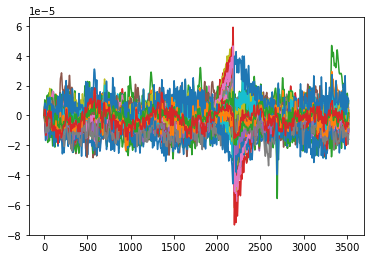

In [55]:
import numpy as np
import matplotlib.pyplot as plt

#data = np.random.randint(3, 7, (10, 1, 1, 80))
newdata = np.squeeze(trials[110].T) # Shape is now: (64,6819)
newdata.shape
plt.plot(newdata) # plotting by columns
plt.show()



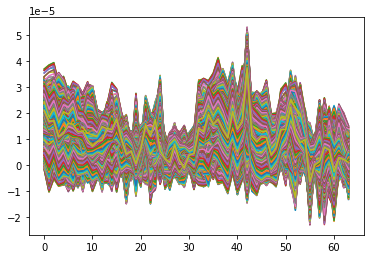

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#data = np.random.radata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXIAAAEDCAYAAAAoWo9tAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOzdd5hcZ3nw/+/p03dmZ2eLtOrdlm25YGPABlPsQGjxL4SQEJIAAfISSAIJgTfFKST0hBbTTC8uGL/G2OAuW5ZkyVbvWml7n17PzJw55zy/P2SaASNpZ3dWq/O5Ll+WRrPPuc/uzj3PPOV+JCEEHo/H4zl3ya0OwOPxeDwz4yVyj8fjOcd5idzj8XjOcV4i93g8nnOcl8g9Ho/nHOclco/H4znHtSyRS5L0NUmSkpIkHWpSe44kSfue+e+eZrTp8Xg85wKpVevIJUm6FigD3xJCbGxCe2UhRGjmkXk8Hs+5pWU9ciHEFiD7i49JkrRKkqT7JUnaLUnSE5IkrW9ReB6Px3POmG9j5F8G3iOEuBz4O+DmM/hanyRJuyRJ2iFJ0utnJzyPx+OZf9RWB/BTkiSFgBcA35ck6acPG8/8243Av/+aLxsXQtzwzJ+XCiEmJElaCTwqSdJBIUT/bMft8Xg8rTZvEjmnPh3khRCbnv0PQoi7gLue64uFEBPP/H9AkqTHgEsBL5F7PJ4Fb94MrQghisCgJElvAJBOueR0vlaSpJgkST/tvXcALwSOzFqwHo/HM4+0cvnhrcCTwDpJksYkSXob8MfA2yRJ2g8cBl53ms1tAHY983WbgY8KIbxE7vF4zgstW37o8Xg8nuaYN0MrHo/H4zk7LZns7OjoEMuXL2/FpT0ej+ectXv37rQQIvHsx5uSyCVJ+lvg7YAADgJ/LoSo/abnL1++nF27djXj0h6Px3PekCRp+Nc9PuOhFUmSFgPvBa54Zqu9AvzhTNv1eDwez+lp1hi5CvglSVKBADDRpHY9Ho/H81vMOJELIcaBTwIjwCRQEEI8+OznSZL0jme20O9KpVIzvazH4/F4ntGMoZUYp9Z7rwAWAUFJkt787OcJIb4shLhCCHFFIvErY/Uej8fjOUvNGFp5OTAohEgJIRqc2kr/gia06/F4PJ7T0IxEPgI8X5KkgHSq2tXLgKNNaNfj8Xg8p6EZY+Q7gTuBPZxaeihzqhytx+PxeOZAU9aRCyFuAm5qRlsej2d2jG3Zh94eonPj6laH4mmy+VTG1uPxzKLyvWM0/JaXyBcgr9aKx3OeUNDAbnUUntng9cg9nvOA67o8Yhwl7Gpc1OpgPE3nJXKP5zxgmzWKsokkfK0OxTMLvKEVj+c8UMuVqGNjS975AwuR1yP3eM4DlUwBoVjYaK0OxTMLvETu8ZwHitN5Nl70CPVyB3atjuozWh2Sp4m8oRWP5zxQyhbw+0po/gK1XLnV4XiazEvkHs95wCxUULU6ilrHzBZaHY6nybxE7vGcB6pmAVl2UVWLYjLf6nA8TeYlcs+caNRqJIcGWh3GectySuSIYqkqxYzXI19ovETumRP7H/oJd/zTh2jUf+NRrjMihCA9MjQrbS8EtlviU3yIO7Q/xMx7Y+QLjZfIPXOiusfkVT1vp5zKzUr7Iwf28f0P/V8y46Oz0v65zpEqZEiQkeLUzGKrw/E0mZfIPXNCroKu+ChNzE4iLxxO8ered5Hvm5yV9s91rmJSIYhJiFrDG1pZaLxE7pkbtqBElXJydpJIdbKKJEkUhryJvF+nrts4kkqFILZbanU4nibzErlnTowrRX5g7MDMzM7HerfWwKROo1CdlfbPdaYugRCURBAHb4x8ofESuWdO1CUbW3IpZ2cnkWetErcaWymVvCT165iGhLYrg9XnYitmq8PxNJm3Rd8zJ2z5VLGmWqkyK+1X7TpCA9PyktSvYxoScrmBK0HN57Y6HE+TeT1yz5yYNAaZ0B+mVpud5Ye23QCgYTVmpf1znamq9OSmiRVzmF4l2wWnKT1ySZKiwC3ARkAAbxVCPNmMtj3nPuG6LJ7YzKu2WRx59dSsXMPlVI/fwettPpvrupRlnfeMHyOfrGKu9vpvC02zfqKfAe4XQqwHLgGONqldzwJQM03k8iKGVrwRxx2fnYv4C2zc+DCONjs9/pmwczUaU7MzpHQ6rGKFEn5ywTYUtQ1TV1oWi2d2zDiRS5IUAa4FvgoghLCEEN4aMM/PlKfz2NJFjC++loY7O2PYSnSSWPskUjg1K+3PxImbH2Xgs1tadv1qpkDJ8WE1DlB3J6ioXiJfaJrRI18JpICvS5K0V5KkWyRJCj77SZIkvUOSpF2SJO1Kpebfi80zeyrJAsIxcBoDOLYzK9eQNOvUH4z5N9m5tzrEY8qxll2/MJ2jURZc0/lKLoxeSknyBskXmmYkchW4DPiCEOJSoAJ88NlPEkJ8WQhxhRDiikQi0YTLes4VlWSemijQKN+NXZ+l8Vm1DoAwTBx7/hwVL4QgK1XJyhUalXpLYiim84RyNcJ6nIgepSh8ON6k8ILSjFfVGDAmhNj5zN/v5FRi93gAKKXyuM+cFSkas7TiVX2mR65XMHPzZ2TPKlSQ2geJdJ6gMJ5sSQylbJGObJ7N/j6OBTKYNZVqztvduZDMOJELIaaAUUmS1j3z0MuAIzNt17NwFDMZ/KqfdW1Xgq0i3OauLBFCkFINbt1/HabWoDCebWr7M5HuG6VryT5WrNxDdqQ1dWBqlQLxskVRKVFRa2h5i0p6/rzZeWauWZ9z3wN8V5KkA8Am4L+a1K5nASiXx1gSWsqm9uvQHT+VYnN7g1a9Rn4wz5/eWWA6a1OenJ3CXGdjemAMn7+MplVJj0+3JIaalSVSl1lz8f3E12yjI1OkkJw/3yPPzDUlkQsh9j0z/n2xEOL1Qgjvt8TzM9XaCIasA6BLAUpTzf31qOXLtGc7OHDRXxJJ+qik5k91v/TEFGmjjRPyWoqF2VlD/9vYTomAULECAjtk0lE0KWa8HvlC4m3R98y6ul3B1WSOKmPosp/KZB7WN6/9SqoMNZ1G9UE0LUBpluq5nI1yY5I75DczTi//Zu9tSQw2ZXTJ4DP6+1ksTXJt7SRmYf4MP3lmztvi5Zl1luUw5SvxtP4UsmJQbvKZkWa2iFOzcaxDUJKpzqPCWbaaYpJFZOigIbfmg2pNbaBqMD0VY6zUid/RqNW8D80LiZfIPbNONCSStYfo3X8MW3coJTNNbb+SLqIKlQ0dS5BsFWuW6rmcjYY/R1J0YqNS9LVm+WHFcJD8gp6+ccSggyEZ1O35M/zkmTlvaMUz+ywN3Wqn3lakKuepFpu7Xd3MFXATeY5PHyAQeQENaX5sChKuIBdxkY5X0Mo2hW6pJXGYhowWkvmA+gmSjUUo+pVY3uESC4rXI/fMOsX1AUEs96XU5Cym2dyhj2qhjKi4dLjvoy6buFrr6pr8IjOZJxPUkfMWctGi4G9Nv8nUJEpBmYJ0HVp9NZLfwVS8DUELidcj98w6H0FqjkVMHWZcljAbzV1PXTdNRKONlLQN1TFAnx898qljg2SNMFLFRnIEaSWAcAWSPLc985Kq0tBUvtnzErqkDL9/chBL96pELiRej9wz6zQ5yNLAaq7uej2aoyPc5u5wbDgVQm6Al3begN7QEMb8OO5tenCcKZHgz7ifm9RvknbbqKbnfmy6KPmoyhbX921jyfAkhZCCqYs5j8Mze87bRJ4ZmuaWD/8vmcHWbNI4Xzh2A0UxKAQFtxpb8ds+ak5zE62DSdDXya5wiojUgTlPim9msyNMVHt4nbKN1ynbyNoR0sMTcx5HEQPFLNMb/hEblPvJGRqmdv689IUQFB4cojE9P4bcZsP589N8lj2PPYx/5Q/Z9uMftTqUBa2cyiPpGvWAib99CF0K4DSaWwHRlas0oiZtl9yBG1Ko2XWEaH2Ps8Yk6XKMJdIEPrlCvaaTGpvbbfqObVN2DRRHI9OvUJwuUhUWhWc2aJ0PGqUaX9r2PXbcu7nVocya8zaRpxsP093dT873AI3S/FmuttAUp/JUNROt6xiLfMOomoLdaG49bFs2ySyx+Fjs76h31XFKgmqp9asyLCOLv2xxc4fBO7o7CVXq5FMjcxpDvVCGso0ryVw8eC1r+jeglUsUz6NSttmJaWwjx2RqtNWhzJrzMpGb2TKZjhJ/w83Ue8rsuveJVoe0YE31HyVnTKMdXUN331tAt1Fso6nXMCmzV11Mx6PjnGiLIUoa5YnW71zMhl1WlUc4ovqZEAbttQJmfW6H8orTWeK5PI5iMdEWoKAvQbNVzFprlkK2QiE5xRXPuwc13pqdtXPhvEzkR7bu4FBkPSmpiyd819I3dT/Caf1H8YUoOXSAhm1iRhwOdDxKQ5Iw3F85d2RG6sKipzrMO2MfRjgVFNOg2OIKiK7tkA5prKoPcUEpxjVViXhjgoo0t+P3haksHfkiSqPI8u61dMd7QdEwcvNjZc9cKObHURQb1IW7Ceq8TORDEw+yy7wcfes0WysvgJ5DjGxv3QkuC1k2NYUkFAKWn5XFlyCEjUYA27Kadg27alOzBzl6OIrljKI4OsXp1k54FkaSpPUQHQzSeTjP2kcbhOwxssbcHnpRyOSIVVz0ao3sxseorDtOQ6mRyJRwG/PnAI7ZVC4keYyXkdWbMy/gCIEzD+ZgftF5l8hdxyUdGWVqMo5csWmMCoYSi3hq60OtDm1BqlZMDNugGqkwtupHSE4AWdYoppqXaC2rzpLhKhek/4COqQy1gEsp3dpaIhPHB5lwujCUCdoLL8Qn/R4+J0/OP7cvObOYJWIrBLIuX+p4LT9ccgGKVaC94p43h0tk7SJfkf4PO8Mbm9Le7zy6hWsfebwpbTXLeZfIR/b1MxBPsDrZzyP6+1k3cYLH3OsoxXdQHmpuDRAP2HUHw/Eh9w4grcwjGzZlJU9xvHmJ1qlJaNVehmIuwWIbtlLHbHLN8zM1PTzIVC1B2ZEp+y8gGVuOIzRS2txOMtbNDJrQ8IsYf1K5m6vzB9DyVcKWRrHJNW/mq5w49emvqmhNaW/4cJnkgfm1lPG8S+RH9v2YPfYmbqw9RkBL8hYe4HhqNfRk2HHng60Ob8GRbA1dMtgav5Cb+AhOrE4xUKU80bwDuCWhoVgSK3SBasqorkvdam0iL1aHqZX8NBpRStIJqtbjqHWdFOE5jaPeKKCrCkpA59vdv8+Onk1EijqGpJI7Tw6XKCk2cqpG2Z35m6jtCup5hUZ5fk0Wn3eJPM1eTqRW0unfy2eDa+kM7iE0muXp4BWMuPuxy95SxGbyiSCyJhiuxZEPFEm2qwjVpjTZvN6ghk5bKMyuC35MTI3jawRw5NYm8rqSpLucIVA2WBdewZXxa/CbKrlGEKfWvPmB38aUTSQ/JEMaY/3tnEgtwtAjqD4oZ1pzhuhcy0gK2p4Mk1OxGbe1dXwYudoAW8yLvQo/dV4l8nKywHBCZen0KEedKFf8pMAOq5PXFJ5gs/kS1MX7OXDbY60Oc0HRCdIQLslcmLapDMP+MLqlYuaas4LAsW18wsewv4/XfFtnPJZEV/w4amsTeSrssNocJlAKEg71IAc7MKoaSs0lOzp3CbSsOlSDKk7QwR2zKU77cMM6dlCmUk7PWRytlJN0JKBuazjWzCZ47z24g48rX+aL4r8Zzc+PHcRwniXyg1u2cNi3lleUttM97Cez5KOsPBDjWuNhyhMG051h+kb7cB2voFCzKJofGZVXlneyzXgvSTeIYRlUys1JtGahjGyohCtRnnrev6PVbZywjkVrhw3SIY0utx+1FuZoaIodwSPotRDhmkl6ZO42plR0QT6gIqkOHxNf5M+qPyYdUimFVKr182NopYDBemkEueFgzrDWTV8yzxXycdZI4+wZPtikCGeuaYlckiRFkqS9kiTd26w2m200/TB705ewxPc0enk15ertOPrLOVKTuWD8GFukl1Ds2s349sOtDnXh0DSELNNpj7MnKPCZFn7RRrVJFRDNdIlK2Ieo+Tkm34NW9ZONqNQarVsn7dQsJrQQfnmUgNyJb91mFl38EAGpnUgtR3pyYM5iqWgSJdGgjp9XyLt5sbMf1SfI+VRK7vyasJstdQv+eLSft5x8knxqZp9CilWVpVKSNqnCwbG+JkU4c83skf81cLSJ7TWVazuMt+fxT1cYkNpR1BjXJG6goY6y7Og6/j/7PvZmLsFYNM7RrftbHe6CIUINZMNmIDDJe7sShKsZNF3FspqzYac8laPqV5heFuPqlfeTjsYp+epYLTztLXVilMlGJ1SLGIEIpe1ryN97FaoeIuSMUyyPz1ksBUXHkmxMOcj2kEPSyNLQZUy3TFGau7H6VkokC/SGe4mXDAqZmXUgolUTRRK0UWEyM39W/TQlkUuS1Av8LnBLM9qbDQNPH6WvrYdXZLcTyllEw3FGIg4b2y8hH7qQijmJf6zAwciFpNzBeTWRca4SQlAIFGmEoXOyxAe+7xCyRhFRE8tpzqRyOZmlolVwjD7yuzQasSTCyiNXW1cUavx4P5lalLLbA1GbcMlP1DEQYYdQZZKUNHfvMgXZQBZ1QPDp9igPxByKchCt7lBSz48hxJ5ClVy8jUiwm1J2ZvMTi2unkrcmOViV+bM7tlk98k8DHwDm7W/GsYP3sqt0ORuMHUST7dgRQWbpAwxHS3ToJbqHns/rMvfyaP1lWN0HyB6Z2+JGC1GlmCJFjlJIoWdMZ0V2A+3mGIUOgd1ozvKtSjaPZJXoHnWIyn9NJFvAX6yiNgJY9dasQEqlThAu1vCbQdJtOZbE19GbuJiMVgL8pPXmVn/8dT7+hb/kY/9zIyWho1olFMnCaoSoCJ2KrCO5MgWlucXL5iMhBO2my1jnVgqRMqXK2X8StF3BcmuST7ZH+deOdtTG/OnszTiRS5L0aiAphNj9W573DkmSdkmStCuVat4a4tM1pR+jMB1iAhW9uoT60iEOr15CefVmuhMXkw+3sSJ7iOmJGKUulwMP7ZzzGBeawQM7UKoNUgE/Nlez94I3ESpZTEV1NNfflGvUimV0s45a7SIlbSNQjBAoQF2TKU+2pt5KuTHG4so0vrKfUqZKXzjNztAxRMVCFgZJtTkbU55L8OlddDw5juUqGOUGklvkvbEwr9ZWgOuAWyIvzX4crVYvmgQUWLJxD8bS4+Tss58X2DYxzCpnnM0BP7sNA03M/hvy6WpGj/yFwGslSRoCbgNeKknSd579JCHEl4UQVwghrkgkEk247OkrTmY5kQjzkvROqlIbur+DbYkYT+x5Pg+2v5DDiZ2sDcUJp1/I84Yf52n/ZUyZ83a4/5wxdOAIuqWQU1Rc1yVsPYJajjCsRlBFcxJ5vVZCLwuiUidXLX89YaudkOWn5jcptKhw1nTQYlHjJEErTmfBT3jtQ6y8+D4iVgijJpiSQrMeg1G9AUe7EV/FJFAERJ7Pd7ydH/Veh+ZU0cpVqub8SUSzJT+VRArC+/g8O+PrKFI/67bu2fcUvfI4o6pKQZHR3fnz/ZtxIhdCfEgI0SuEWA78IfCoEOLNM46sifZtfoh97kVcJm8jMZXBFw5gT5f4i+NfIbIvRXX9GIX2IE5I4oaxJ3ky93zq3YcpT8yfyYxzUXpsEl/DwHVdop2LcS7pRal2U2j4qNGcgk11p4RuSdChsu3yu9CDUSzdAVEjN96addLJoEpQDBMwOghocU50LGJb+Go0LYBuypj27B6VW63XaAvodPkdYvkcruojWCswMtVNX2kJqpMnWFEIZ4uzGsd8kEuNUAzrODsqHK90UxBn/3vXl8wh6ymEJFGQZQx3/kwWnxfryCdKW+ifXkZZpAmllyISFa48VKe74zVc21/gu4U/JLPyAVbH16Oal9PeP8BYT4B9Xp3yGbHyNXyOH6lhcji+m+qxuxHBOAGzhhPUcN2ZT6nUnByuKnFwmUy+v8jocom6bmPUNUqp1rwRjyoRApU09U4LEa9zL6/mrvqNyO11fKYfX312TzDafXg7TiJKqcOgo1CiHq7RZim4fXVyIwG0Rh6/FqCj2Ji1GOaLXHaSlKHz7vK/sXZqNznp7OcFJLPOmHHq5+ZKEqqYP8s3m5rIhRCPCSFe3cw2Z8qxbE4mGjxv+hAp4zKURg/Diyvoy0I8/vIBtNUxfrfvdnYvXsvRxHE6wzp/NPAAT8pXMZ7d1+rwz2laQ0d2JGQnT8/Jdqi/gWJ7laiZIqAr1MozP7vTtKZwJBf/9H6u3NyDaQ1i2zI+EcQszP3Ou3rRZKIRw7Q76Q/UqXVnmTzchr2nRilhERAx/LUi5iz2ho/sfJhdLxxl64sqhKsSas1B6FH+xH6AF5t7iTsNij6NcH3h9+OSlSxVO0ts8AZWnyhTmkEiT1SLnNR/Pq8gs/BWrcxbJ7bv45BvNVc1thCsDmGE4wzWBY+ujPPk9su5f1U7vcM6+05cgr3hEEqil0hpKQfH11Pq6cMqzZ8f1rlGEwFUNILlLGEpzsXhINTqhO1RpIhFbmzmW9WLVgNL14lNxumPK4STMpYP3KBO1Zr7SfWxwycRFQXV7iA+nuVkp8Z7cnfwydrnGYtpyHKQQGOa5MDQrMVQOTHJ/RMv4qH+K/HbGv6yStHXzV+pd/MW+34UNUQjpOObQVI7V2QaVdoyJotXJYhrq2lUzv5T4OJ6mpPaLybyFm5WeJYFn8iP9d3D3tRGNI4Tn2xghHQ2DTrI43n+sPFhOgaPE+pZxR+lPs+3eRPjyx4kGunhNf23cbyzgwP3bW31LZyzFNWH0GVClQq+aBfH2x3CFT9Rc5xsQqE81IRjzxo6kuLQZke5oet6wmU/mmiQjxhU63OfyCcHDpMo5wmWg3RY3Rx0e0lENjPVcZABqQ3LKBApTpEcPzFrMQQqOhck+3lZeieKrmIYCbJ6G8O+KkJLUQgk0DUH2S/h2vN2xXBTpFybiKVz+9JJjl3UIJo/uyWptitY0ZikT9e5YY/Gy/a6yCzQoZX5aCg8xZqpEUbV6/HlV+F0F5le5+Oyk7tJHHsnV22d4ljwDmTDz/MOHeKJ8HroUNg4XuSJ6gsYGt3W6ls4Z8kBkP0OoYpLdfFRlNXfJiC1EayYjIUCFJtQylaTDTRLEPB18nhokIjcic9UMbUCljX3QyvpYj+d9RH8WjtqJIDIKfSZV5MuvhSqLrg6hqUzVRibtRjKXW28r3E7/yx9m3yHRiEWwpFcbkq0c2fcYUqLYesa5ZCOmV24x58BpIVM3Sfz0ofSBE8eJVo5uwnKrWMj9DBGSlV49U6HV+1yQTKbMs/TDAs6kedGUhyK9HCd+SiuP4cqOjnabnHY0tHyV1LRdpOMX8O1D13G9Mg41djt/PHwNzjWO0DYWY0YajDdPYzbmD/LjM4lTtjGDQm0ikJqOIX/rmuoRiqo5SgjUoRyZuaJ1gkGCFp+6hEb/8rNuAEfYasNpWRit2AMeFKvEHUHOLnSR2NRntXZPRjWHkTpSQKlCXQlhOOPMDFLdU6EEJzs6iAdnGRrpMZ4OEwpDIpbJ+/KpCSZhpDJK0EKfoX81Nx/aplLRVvgug2Wdqyjs7CGsH12q1Z+ePBpJN80hiVI5C0iJjhSjelc6w/5hgWeyPc9/kN25y8iqOwnnurDCLfTmba59ukhFrUZxDaEWBbMcGTl1byo/2X83u0aX5D95BpVAu0xXj9xG3vjyzj6sLc56GxMhSVKEQXUCPHKGmKLe8nLJSSzk3pdI5+a+Rh5Oahjh4Ooi0awltbRutJIkQCBskC1Ak24izMz7lOJFFPoyRP09agEXIsN+y/hksMvpqOYQ406yHaNcWl2DiaYOjFETYJboz6+GgtjKy6OUkVxCnzwdpeXPC6jN2qUFI2aXSGfnLu6L60QKtQx6goHl4+ixmJo+tmtFhqenCavV1kxfSpphk1wqXN0dH5UQFzQiXzA3kvPZI7xxrVEkiG0kMyRkJ+wvITR0E46HiwylXqQ0pJvMrhyMdX2P+bfvg2B0hGqyyeIT3bxdPIyjh9/oNW3ck7KaDaZoI6QdbQlOmOXPUVbwYcuJQhXTKqNmfdK61qNYqDBkUQn/yJ9jPGERjKhE6gb2PLcHqsGMEwUuxKmOx/jqNuBYmeILL6CxIpL0bAodjYwKi5TzM6uypHNB4lV02RNFX9aRrdNGhRRnCzLktA7DQErj0QDya5TyE/NShzzRTxXx4+Me/kA9qp+qn79rJZ+hssFTuga659535MBbJvj86SU7YJN5E7d5mA8yLWVhzFjUXzF1VS682zaU6Oray3GRJyDq65E9v8dVz/ayZT6DY5c+QD9l9xIdDjPziUQ9a3l2tEH6e9Ke0W0zlC9WoRMmpRm4LeDbF0T4CP62zGCYcqdMu21SeTAzFcECbuMVC9yknaMxyYZ8Ecoy1kkuUExOveTUUXLQCiLCSmdtKWnWTaynFwiQF97jUjKYSTqx1/WZm24bnTgOFF7mDc/BO+9x0UWOfRqFn89y+CKP8L1vwzDSaJaVbSiSaa6sMfIY8JE8ml8MvV+Hmu/gKIqY1XOfMKzq57jhK6xYeznm7nkusPYdHPKMc/Ugk3khx/fym7zQiLuQUL1vchqJ+lsnWWdGziY+AGOHSFm5lHqd7HnyjDR8MWEG8s4uSYF9mUUJxTotVgxPcwTxnqSfV4RrTMxemIfwXoDExlDNQimUnx+5G+Z6ApiSWUizghmx8w3pKiVKoGii1WC/3U/zaQVRM+XKasWtlLGOcsx0bPRMOu0mUVKXb24PQ0SlQKLYpeR7nwaZ9HTJMwVjEt+fPUQ2iydKTqiDKNJI6yYgkRBRnEy+EtlApUCqcSlVCIX4bOmCdsFfLZCzpo/Ky9mg2soFEIB3vfI7bgDdax6mfL0mW8UW1xPclLTWDbtYv00l9cFxcrc/X49lwWbyI8N309w0iLXuIbYxBRaKMTa6lJOLtuBGC2B6sPSBinqa1g6sJHOg0Mcqu7hWOcjTK0PsyK7jUPrisRyq3EHHQ5su6/Vt3ROGTh4GF9NBtvGDJSRrN3cW3DI+yr4yhqR6gTJ9pltVXddF3/ZIlwNs8o8xpOxSbrLk8QKGkK4KFWoNGFC9XRNHR+kvTaNKA1zsldj7XSMgWiatdmDEdsAACAASURBVOu2sXzlbjRfO0qliKZo6PXmlw+olktMBDRkK8cHf/9fefNbPkagmqHNDBKo2FTrW8jJ44TNHGHJRUcmIxb27s5cwI/VqLFMtHHt8XECNYvcGU7wWo5LhxjDbsi0Fxsku5/5h5oM7vxYi79gE/mBqMU15YdJd8aJTK5DVxwmV55kYp1F2/gKukIRru/9c66KrmEqMEC+6938wdMv5i3f0gnbW2kfb3CgvIRgRw+XVp9gr/zzSaFSLUOlPj9mq+er1OAYoWoI1apQwmbNUYc37LgUuTKK3/Hhr1QZ9s3sRHmzaCIcFR8R3EaWsmRiVEYIOW1ojkqw7ic/PHerMsaPHyPQGKatqjFRtukMrCG0YisPa9dzu/YmpA6LSHoEWY8QLSSx678+iVYqFU6cOMJjj3+ZH9/3fnK50/v4PvT4IUqBdpycy5817uKz5U9gVMpI/i4MM8jixcvp6opjlC0sPYQZipB2Fu6QoRAC05AIZk1Ez3LawyuQZJV8+szmBbaNjSDr06ycOvW9mlgaAUCqyWhidiatz9SCTOTJE2PsEmtoqx4hWNuLxgbKqwuMXVxhYq8P4eugPb6WbxqPk4xovLTn1WjWIxxdsoaRVX9Pxx6N6ZXLuHT6h4xdkKNn0GWv/PMTuL/4t6/gf99/fQvvcP6z0jUMx4/ayBOqGkjOVRza8AfEUwUaRgml1MaE24Zrn/lYcb1a59Z/+CQjTx/FlhTUoEYsm+Z3n15KqFpCDamEnAj4fGTnsHBWMjtIMJ+lvRzj5Sej9LcfR+4pcBtv5mFuwOlIEZQV1KggVFFIDf98uM6yLO7+zn/znW++kfsfeAVPD72Nh5zdfMffxYPbPnta15/eO0CQKrVqD4uVA6j+k+SUpRQjUeRqBC77Ae6F21CrETJ6FFUDqzTzMgmz4ci927nng7dQTp39uaK1cpUGFdqsMPX1d2J2T2MrNpXCma2WunvfLkyjxKpn3k+HF22iEF6KVgV1fuTxhZnI927/PvKUQs1+EYnxcdRFBgObsnx96M0876DN+vbVPBU8RO/KXRyL7GN7YJRrF72JTjFETtpPov57+EpH0IpVDgqdqH0R8eQw6cFRxlP9bG97FzsD76Boer3y30Suyyg+hXAlg6YbWK5FvfB1QvkgkhuAagJRhcnDg7+1rRObnyA//vNe6Z5v3Ees1Max2x7CkA3smEPd38ZnrpxCsXWKXTK6L0ApJJMZmb2NN882KYrU/evRIgHUYIyeVU9yq/Rm3KkG7nCDqQ6HUK5GIQGNQAdjY6dKJbuuyw+/exPjPY/y0JKL+M/Iv/A+9Qt8tfFOHsu+mB9qHc+58WTq6Al2ffUuCsUSQWeUXOL5fD/e4L8SEaqhZUyGDRSnkzs7XsUTPeuQzQ5Kko6uurQV5s828190cN+DVC/7Docf2X7WbeSmxpDTGYywzLZFl5JbWkCzBLnamQ235ScHGdBl1k1ATfcRKdzA0fV/RKAqoTA/hqYWZCLfr45xVfERxnoThKcvpLSmyDeG3sR7R75I3LeMoYhF77rH6V1yhMsuuw9pyXbu8e1mQ88NrA8mGIspbNy9DscX4OLjD1HeINGdGWLL9ru560sf4W/1b/Eu361860c3t/pW5y1Zk5EDECwXyccCBLQgG6NXo1bbUMIBDLuLaKVC/+49z9lObmQC8/48h76y+WePDe8+jBmVsWwLJxwiFVMJlKb5+BcFUGUoEiCf0GmICtmpk7N8pz83oUO4LIjYi5jofopUe5hd9pVoh/KoJ4uMhUP05JYw2OajodbpT40hhODe73yKI0um+A/x7zyafAn1PVXiD53E9+gE+q4028c3cfjk5t943f3ffIKxgSIVu4ImRnAiAYoVFV9KRlElGgr4Im08lbqMp2sXIVsdqI0alqYRNlu/M3GwOMn6zVv4St+pe6xkCoytGedLHW9jKn3krNtNTo/QVlWpJCTUHy9mn7kaX0Oh6JzZBG/MzHFS11g1CblIGK3RhqXHiJjAHB7b91wWXCJ3HZed6mLihT4C1f3I7gqejrfxH2OfJDLUQzyxmuKi7Yx1JHgrt/Klxj9irJ5k9SX38UDkEYyOVSxWikx1vYLoeA5fegNHjGm6RxfzaK3MRH4ltWA/UvA4R/fNjxnr+ciKyIiQSyinUgzU6A0u48LYC/DJCSY6fdiREPHaGJnccx/gcfiOrdwefpi+xqk5Ctu2kXtdzGu+RT2Qp+q3mPTpRDMxnnjRJ4kUoCLqpMIOvpJLvTJ3QyvTsoGiBChEYOnK3XzL/XP8fVmWiik2ugP0iyUYvnZyyKhlk/5ajYfv+BrHunfz5co7CDw2ibKvgMjLXB8r8tml+/h37dvEh5J868Svr8RplUzGYifIrLqHhgpaLU3AzfC6RyXec4+LLqXx2yaNhIt7tEZ6MIQvmMBn5ckaIXzzYK7u3pMHMbdW+de9Bl87sYXtX72bzf5N9B3u5YR89jW/x7NJJL+fKVfhxYbMSw/ZKEKiKJ3Z67arniHVUImVXKa7lwMSthYibCog5kdRvdmtcN8C0ycHsNIGwnkR3WPbMTquwCwpjGVUrm5bz77IAZasOsaH3E/gH6uyM7SGbcaneX5kO6+59Aec6CtwofM7pMYeoiv7OkZW/ZgLd69AXnoBgWQ/IhHkox1RdAEbRREhBNIs7dI7U67r8JNP38Lz3/ha4ot7WhpLOqIR1S0C411k6llqvlU8oh0kZLRRVKcJRmpE3DGmAs99UtBYapAX7jvK5PJdwN/z4E1fof95I3yu8XH+r/Jt5FqBit2GUluJqW/H58Qx8hM0FJVAVUPMYYU/12mwrLqc9IrtDAc3MlxdgX98km/5PooubF5V/BRSx160fJJIVuWkU+BI2xY+X3sfoV3T/IP4Pterh+lRRlEqNlQABWJOjg8m381H7Bqq+subnJ6+/SHYsJeJUBfVkkXbsEXAGGFpStBeBt1J4rhB0vEYX0t/jGOVpdDZjeGkKfkS1AOtO6T6p7b0F5ErfpQDWf7Jl+AtvaP0D1/C6yYfZXhx21m3O1op0pDrRPMWA9dtIdEXx+2XyZ/hBGXYHWPxtAQICrF1P3s80IggSfNj+eaC65EfObCVTbkn6F/ZQTB5Ae4Sk6XTu1llXs541GXJusf5uvp2aicE1rESyq4cwYfG2L1/LY2hC6iuynOofSuXxV/ARLjOooFeVH0pR2IjLBmq0yEG0AoKblFhqXucQ0M7Wn3LPzPw5BEunFrDga8+3OpQMO0yuaCCobQTKFTJ+RoMKknUgB9ffgy5YhGuTzMR/s19icmDfWTsxzi8YpRkm06jbpFNHOe79RtJbB/CDsj4iy7+wiiO0PA5Q0h1HwE0wpkqQi5iq3PTV3EdB8XKUQ7V6Fl+mO+5byZ0JMnr1K0sZZoeKYOes7E7MrSbDm1SJ1XZ5jP2XxPYlebL/A+v8N/Pkd4Y31/7O3xp05/xsavfw4eiV/F8/SkuGTrGHQce/JXrDlUe5kv6O7i58G6qWo66fxV+ZwxxybspvOyDhMwUuDkm/EHivj5WSUfIdyoE6tNoVp2c0vpVK7l0la9rH2MTA/h2J/lW9HquDz7J5/TPYoizX28/VamilSwUQ/C5E+/g/uh6FEehVj/9RG45LrI6xapJEIClr6ehnJqgN+y2edMjX3CJfH9liq7MED7zELJYzLFlgpUnuulIrKS69HEOxdazJ7+JDSPHeUT9AAeUt3JX+F18uHEX31j2Yj5e+TvMoMZIpM4qn04+fC1V+UlWHikhx3oR2iB/9wOHv/mhA8ZJvvK9z7X6ln9mesdRfuLbTyU3O5tNzoRuSaR1A+Gz8JUknOgUK1c9he1TaE/aBOsKRqXCqPqbe1xH7t5JydWIl/+G7tHVPPDRr/LY2gjrj/axy/hLqgGDcDWAYRWJBjp59ZJ3EVQ6kRtZ2ktBGrZEvn1uJqMyQ1NEChl8yw7ziHY9+XIbZBp8wLidD3V08uc9nVxaPMZEQuAzayhRnUrexXg6w9fFx8m0neQ1Sxbzfn+a/7QP8PnCo9w6/SPui03x3kQP/yK+zpf3/fJ4bHZ0ksdXR1F2Vbn+6Yfw1bKM9lyFr1TiZJfLrvYUgaKLrepUJJl/7IpwT7zMRDhAuJSlwy7jVue+QuSzbSj0cZ2yn68rNxOwagT2THNn7+u5/qLXIsTPD+B48s7/5o53v/6025VKVdpLGsmon5tLb2d58jg+RUEvnv7QymPDQ9T0AqsmBbnIEhQnRmXRqWE+VYqCMHHOYuVVsy24RN5vC1Sez6LREXwRH9mxNlZHN3KofT/hFSN83f4LIvun+KT6vzwYK/P2zhh7Uq/nWxuvZGJniI49IxwKdZFespmujk1o4gjh0o10ZGMcbCuTsmr0ZmDFNAy5Dqa6hO1PfuHXxuJac/sDTqdSTMsF8kbrf7FsFdKSj4pWIVQNYsQP0CsN0ohl8ZdCKKofuRJhym4jN/yr63qFECTr40QKPlT5IK4UYUId5ImBq/iA/AXe2RPH0hv43SiRsokvEOR+bR9+I4qvUEcP+AnQRlGdm+V1I3v6CNQCmG1lfihuJHpokjdqmynJZX4S9rHXMLjAOsJIMMKSdCeFToU148f5lvgIe+NjfM2N8d9fcfnuJx2+8wmb733M5nv/ZfFf35AZRObHcZPrR7Yy9AtL5+7a8mWOHl3LC0M7WRc6jOYOk9Xj+AuLKLQN4LSfoL1+OTmtF7VR5dJdMh2DgpRs4KsAGuh2a4cF647NRdV+bGSi8iRf1b+FU4bQ/imOtr2Hmv7zoYvjP8iRrrya4SNPnlbbgVoFvxTFlMtkd15J++gxHNUlUj/9A5gf3ruNcd1l9aQglbgQgGD08KnY9TZ0q8pIavQM7nh2LLhELmoZjq9qJ5DcgBxXeOlJl/5YjaXrt/Al6a+gz+Qd9j08Gi9wbDTE72+/gbuvvYDibh+3uv/Bk8ZfMVkLcaK3kx2BfVzR8VIy8j7GQypRVaCM60z0vIDJrquQxnVWOEl2feFzFJ5VX7qczHPLJz7M3rt+82qDZqvKFS67/B6cjmFqldZ95GtYNSgWcW2BqGmEaKe8q4fj97+duu8kQbcLEfMhVbowKg6HN/9qdcnBLfvIyA8SqC9j9eLr6G1fRS5f4QNT3+SLHYK69XIabgVVDxEqBKiF67BsC3ZIwZE1phIhDCOAWjnzRO46Dl/787/mjn/61GnX2EkPH6e91MaOtotppEGUHf5Gv5PPRrv5i62r+cDmy4n4TtJvL8XQ4wy3BdhQy3NPZ4YDE2H+5bYomc4/ZfCit1Ne8WLU9m5kv59Vk3U+/B2D2/xhLvffw0fuObXDuG5V+UGxhz81P0xbeifSyb0YlWkiZomI9EKWr9nBhvVPIBtrUR0fipXmlbsMLjpkINl11EqUghbGr/p+qUdZGM9y20duYfLg0Bl/387GzskhVkkneVt3L4/I13CVvIX3aj+hnlGQjlXIxRafimt0ipyUolG7nx0/+MFptW0pAiUi40slafgNUOMIW8KQT7+jU5vsJ1nXiVYgF1tJQ6nQUdFB2NSNKGrN4tjg3rO59aZaUIncadjEp4ZRzWMocoJqsorR2Yu26hG2h6+mL7OKdeMn+J3AjxgaCnPNwGu453XL6NiX437x91jBYe5q07k4cxL7YDvhlU8zHKxyec/vcEnXRqLiOBsHZA6vvZGj627k4n6JNuUoIfd6vn3Tjb/0ot/7yL1UxV3sG//fObt/0T5JMFhA6TzO0JbWVWUb7ttHtKShNCyCrh9FCyNMH6qcoTRuEdDjjHX60OodtFdKpJK/uiLj+EN7sTIhIm097Fl0H6lEBsmZZpn9u2wov5XnNR6nEopAm4NuxrGWDnFk5WJE1xSqsCmTx2pXCFfOvMrgxOFBNrGGC7Kd3H3TpxGncXhArpEkIvyMaYsx+nL8if4webnGPiARv47G0ksx5TRjhUVIHTUqTon+tnWEn/Lxxp2X8/SmdzARGmPYV2Jvz2t4fNNN9L31qxy+7gY6snX++TaJj0YjXDP0HaoNh3+84xu8KvffuOnX0XNiPTJvwO/46K6OQluYcCSNptdxOvMEGyWMapaBte+hEXoDvnoOzHYKskFdD1DKnKo9IoTgJ3d8lsimz/Dg5k89Z2GvzNEJ9t/+BMKd2Rj7I8cHyAWn2OOH/wlOU3MX8VfyT7jOOoY6ZnKAK07F9dlvcEXsYl7V+zby/ad33mlF06glIGyq9CaeR292FYqqYBm/fQJ8umbxB/ftQU2V0dMKAgkzsJxMtEpHdgVCqlA32tBqDSYHDs/oe9AMM07kkiQtkSRpsyRJRyVJOixJ0l83I7CzMbrvMIvK7SweGQUkVrSvZ7BrK/aSKrc2/pjQoSn+R72ZTwZjvPjY1Wx+VTuvOLaVG8M389beNt7THefj8RhrxXYSPovDnSvpj+5G9uv8YNlhGvIovYXV3LU2x/fXl1mRXkpOT/L4RYLF/a/kx7f8zc9i2XPiHiKH/ozaPkHy5BzVfFZGSd/8VtTjKqO7nntZ32zq27OXiBNAt8qIsA4BhURwGcsXb8RfiEMwQEVKY2hREtYw6fAv796zGw1yxih6LYDTbVK4sEFl7XF85QB74nvI13dz8cE3s2TkMLmoQHfibPX3sOLHPRzuCOA3NQIViYm4gaQZNOpnVu1u+OGd7EhMsKN8jPWVNfzkP77wW5P5dMBBj9YYmFpCoGLybvVuPhPr4g27l8FF9xG97Dak6cvoymWxElkiySw4gmWlP+HgspUsVYfYtPgFXBzqRq59j7b2veS2f4EOaQ2HNl1DV0bnnXfDg+2jfOmr/05i/LN0bruIvpUyaD2Ul7rUuy+lTfTjdo1xq/QnfIp/wOkYIGZmcCWZrDZNWZPQrWn88iJkp4HPdchOnNphevCBJ8mv2c2/Gf9GZt0Uj37j1l97r5VkkTt/9GmeKn6Op29/5Iy+t8+WGzzGHv+pCenhjho/FG2oFPiPwE/QFJvCmI/79+1Az9WIRJYzbBQIOh2n1XZDaTAZ0YnVIoxe9RAsszFjGuXn6JBXbIcP7DzBVZ9+jOrWbbxSv48VU4JiuBfkIKWuHHYph5Cr1PUoat0lO976UsDN6JHbwPuFEBuA5wPvliTpgia0e1pSu08y8KMnKSZTHDi0k5EViwlNb6QntogD7SdYtH4PnxL/gH40x18497EnluXyHREOv6iXdeVvcsfio3zRiXPx3gAffHARr526kInAFEcCCX4ydQO9q/bxkHaAEdZQTQv6lj2Pj5Y+zr8W/4ex7ktJZwzirmAkHiHzyM9f7Oqgn2gwjV5dwY5Hvz7r34fCeJpSXzsTxhjlwTXkyq3bdZodmERT/BjVHOmYBrEC1aXTJC/+OgG1E7fNJJxKke9oEHaHGY39cq/5+L07SOtbiForGF0zzM1Tf8m9gRcSs3u45KJ7uXBiLbuWSSxuvJwhOY/fF+OqkzkMf4ruoTJ6xU89bFBQqtR0id3/dDvFqdPfln2y/wDT109jvXKYx4r3stRczsP/+ZXnTOaThkojXqac8fEO/V6ySp2disTiyBVs7b6U77W9kai6jktKxxhLSARq0F50keJVVvcuYuqyYTa/8GEOXrSHizuvp3x8hMUdl3Ei7hBPXMTxlavoTcd56YMqOxu3serRTszOy1hycIx2JYzjTzPQvpT2uo7bPsgWXsJersCN51hSDqP5dWJMoegFYvlplJiG1ijgUxwmMlPUy1X2jn+Gb+h/yvjJDr7i/AWjodtJ9f1yJ8S1He7++hdou/gJzFUNjpRvIXvy9BNZtVThvnd+gnve93meum0X8cxJdvgNnj/Rgb+ucnPCYlxcRK/6NP9Huw85WeOWw0dYF7+SJ0s7KCSP4jOilIq//bxXxylRrGtoUR//ab+Xx1fGmQ6rSM6vHyM/nCtzyRcf497/t5+bqrfwQ+OfKRomqyZhqvMSADra+kiVk9j2GJbRhlJzKdZbv6lqxolcCDEphNjzzJ9LwFFg8UzbPR19P9zC9h88wVM7D9H/ye3sK01TdacIhbrIdOj0bHiEr6h/SWHMx+rpIf7Adzc/Nttor16H2/h/LP2Jy0c/Cx/7hsObHq1w5ytezTfD72Jc30RPYZJrBh9hR+QKVqx+ik21A3QNq+y9OEj/5GsZm3oFW69YzJIhiV53mMcurLN/+WIatkUlXyAuVmD3rKSzfSl7zSO4TnN/2EIIXnjndv51z6lDfE9s2wd5H8t8URzJweDMxoZdy8Epnf3mi19klU2UoKBn0qSilik7WZ5cHuYm6QO4i2zsxDhtaQW3XiLQSNKvJ8iN/PyFefKpQ7iDOkainYf1TXxw83dZvXMcNRJg387fR4mH2fC8O3AXpVAI/P/cvXeYXFeZ7vvblXOu6uqcW63ullpq5SxZluUcscE2NrYHDMwMycQDAxg8GIPBxmOwcY5yDpItOUhWllqpW51zjlXdFbpyrtrnD+7AMDBzYPA9z+W+f+569gr7W/U+e3/r/d6FoFOxsCCSGp4hmRDRiQ4yzCMLe5EnRHp8w/T/8iiuM3/8CSyms0wd7OP1e57i+GN/cLdMmCPMRos5Z6hCozGyR3oSQyyPYz95Fs/EGAG3i2hggci8n8ED7eSyOaK5JHMWCZaQn3+QvM8D1jx2tEF0kYt9oUtp9qwhXRSljB4m1CaKvQY0Si2uLbO8uGKec2NOCl/NMtedZcw7gs3gZNaUJZl3Hr8xS0JXz4zTQrGviK88o2bBdgMS9Si2TCUpSQqpMMNYxoEiu4GQVUZYMCIKEiYM+ahFOxKdheq8DVSYazFEU2TsORQZD3Gtkumgnw9ffJSzZWXM9FlYPNZHrFNkv2MT+z/45R+t3YOPv45Qu4+fKf6Fn/IDpivk7H33wb/YX735l68yWZwgJ5Nx/O1fYcsOsSxWCKs3cXO4Ab8xzVflKUJiGf8kvkOe4Kc9UswBZS91kjKWWDeRVQgcePO3/8e+VKEF9MkUY3kaHpj4Nup5H7H0Alkh+2ftjb//xptsmz3BMc3XuE34kH2yeh7XllHpFgmYakkpFigOZQjYXWDtJqE0IU8IJPnLDjARRZFc8v+dIsKPNUcuCEIZsBz4k90rQRDuFAShRRCEFo/nb3ek63hhHwNnxhixnWPOdpY96vOEkwuUDngw5ZWTqviQE6Z1dASXoO338WvZI9xrNnPD0QLGGs6y/Mx6Zst/yYnND3Ng269486bv0+OtoGmqkxbdp3BmT7M0Ms87C1eyl/UoJb3UuoqwpTvI2aoRLDXohQEapiwIqiGqkyfJaMOcOfoKr++6F5lDS275s0SL3Zh6JPQf//gOcRZFkWfv38Vt77yJ7ZdPIIoiM6NtaBU2VtsvpVRfRDytJv0XbvSJOZE3fvEIz/36px/L+CIqKegy2OMGJJEQgk9K8dlpvnNwFwO2LP5MEFPCjjGrQxWNMh4voGvfCQCS0RhR2yDStJlA9QwVrWOsVC5nk1vJfFGQlJAiWTzAcc0GkoXTiOlpRGuIgqSBK0u+gD4kRaE0olvwY/ZkkcczFKhtHM510PzOafqfP0g2nKLz+SM8d8+jvNn5K7I1uxgUXmBh/Hdv7b4CNfvF7bRIVjO91YtzupuPjMfpzx/F/UQnsw91MnbfGUYfOE3iwCTH730RmyfMjE7LTYn9zMlzNMskbBlfRHexhlx3HFlXgOF8OVL5JCOpYlRyC4E8DfL3DWx5K8q6eRGD3EGx30GMOUzmIqJFJ1AUnyBWfIIinY6UchUBg5TWhuuQpvYQ92tRKbXY7JUUpQwog2mkMhhUVSMdC6Ps9tAtaUS0+fHI7HTmH2cybwRFWI/PokQXncOrUjPqnmei4CR75q7g5vl97Fd+i29GdnFsaj2zNS6aX3kXgL79rcyZn+Ep3R14+zRojrp5IvEFEos7OfDsi3/R2vAyTbR6DPey/RTaVpCUzRAvXcv7w9s5XLuasoCeGVucH+scyMhyv/pxMtNphoriDOqzPGjoRyYRmGv93QvMO4cf4NX9P/mzfdnmlMTlIkFplJGhDOaFUxg9AUjFifv+NM9eGurjCcUDpHNyflh4NXcXxpHHo2iScqLaYqKKIBm3lEXb26ne0ElGIkOaUCOTKf+iuU+e7eWlHz1Byysff53Hx0bkgiDogDeBr4r/Ufz5/0AUxcdFUVwpiuJKu93+P+5HFEWOPvgC3t4QA5ZzLKpupqLqNCMWOdaMFGdiESPO04SLRV5NfApN2xy/lD3BsGEeY5+cqUoT5f07GHE4iEeewJd4GbesmdZaH18OvMo7yu9jn/DjsVsYLajDOT7DzHw5YsxLRLecMpeSOdURpjQnqJzNgGwJc8kUgVwtTeoXeKxzjki7B7dzmMzeC5mf8WFLlXNkYs/f8HT/gPDINM999l7sQxNUWBtpstfz4v96GJ/vNCaNjg/l7ai0ZgKZHg4/+AZzg1Ps++ZjhFz/darl3Kv7STW8Ra6xmWzqb39jCKnSRA055DI1+gURZcqEpTDH3CUq1ONzyHuNqJV5ZKwqiOqRLIDH0w1A52vHmNKOYKWaj2wFrHRlOW3xkbWayY3NUDvvZLJAwvPCZzlnK6N8Ss2EOYVOZeEjRRcWwQKWLJoFkEk1KEUpM6VuygMqfCXvs2/iGE//4mFOxp7AsvIZahuPMGHNQ1Lh5uDbT5NJp5nRm+BMiFAzPJH5DOM7F3NGquTHwk4eru/mNeUp3lCd5i3VWd7SnGfWt4A1YmY8l0eTMMyvzA62dAsEmhZxNLGe7yef5UnhfjolJcj8i/AHrEjscWZMcqpLmigpa8BYWE22oIIy52LK1fV06oeRS7so/7mcuHcQiSmPoCZFRKVAUBwmpr0UrVKPIBXpV51DoTewWtqNYB+jXVyOYiyIMJOkI91IzjZKNqLmXI2ZnsVppAkzUyoNhkgQWTZHNjbIs7JbWNzbwzXaiCzSugAAIABJREFUl9hWXEi1YT/rh87wdPp2BsXnmWkZ5sz4L/kgbyv945Wsn27la5mXkbUG+LXkS8xZdjF29r/3RRlr7ma0eg652U8qmUfbknl06kYOLWygbryP1pE6dpjriGiykJ3lsxoHy+ji0twZuqSlNBv81MZbSchkSP1qgkEX3/dU8BNvw5/tzyRayCTn0Pqm0XMD+ePVmCNqjH4J/pk/PVyiKj5Dd6SM24uqeFtxnsWxcm47VkbQUAESGeP5KbT1XbyovIWXNDciN/eiTBn/4vr4o++9xdnls3RPHPnLbvgr8LEQuSAIcn5H4rtEUXzr42jzzyGTSLDvez9DNqfmnK4dW/YssSfqyT66nas/6iO/dQAx0obRf5bHYl9E1ebhy+LbrFCe4jdyKyumFqMILWNBNcxijYYtZZ9lmXkVRZpReuaruEx+hAMaNV9Mv8VR5afI4adJd5ZN8fNIZqWcXFlEUFvOgPkkU4bjyCTlnFxRj3RaQZEsSkfAwcXxV7BLKlAMGkiXGCkR65BZlZyLQvJ/IIX7d0SCPt799g95/oe/oUptJWKxEnD8hvHy5zBUHSHn1oJOx5TUh0udQhHSMKZv5sRzLxJY9SqHHnv6z7fr9tMTf5bHhRt5NXghswMD/+Mx/h6JGCGdhLQyijGpR27uY5+ziUdnPoms2IBJ4gS9jBm7CjGSx9LgMAvmAG986adMD/Uj7UqTq8giH8ug0TipWPEmx6tHMSmrES0CPWIldz3xW9wuI0ZZBbL5FFGthEmpl6xGhduUJqlQIxFE5DI900vnSZVL0XSVsHTtyxStewqxZoFditv5YvZFHpR+m/skdxMuPcqhl95mNmNibcMQd+S9j6rVwzOxy7CVavjU+Gu0BBexxr6HdfY9GGx9dKrzcaU9aEQJ07F8TMpxjqolXNsswVXnIzGpYJvyEHnqHrx+KxppFeWBGRKOAGJwnPkVT7Ow4gmSq55BWPMCnkAfMYsBa0UzqdMW5ou/gr7TxqRhgBKlQEZzCYWjPoatj9Oy5G0GyvahHqlmyilHInGSsroYCZcjpgVAIOpVErAKLJ3LImnPMT+qR42TqCCgjshRkSYTMRPqknOv/N94RDTx3WcUvBm08h3lI0g6oxxwrmZ/x7fprbRwaHYLa4Zb+Fz0eUxTcb6bfJZAt4KXTDdwvOtHJP4bW9xzx14jFzVwX+q7nHJWoAkama7QsMZzHvu2MNvNp3lHWMOX3Qryu0W+/kyOI5kSfqx4hsCMhkszb1Nh+IBRWxaN1Mmjx19mW/dZLh88itc/+/t+3COjzE2Mo9DJcMxksc+JmJdEMZlL0Eq0aDMyFmb/VIBgGNdxeOHrXHniGm4buZ6tx8IUTQzhs9SBmGWF9hwDziIOCTs5ygUoSvpQZ0zkZEn8M15mByb/2+KgDlMM9WiQlr/S6+UvwcehWhGAp4A+URQf+NuH9F/j7t9ewgHL89ztGMPadR5566eZNTcwblEybV1OyPgJ/NZ/Jj71Pb784m6uih7jZuVubrMXcc2JOkKmchabDFxUdBMySxmtqmnMSjut65ZwqfsYr5gl3JVnx6HpQDmeQJIf5UPpJegVo1RNOVCoOllwdLFzj5T1H0qZLp4j4PDSMK7GKOnCmpRxKqYmXBvGaNAT3fgRobpuwmE3SztnOfL+838yp7nBaZpfO/jf2pTGo0He/uy9zMwGWWtfxsE8GV55Jw/aw5wiwL+U3I4k4ySoC7N6zZsE7G0YpQU46k4TNS7wHdU9TBb++aKb93c9zDFTIf/45GHufGWUoaG/XROri0nwquXEs1kU9lGer+jHOefmLc+3OWcohbw0ubx5Epk5pEkbdakuJmwKjIYy5ss6UMftHC9Xsdh9GAqDHBE3UtV5nphUQbSwm5oPAkiMTtacdCM4Q7jtatJWN6vXvEnOECMppJFKQNQZwCIwMlTO9PIe1KYSdnV+m2/LfsOP+QmnU6upHvXT2DxBfELCy6brcQcOIkknmQjaeV3Yxh7NPdSP9nBgfC1tq5q4wneIbttKWrT1FLga2SHrxYESlT6KEIBmfYZVgyJx51rOmCv4pP99vptn4st5NpZ6h4iXJFga62HKJsW4oOVbiXv4RuQn/ML3JebeW0+loYFRcysJRwKbZwULxlI0yfXkHO3kmeoIMUDUegufPuzgs09DxYlFSNRuxLSAYcrBrMUKnjQlgpsmST9ST4JhTQV2MUmJ6KJu+l2kOh3SZAwhaiQuVyCLx/lh+AmeNyRZ11/FTP52ls5V86Rayo8Sj3NsfB2ny+t40X8zS3s6+IH0flyBa7GomxCnNdzse4/u0RpOlVfy7ov3/lntfdjj51hNhhmjFkWzh4HRBsrUE3yY3o7FEeF4ayOpPinfmr6PlkCCdUOVtC37GrNBIxbCfC/1Ao86NvE9u5WUehy5WsX7s1bW6XdRpn+H/V0tv1/TQw/u5/hv3yRlyWGRm9FJ7XREhjhbFSZsUyOXqwl7Zv9ofKlkjFBKgsT8HInEEWRTepBeTqd9NYOF6xBNnejKhnmWOymZHCRvbpqxQjmKrJGsEGPvvrv46MwXefyxO3ji/h/w2oPPcWzXh4Snf/cl7B11IYoePMb30agm/ub/2H/Gx2FEsQG4BegSBOHfBcHfFUXxvY+h7T9C6ckMEkFka2SMGefNhOMHsYpa5EoLgVgL8ezvSphTgg6NfBXfEH7KPzgKueR4GbXOC0FvZVjm4oi0GbXGj1bvpzmr4bDvenZJv8VdGi22oMhTJgNfmNnDw8INbJ1oJqebRJfZSMHULCmHi+jny0moBcoW2nC4zdiyNYzKzjLHJdT5UhwtUtNU2kt/r4pcgYWdWjuqgJ7dGS87/8N8Rlu6ae7/DlhDGI/Jqd+6+c/O+42vfI35y9WcNNby7GSWu7yv0Wc08ZMnRNrr49jnn0SnWU8kvxW/0ogpvw/lWAP3RH7Epxuf5kunP+J4dSE73mtm8aXrf99u25sH6CkfYvtLSlz6QqRilil3Pxf8DTFKxsMokOMRNBitg5zJebjzYCEdq07yi6IgRq8fd14aaSyCyR1GTwEJTRuD0vXkK44yrU3RoKtA6gpijJQw0+AhParA7FmFIc/EsD2DRpHAV/0mevdafAUWJO5JcGZRKmOI9mmCXgOOuBSXUYWYy7Fk6g3eFu7iE6vf5+pja+kLzGFLeIlINQwChmQCSThMT7aKXlsHQhiunD1Oh7mafyn+NHvHv8+PgzfzfMtOZEsbsU7luDg8h2L1bix6gax0BVG5gsWhMTpMSj55SmD+Yi3nXI3cqnmKRKuczQGRTMMZ+vOWUeZr57xyGxv8Ia7zvkXlcBZJUKRSm0+XZo7y6tMc7mqgzrSYZOBRvLoLyHl9TCnDFMgF5lV5nFn9AxRxDw6VB8GZRaHuwapycUZWh8wT4zfyf6NY8NDk+S0d4nLW2E9gymlQ911ApEZEnp5HmnLilyopEdKEtJ0sPXsJBrUDiVaJJKJhWVuM6ZU9XDf2IW+qLqWqr4+HlPdydOhibJUGpqxDlIyswhJ8nfExJ3t0V1BS+RsOvPI4F934+T9aFx/s/g2eoJFpWwG/ce0mkVnO9BYvvlEDXfpKfhh9mvW6j/iGKo/vv6Gifdk/kJUbkIXtdJrX8knZEd73ruKT53JMrR9hsMnM5e4PaPVp0aVEItZhbtoCU20DhIxa5hUBwhYZUrmCdDjIMmkV8cEEI1UCVoOUcOSPUyuvHdqFu2wUwe1CVqNEO3CQkKBBmt+EQdGNYdkhHlV8HtGXpjL2Y9IJkT7L7SzVTSMKfmKdBmImPaoLxijkLLKMiCdiYdfL66mfW8KktxtjmYuL3pYxtvTjERX8R/zNRC6K4gng/0qdr1KqAeFrTNhdCLF3aLRfxCJt/e9/dwlJRlMeCLThinXxsm8tK1wTVOi3cMbuQmE+g9k2S6PVjVKeYFZ00ptcx+Kzg7j1bra3mPnU0Sxf/5ySBnUz6dFPsXjRFKnzUc7VV1JUGMHbaOLXkjtIoEZTEKOqYICa5QMURsGiEBE6T7HlQA5rSM/yqIZTayYILF6D5LRIbCqHe2wYZ3kVXUePcnLhAZ5x3s5MspC7x974s0R+8Jl78a808HDicq4f/JBvan/OA8Yalgbn0KbzKB8PMltSSnbxLJ2OAt4b/jQbCs9wmT7HxsOd/PTS73H12j04+iN0nPwIpVpL2ZYlhFzzNIefp/QDDTGNjm2WNaTJ8P7036YL7jx8gKQoQ/Dtw9jh53vdIu99bi2W0RZuDV1Hz6KjhEzrsfWqsaakxLWwIAkyFzVjjCjwtgbpXCKjvP8DbNnrOJOJUDV2CKzXkLKmSJ2zEMs/yaL9Ksab+hjVbKV0IkfAAY/zr9xifofCXgFl0kRK9OBW2ambuIrL5LvYpfgCn1nzOv/r2GrSylmW5Y9QIkyjCI0zHLHx+ZGvIneqMcii1JjfoTxewb7Zy3jY0sg9C8+yIdfN1wa+TFPlKdSLD/Nb+T/SKSzjazW/QDJdypL4IF0pOdaAmaPVsKmrlaOGLJe1l4BES/uyfroyV1IfHWM0UcIO+SxrOyPkq/MoyKvCpYyTK3ybAX0VS1shLPQAOVLZIbR9Bcw0dLMuto7e0F5KDXYchiX0qyLojVO0qmsptp+nPXkLjpCXeuU4EgFW5IY4FVhHwvo6yeBixBo5HlMWU9CFUlOLmMsgKrQ4Rz9PwhpjoSrOB4VGti74MB2tI9Ae4Mq655nscfCvyod5KVrMEkMtJ5dNczq7gRvN+yk5ezV3ZZ7C1WXhkdX/yBetj2L8yMaaC68DIBmL87pJw86ZHgZdMaLWBkIFXeyXb+dK7xHm0ja2qw5wq72A77yUZar8elJ4yIR2o8pZKJQcozdbxKXxsxxvuBZr9F2OGq/jEtmLrIzcDjIZzcFxAMY+aKVFNoqgE5mXKpBrBUq8Ig+WN7AyfwxNYIqwzYL8P3mS97VNU+jKUDxzJSO593DW3Exouo9Q7ASGRien85YykFrEBUP/xtquHKoUvHeZD+kaH1WReZShIbJRKRPvb+NfL/lXCsU5qvS9XLZkD2dSCqqkZRgDZxlbW0gu8pdtjv41kN59990fe6P/Jzz++ON333nnnX/1fYc/GCOabsMqTbKu+NPoFAYOmw4zbDnDiH4Avy7OIqmGUqsFjagh6TVgzZaRqVBTuvolxPwErdpG3pDcyAvi7djmsnyQ3MjX5l7mDWuYm96ToE2KaOMSDtUJXOiP8UrJTlb2DWFd62b/opW8HbkW1VkfssEgmukEC2Ez7dmlnFFtxGzzo58xIZXdSci0AU/eOkqmshxrlNDgK0Xl7aJT4UcyM8vu9Ds8kvg8ydYM1tE5EhVJLi1eiUwh566TH3LP+SF2qOK0HD7Fo86tPDD2ACrrUZ4QjCzzXYNpoYV5xw/QpA1MLTnDW/UX09ddwePen3M6sZQiQy+FEwpKR8L0TDspLvBi0cTxH52l66OjDIwcRTwNeq2DCudKRnxdxDMxUgkfa6646i+OSTweZs+XLyOlEHBWNnL0hZeZkXzEja8HscarOLr6nxkvi7IoXMFspR/teJKjpctYNSlDJlORlcWYy4yRljWwKJZF6RGYN3rR5uowy82MaULUdhQg1RiIVHaR8YAzLmIsqUYyGSactFEeqSQoMfBO6VbKpQOU9luQSTWElCPEFDqqtXoMU8WURT5A0llGJu4lbQnji69ibG4pffEGFLoh7pK8zdv5F2CIzGCx6lgQdCTUGj6QX0w7Q3w23UteKsDD2k8yYlrMQKga5ViIaXsJm7w96JIDmPti5Eov45WKBm73vszcRIas4Yu4HE1Ec4cYVm1lVTTFGUUBFyhi5CuW4FHnOK8cZlQ1TlX9SR5KfoX1HQIwwubCm1iIDaCIl6Jc3oM+0IRRpmdeo8FtGqQwbwjMAcbGN2EvbOdgcAvX+g9yobSNrCgQQcUR2QoWFQygHS1BmDhNwJjDsuBFr85nRp/EFpCSzEzTvUxD1tVN40A7s6LA7Bo7ZS4HR8VZfqh7jwcUWpYM7SRWHKSsxcim0RgHRT2ahn4YvYhPa37Le7NNHDVvR6nYQ2FYi91Zxqu7H8A7PE+sxMriwSyJphZk8Txeym3mOuUptIF5fl2wwNWHZRQtNDJWso1M/BXEbBRVLp8fNS7wgVFAqnRxvXiKM7pLaPL1oOiW4rpKy+ziCOrRUbZtu5m23cdYsO8jKaZISvMgPY9c0NOY+zdySRVqb4aA3YEilWLl+m2/X8cdz7+LnQrEqgqs04UMOQ/xCdVdJPLVBJvaeFT4EqbmSRpju7jhsEipB6YKp4hVlvOBooOEJYpKsojSyXHqBofpUq5kQFPBsKqGyw0vci5hQhuYxdnrxmvTsP7Sm/5q/gP40Y9+5Lr77rsf/8/X/678yIdsCa5QraZO10iHqpuF4sMUl3YxJ3EySyGzqDid8XM0uxWDzMCFQ2dZ1qkmWHOC7yvuY1osRuJLIndHyJsbRL5xAVVbmBr1GRSzViSSCs4sv4K1nY/w+iY1d6gO8/DYDUxfX8v7kkvxTJhQDcyzVeygSXTTEnFwOr4Yhet3DnvNVU1Y8sZRzDzx+zG7TRtoaN5PcGkOw2k7H4QUnDC6aRm8gavdH/JV2evI1AFu9dxP8+6XabjuBo4cDpAf9fCdiUHmmxZzS8u77M8fQ9lv4AfHFHT/Qxu5cSeHF2lwGpZjHfuQ4Vghj4d/wph0BRf5AkSLtei0NsoqB1jVX0T3+QW6NhqpnRzBlq5lvsdLubkWj0VBd/pdLPmr8ShiKMf/e3/w/4yzL/8b3vRdJJ8aI97zKBOKw2w6JKe3/mtE9FUIygy5TBfp+nGkxUF0U8vIn3ORyxcQcinSORX2UQMKQw8xp4XTVSWsONxM2JkgWSZg9/QS22klnefBr9HgW2TkHLUEMLMlLsHWEUVizzJtkXH/y/s4fImTRqWMgD6AyZdCHVwgNqMgKolQEFhCodaOTJAz5XYRSE6QWeJCnZcgM3ED9zpegoyabUKYF0uuZWmunaJOP3csvMcLdav4RCjNM/NHWTm6AY/Nga5tinhGx6TSyXR5moJQgppZJROfCiGdEJnUT7H2+BqGneeRJCNoXNU0WToJFsOiwDiDlnHCySgKWRylMkhe0QQfyi5h+4FjBGQ51pgvwCbPo960nrOBCSSxCDO4mS/tprSwD50mytToSvorlWzocjPeWIhkPMHl0mYeMRQwJDfwHe9pfjx3O301tezMxfHaLFhcSdRxJYkyKfK0G51oQlepoUQaZ6R+DW0pE5vn55G0NHNo3XZ2dF7B93LvsrmnHp3eDDkFC/nNxH0SrnA18bRmGTs3dJA+eSPPWX/Gl1r/meerbyQovs/Xh1Q8l7RwpecN9ls/w/LSOaxlHfi9PooHVtG1qICq4IcUj0jY3KXm1OqbScbfQScYqLIsZ9Q/zxXja9hVPc+HhhHe1yu5yJdFkJzFariBl91LEFJwWzBGLpcjolvAcnoelcVPvLIEbXCGqCmflfvWMFA7hUy6iJHoPImM44/WsSOjQbCqsIsxZktNFHfoaGl4lnCVl8fl/4SyO8BSxatc9UGO3prLkIgyGtr2cHKFmh88qEWeMdJdNUpEeR1FwQ5ub38AvauB2QU5J69dg8Y/jyStQKL+NIn0nypm/lb8XRH5ytocs+o+Zt3dGMs76NU1sTv7GAHBCGKOTdEjnIs2QWeUmFTNsyWXU3zFHBVKLe4eHUq3i8W5CT4lPYiyNMc98c9xU/Rd9jjVXHQKRsovI2qsYqZwM1efPsjrmxR8xrWPh4K3oxwNovfPc7/kRS5XHPr9mDKiDHfKTLOsgQemP4F2kZ7rF75OijSJTIzzngMI3o2c0Ie5yFDJkqEDjExt5RXpV+l0BPiZ30r5bClbhEO0lpl5/iMnT6Z+zhLFGJ8JfAd9SERj3Y/Bs56cRcLeaxZhUA7Sn3cp5xIBSpXzVEq3863Q08xIa9CvPEdWDsqMhIyjDVVGQiRvkIquRkb9GnTxUrwr2ygc2c6QoxVNVQ+2fRcT37IXoz5IZGbdXxWT8RPTRGMdxCQa5ue8FHb7cBV/lQVdKYMFAzTOHafAbWD/xqUcTG/nX0tfpyreTG/lFvKGY8xZDTS1LiYn62PcfgFN751D7qzD5k3Su1pCQY+Gh7Z8Bl/cihDIIEQzKEIJSGbpKv0cV6/aS2FHGIPfh8q0jtqTSbD5mDAoKHQrMVmNFDhKyCIjaBBpUcyQE9IUpoqpSS0iPTGPq89Hd908Nw5fw+5FcUJOK72TVXQb6/hC7RPoB0YxT30Gl/UM37M6+Onck1zc+0suW3mYrWdb+Jexf+Kt4mv4qiGGVGqk2enkxvPvMpjQYrSupMliQSHXMTLSTFbSQq9tGzWubnLLc6wtP45c9jsVgx8Lu7Of4O7p3SiUCzh1FTxlf4iiZB3p+AyG81Ukmk5Tkj+EJKdkov1q1CsP8FryZ9xr2c0eGjF7fayQD/BR4nM4o0rk0l/TEB+hPbaMy6yvoAiaSOXiKBJS5kwKDJ55UNh4ULaBHVMnqFXspjTrJyWppmvJxWxrHedwpYEd6cvJbI7SljeN9vQ0lskGREmEBU0Htw4u5knlOi7feJrMqR28a/0O943cwkuBSxjLdbJ27ARq+YVsaxkls2aGn/EvbLd+yD+ke3gpXUo5Hr6wT0FX3WdIZ/qQpefZUHIHJokRV+IYbmk395+7jFzXDLOGMIPbutB2VeDdKPCF0EMohShDldfS2nqGGWMvi+I3kJibQqoLI0Tk+IUFxopKUAUthEsV2FxBUP+hujMei1CoduKTRWmWh6hHhUu3mfnQ60QUa9jmPctudx1N7i4UQi3ugksBWN7eS1tPF20XFOMWhtBRQGF4Cm8uD+uCyAKn8K1Zy7JnFQwsyUM1ncblWIJO9fGbbP1dEfkrhgY6DPWstp2mKGNhH1dhcUcpGp6joOEch6ObsPa7eFD+FClRz89HL2ZkrJCpovUUFntpKBhCTKfpDVaTrEwR6ZBzrfwAX8tpuWzWypmVxYiJHiaLtrPh7DG+vkHLw8oPeLrlYmqY4QnZw1ilbh6NW5lMKXEo8mgUjSySzXON5BimbIj7ZTeiVJ9lUdqCTdCxyn4JB7OHWHJ4lNAKyD9bgtDwOLsnNFSNrOICWRMGtZaxqcPsq1lJYUcr8/pZ7lWZ+JXvQb6i+jKD4Q0s61OTlaeI17/BQGA98zoJzbIvYyPEiFzGfepSlpTV8GPtA8QFDfx7Gk4UkYoZNmw/zoahDiSFJbypXcun1u6iU78K0+4trCgQ2ZO3k3Ghkrv0Z0lGIih1Ova+9H2UWiM7rvrGfxmTZExFvXE5UXMXXYFRFqV3MqLVEYs9TWVPFLVtCUUkGerN427xJUZsOhwtAVqLirnKlUQQPMTUFeTSpxjAitlmpb9KwaZYHi7vHMpli4gez+JMzqAjRzV+ljJPfjbEs4FK9hRdxFjjIFePniSa8FEUkpMq85KKpkkqDUTztCSEPkrGK5AufY1Ka4yUoEAZyTK5kE94oQDjQh2rZ/PoUR7CEaviXH4V8o4gghSeXnUrXy56irt6HuNh1W10K5+kV+fjy8HX+GXgNjZXdvPZ0ff4xfhtDFaYyay00Tpfz07Db9lwroZgfpzhkiEy8hDKuUKElJueZBnLE1M8l9zGefVKRFFAJSSYpAxn1yRRaZK11h3s1f2W/JO9OL09VMfleNbfRn9RDw9p7+a2qfcoXvwBv5H+I5LxDCnHFIP+K7mW9zglrKGiuBu5Is6B0TouTp3jPs8y/I4YjrlS+lXDOKL5zCpUVISipG0qbkx+gwWPBufUGlTO5YQ8Z8g1Pk5X0WXkK1TMz3YwmzVS3j6KJriFZY5qRKWWIVcb8xUd3NpeyXPLNnLZpmPsbvk8l5gfY+fCOX558gbMyTY8FUXURIrozV+gU1iOGyf/y/gBcj+k5qUErJsI6G2kQy9wQf6N6CU6QkIMvVyBLhRi3AqLm/4JS+fLSAOjCMIltOmN1PYHEVICYyvVvH/mJDJvgGlHGdqYHnTTqBIODL4FioprSPt8+JnAnjKQyvzBs3/PM7+lRF9ETBnEWX6OsckVlJr0BGcuZHBygb5kBVcZHuHCvUrOrbgJdbgHISfQX/UJlrT+HF32BhYFbbgs7SwUTbDNfgstvmNoQ+spO9eMr3YlaakHacpKMvUYVov5Y+fGvysid3ZpGE3N0FFcw7miFayRnsMSiGItUdA+Vc9mfytfNL+FQhOhPtTHwfRB2nINPDRzCUcnGznIUoxClNs3vMH98bvY4f2ITmuMDZ1yZvM3kYmfIJvqQtRdzWzBVi47s599a+Cp1EOsk3QwnZVyk76Q/gopkpxITuIDfBjjShYnF/OtUA+zc3kobH0M+wP0Z5WUSx00mqrp9xk4p/WxXbcIuiM4pDHQS5kyn0aQQen8JuIBDZ/NPsY3bVaKZGruV4l83vs2+9OrUeTnoUzI8ae1RLPFvCy9h5RCwi/y7bwoqPmGbwm/Vl2O2BxCF/GRQ4LI7041AZEztiWczF9NY2kva8/08d3au6nsHOArCQ/uyk7ODH4WIZghXpDi7KkP2XjhtUzvTSOIc/BfpMznJrrRqa0o7SnelZ/nxiMVtC+9kERsFxpFCMOSDEFBgtehplrexTvOxWztmUDnWU2lexxtiZR8l5yIVkLWpQA7WONmYtPdiPnLsYc8zNlr+cZwM3JZFt2Oc2RFJam0Cn9KzXV+BbdMhXlmvoJfr/wkn9O8iaFHxqxNQWF3kKxKzaxOSWnVFHPqMNoTn+CfL98CWRGdNkyVbpiq4kHKxvaQ7S8g0VhPlTTA3rkqnpP/hPPZRTx0/hqeXH0Td5T5qR8fY5Wvip8ug92xvewdWssv1n2G387/lGcndrK75Cq+UvEy35oe4IBmMRer1+Kw6HltkQxfrozNBYchAAAgAElEQVTbhsMk3UZMpjhSrYWJcBED+sY/PNBUlq+1vU6ZWoug1JIb7mFDr5Th2o2M29aRrNvPK7Kb8I/pOVRUR4M0TW9yMZf39zBzgYrcZJaLJW2M6muZLAwRwMSSEQmXSd/h555bGC0qxCzK2Bhdw4jdQyaTRhVRES+EhtFvERfTBFbEmbefxTa9mtKOCmSmvSiqBaZt66kYbkEVuZx6eyGnLIOIujnqxQ2k+rO4Nru5oa2FVxKbqN08hqz9M5xyvMPXY/cwPvIJWmxKSgrCnFOtRBJJ4lM6cOWlWTrWj8pjZqjiKtKR16k1rsKqKuBdRSteIcQqpRl1yIiruhOpuIyly+5geORhZhd70S7kKJq7nqxEhTs0QkiipsyjJRndS1aSj0sVxWwxYJ8z83qRj4KiCLo5ORKdEo3/D1pusSdBm6kda9Ek9pJuIuYZ/G1Xo4kKNLV7qFrxCAUHIrTXXksieYQsPtJiDnVuOaWBjXTWHmHO9jlMoXLk3gGOVk6xXrkD30I/Y6E1TMui6BZGyQlrcKrKmVb+f1C18n8T2kw/y9MFtIzbsY9HWK2S4chvx2CYZoMzyriqhCeFnfSyhLpcN6s693NrcIJn5ffjlllJIONERQP3Ke9EcWaBW6X7+Y1Wz9c7ZLQ3LicbeQGD3Eow/hHjJTex9exRvr0G7lR08HrKyM8q9UiyOW4+nMUSgnkHkNUzbovQVpXiVwo9F7rOsLBMykWLXiPudzAwuRKnuA5DbJqGw0F6LwjRdKoRMSeQSmeQDPtJK+RMGdpZ5inngDXOprwdtKmakODn7UovVjyEGMPsj5MYaOTx7AOc0tv4pcnKmCTC53sKOL/DgqvbxOdib7Mx1Ykum0AuE5EqZGQkAsf9i9nnW02vpJguRxXlmXFuGj6FpHgprbZqbh/YTYM4RnvNcrzNh1BXllNrqySdzRBNRNCqdH8Sj9MvPYtMZ+Yty4tc/5qOnsV3kE59iFbMsrHiSk51tDOwWc1A2kFSqmK8OY/SxbM4TUWUp/fTWrWT5cEMingW2Xw1xaFJlFo9jhkNM1ujaKc8GEedrLEtJZoJ0v0hvHNdPWbDHIVMU0kL5qiXT3sLEXtrOSO9iFrLUUZVJtZllcQTC6SzQe73f5OLag+yRXOKb78j8KrOgk8wMaAuYGnmfex968lp4gw6bFTroqwZ7GKLtJMt0k5U6QT3tdzE22tu5p/CP+Mx1VcoCL7L/ZYkP/M8zlU99/F8/UV87uy7/HzkDqS6BOaVYywfX07YJGGudpqC9ixLc72EysqxnaqjLtfGfXXXo5Gk2Tx0Cs2EDU0qwVBWhlHMUmdez0vKN9jRbeTE+rtIyyzk6/s4VVROtEvC5ngrRq8GBzX8S7gVjSHEUXUl2vkAOXEF0tpTPJ27lyxS6ooeRDEaoSYwSqe4lFXafs4jZV2invhML5KImZxMzlz+HLLSMygdYfqly9E49mFKX4Nh9pPkHTmH1NKCTHIFi6122h0jFC47QFilZUwRozK5mdyxeWa36bi89wTekIYHay/g06k4R/rO4yiUsnlEJL52lPOxi1Cc9PApwcvQejO1tGAPLSJi7sKh1FNv3siH0lY8kt8Vh2dUKmQeO3NWFXh6SeXyWWy+HrfiHUrdEwRK1yHKYxR5+8iYF6GMWqk2lhPMREn4XChzKqaLDRQvPAGKJWQEM3NWEyX/4ZQgp9TBTGKUiCnKR9lbWaM5iXPlm0QyN2B0NeKezyFd00R1rIIC7KgEJclsgoHgWSaEPGzeNhbYRUS2Cl9+jqLy3Rz2LidPXkuTtoTo7EeIpFCrdWzJu4xDwsdfov93pVrRv/91vqp+lYacltridioa3mUiz8E7iqt5QXE7R9LbmBxzkujMMhytYKGhmEmpjw9SRSzPKuk3VPFMzXYmehzU+Ee5UvcaHV49i+dW4zZKqdMVss5xJe7YAHFUKAQT2tAwP6w38JFDRbFH5J6XszQNQ35QZMkI1E0maZiUUTeZZV+NjJujPl6zX8Lc7CrM1n6q8npo9+tYJl3FM8vtRKIpDizKo8h8juRoiHLLYopttXxosXCd8Cx9i3fwXOxWghM6pqIldGaXclayjqOyC2lTN7LTtI+X0xZ+bUkTFnJc1F+Bo1HLY+lbuXF0H99RPk9cv0BEFyEii+IVIniVaa6QnedO6QFukhylJDrN5JyNmfpynNZmXotdzMX+MeI6J+06C6VdM5yO+sgF2wnI3XRGvKysX/Un8Tjx+FuMV8xRf9RN0nwLQVUMMd7GttIbGE91I09YyWnjNMx7yCST3J94lEck17FBNkHc08tx60VY4gJ6fQKly0S8sAOV0YnG7aC5TEr9yRB69HgsGhIqBU2qGvLPd3EsVstRzXqOSC9kv+oSJkz5xAv91FhOkvRWwliWorQWv0lBSjLNp1pDPJtcTVtRA40lh7h2YQx9sZ/NvhcoHVxNgdWMPq+GUYWfXks+108f4qH8BN0JDV8V2tBn4uz1rMXfUMrPXPdxJnEVbXYtF6TPYwjJed14GTcLB1mqHGa0wsibiutpzDuOzubiTLwSo+9t0mE3Q2XLKZ5U8crqzXA+jjiTod9YirRmlhaPgQb/FNs0ZiZ0KSTjr5PS3kJQX4Kc04QbB3gudSXfVjzNjmVvU1fQjNHSh8o2iMI6zGvitdw8NohQ1cFe+w5mOkxIJuM4a2bJjC3GzgTv67ayXvkRhfIYZ7NRFmUrKSaf/uoxJItHeFt3Nc+Ld9C10MCUqZha7dvkh5Yym5WSk6+g1qSnP38W/fKT/Fz5Xd5JXUV1XjvZlBdntIqEqw1ffQ22aRcXpl9nb/xSQiurKA3G0MiddNUl6ZquRhJIc7NyhL3mCpaE92JY2ERgURqlqphpwc+kao415f0U1hwj6qknNRdnwq7lorkaHGkFEY0ajSfJUKmDiD5MWJvCMZFhqLKR/HGRtXnbUUkUzIVHkRqshOWzbDpUTSbrQshp8dtVODMCS7dvxzc+zVj3FLlYjNbGPPbIr+OwZAcjskpshaeRSWMUTNTxVq2IsfAjzkYjjE4MMhIbw5xfQ5HOiYRizDoDvsQ8Of006Wk9zgtGURp66MmlyUqNKAMh8qVVRLUy0oox6rZc9D/izv9KtfJ3ReRdhyY5Ya9AsfQUM4UGHhG+wn7ppYQ9ZnSdYXKDQYoDs/xQfBZ1JM7xwDLmq+tYq+jlQVWEeNUi9s9egGPMxduye3jSpGT9cRke540ksqdZZb8InzRGsaKc4cB7RGxXsqntJO8vz/HZlhx3vpNFITcwsPYOPBVbiJZJaC6IIk9FqZsSsYZAUeliX/x6rpGd5Af530MUYaPtQ14UKlhvOMVoeSkXSo5yPLaMFR49Y/kBXPLdyAQYX1LA89FbkbcvQCCN6M8gdcWRTURRjARJxJScK1zLlbpWpO58LnVfTLUiwQu1W0mcF7lb9gDXF9t4xahnn0HLB2YNH1nUHDHKeM5o5IDEjoCay8VObpMc4vnUVrK1UTaemqK7QEY8O4fWl6Y4pCYdmUQ1V4QQ1rIQGGbjziv/KBaiKNL5ZjNRzVnqhpcxVryWVHQ3jXk7yVMU0TXagUHjoKNMilGVoTxxhHNWN5vdIc7XFlHYIkWqS1BkjNOjlGP1axHlp5gsWUZhWINu+hCusuUUhvVkXGEysUHO2yOU6WrYOuchMD6Pyy1FNhYmOqOkP1hNc3Y9TdpuageVyOwJxgwBTL5Z9KUGrh1rx+Cb4nnxKkbUehpmdmEbvJRCp5ORYg+pyv3YI3L2pVbyidyTPG3R0m2U053R883seWypMC8HLmK4qZLr46/hmClmj1DOzrYQwUgQa0mW85VFvMytLKTMHJZdRMaQ5nLtXkz+BmzBUsKqBUKNUjanTnNZxUfs0LWTGRM4F6hHu0zCtmwvlfJKThmPYpeYGV1jx13TQ4WQZnd5LSunz5OuzXG/+APaYuuYT1pRS+Mo9RH2z17Cxdl+0vVjvBC6FcugG0MywpSzjNXJSTYmTrJLuIil5a1IhqupWvIevWElIamWVVM1fDvvCvzDauQ9fuQzMbxxK4lKFXmyZkqijcgTHmatM6A5z3hfAWvPH2XFxEGe1H6B8spOVHERg7uMoKSHuLMM6agKq+FVVrq9ZBcKEcvGec+xjlCXlNu9+9DVzHEstoR63/voTPWUbXoJZVEnEc08hpQBhdFFzhgkFtMin7Xht4yTKXBRmlyFKzRGjb6J8PxByvrKsE9JcDnkhFRJagMO3iiSE1bIUMxN4Sk3Yp5y4VWUoEyZUQsqQuoQKoOOleu30/HsAdqTE5gECYNmO187toBmaITzuipOJNfRrihhoiLOipyf09FGajtCLDOU4lAY6S9oJlx6htZFIu8tqiVdIVLS40MdKaLfo+HNhhupjA0SEM1Yp9KYTBWc1IwxI8L2rdv/R9z5/wv5YaL2PJESBU/nvssoFRhnglw/tZeoVEFX8H9z955BdlVXwvZzzj0359C37+2co9RSq1s5oYQCIHIGYWxs4wRmMA5gbI9tDAabYIMxYJDBYILIEkhCQlmt1FJL6m51zrnv7e7bN+fz/vDUvFXffFP1vf7m/TGzqs6Pc6rWrrPX3vuptVetWiuLX4vvs0V9lIAizVXp41h9fv7aeCV/WXAvt9je5uXATRjaJnlTegpB8nEu7eZqby5n3AlKFCU0qYZol0ZYL9RQqCthKNnBpGstr/3lU+SwguHCWtrzbqNAGiGZjtOXugWtErprhhhyH2bF+bP8dY2Gjd4G2hbpefHjE5zMqODt+TouUzXxivU6xrodNLiXsbF4Ly2KCRxfmrhUuJnC2vP8Mfp1tBe8/E74M+tUzfhSLsbT2Qyl3bTLdt4bm4Mv7eCpuT/gwaKnMTr20GIr5VJ/CT9OvMqODAXXH5JZPRJDHZOJxpUIcRkpBYNOFW+s1/J01izPym5WhWP8fPwV7h1/mMvmtDLv6An0AStDdVmozWCfSlOTWUkiFafdN/gf1qL77F6MOjOR4TQdJdcTD79PnqGSCl0Nu5LPYt4oEIlFmTOj4mRWGYVhD1ZfDklbA12T65mbPUZ++gjns7YSHDQyTzuCatzNSLmOHPNJDO1rSZSPkPLaUGti+FM6cgebmVzVRGB0PnfOFrFt5iAFGTuZQo9vykq3N49PS1dgMRxC5XJg65pEG1JxYqOOZcoo5uFBfhP9Np2zajI6bsSZ7aa//CyDZWra45upUfWxou0sXzokvvGFkllznHcXwm3aAl6e/gIpkOLRxnsYmP9jvmLbwRWf59HnyGdTWSN7CivZH92A+fQg8aiCTEOAAwvX06hZwp1LX6U63Eyu1kmb4OQ4W+minGJLF1/X/Y31rU38+tQd/KF4C39yCMSTX4fcNEIyDQmIlO1jplfN3Dk+/iJ+mxzvBAGFkV32a9jFNShSKR7ub8JYe5A/Ct9B0zHNS8rfkSn4WD32ElO544Qni8j1DHGuqo7rKncS615N/fxP6OhaQbOnkqcOxPncMMq3pM9YoOziF5Nf4Y3ea3AVjZGKnKewq4akR0l6cgWlcoo0+UTD8NN9b/PrZTdz+7wPmRczUdhWxkjhccaqlpN3XmQi3kOhOwufeZKusQKqo0ep0VTS4WpkwaV2Eh4DwdoZnhaexp6eZV72aebmnEGMBPEMzSVgiODWGMgM9OCZO4cvJppYoy6kQdVLTfRaztf4KA8ZiY81I6jHQF/OyujLdCoLsQpOwkyT5cuiyGzBE1IQsqSwTAUZLvzHPp4emUKR240YM7CkKZMBzSTXRrPoODeORTXMNzVv06ebItKdy2XBy6kwZ6Iwu0BOI47Y2FlQQ1uwlOqmNtocBZjKfFQPChQYHaT3fELI4iRqSiAmTHj1MgMGJXFZ9V/Oxv9WHvmDrTLvG28kMSDiODGI3e9jy9IPKcjq4v6JQyySzvFKysL9+Q4OaGz8NnYEZUTm2HglJ22XoTo/xQvC81RLrdxldbPyAqiVVzIrdlKTsZR29yFKyxtonVWzVFhO78xe/I7NOIfP8Wndd9HkVCE6+vHmN+G3+MiKChgSB1GlikgoV4CooUPTyQblNH+3Xk1VvAelNEllaJx9ZZW0NxegG5lFGIrQJZcxmJ9PaWkjdvsEf5Lvxnjew+uK37JO2cRQrBYlSfIUHdRozrJSdZqbOMYngYUEggYaclYyR9/Ea/F7yLowwIO6FzkyYWLzhXIGjUuJWKqIOSrwuRfSmbWAkuFJNp8eZ1lnDkIyzf6CFFmCD/uYmUmHyLzhcnSWXIa1nWgdBgyjdvryJ5nRB1GPa5h7zTpE4X+X5tn7h2cI6xSYh/X4lEF04gymmvW8mNNPpjnCC0XXsyu9iIWtjcwYNSw2JCmY34t/qJC68FnOlddh77lAg3kTSz0jGFUi0rieKWeUgiYjrgw3veYUBu8Ucx2bydG46Q6mEQaGUa3vImVrxauxE5q9guGQlnM5Z9DperF7zJitVnrsChz9AqqQxKvitQyWm1ionIZDDkxTK7HnZdK16BTvKNeQ13UMx7SDRnsBt4zt5nw0zYLL9Fj0Baz4aIaGohTvWe18K36RtdEO9gwt4KBrNQULzpBt6uKDikUc8yxDd9oDCQUlCYnhpBJt/wxSXOaw43L2qq7goLiBS9FK0n0S+vYpRmQ3F9011FtP8uDMTtonXYwNG1GMhlGMR1BMRtFNz+C3mVmVc4btiq/hvjCJryuBeRBWtHez+tR+FvhjmJ2nGMk3sGd2I7W9F/mq+gOQwjT5qwiVabAMFWJLt/O+YytzrBcgGCMStlFYdopgKk0qlsPWYA9tzl5OZBWzOtlIcNzIJ9orqS48QSSSQKXKQ2E0ozJZ0ZjsOEwu7ConK3vbeT+yAGVdC6URJ2JPLlJ4L93VVRSGcoiXDnHWnUdPRyb3TjSitWfSWAIVfe1YRqx0L3ZxTF7CrKymUb2cL4QtNIiriFviVAf7UXtLiMcb+TJvK3XyeVKxPMT4GDG9DbW/nz1z49RH8olNeekqMnDY0IBKHCZvZgmHTDqMxjiDxuOkEilGs4zYIiLhWIgFJQs5ffECWZX7mBJtaAMqtCXHaY+luCpl5WrhLZ41B6jb5ySmuoFsXRSNvZj9ymaGFFOU+Cy8pa3gx4N/5fua1ymKjBEKRuh2qZG9IUomi1HJPmb0XnI9OXQXTlI3+yY6g4EVS679p9j5PyK0cuTF95kZUhGZlnElh7m7Yh+/tT/AYcUaCtRtPKROc9ip5NrjaUZ0aT6y2/jX2Ekc8TANQ8X8mLfZqjrE18xueo0i3/5cT3fhRrKkWSYsIklzkImeNWRb+vFGzGQLDsbig3jmrcVRdRJV1T6U5RcZdDoRXT4MjtNEEnOITZ7EIg7h1S0nf+AQUukoeyLXUpd5BmNESW9NjJ3DW7hi6CC7VQ9TL3dxyZfF2KiZk6alnFPUkHF+hLelxyiV+nlAW892ywSHiHEwruZgOIMTsptC9QTbOMv7gSXEQyoOuLdAc4jH4q+w0+5n9dEiOkrvIKjXMa3W4lUIRJJ+xGSEgfxrSSoNZE22sbDbT12Xgj/WqflR9ByvyttQVQ7QmCsx56KPUU2AXLkIVhxA4RjGNFxHm7KPqpKaf1+Lk699xqi7E12gkgO3GtlRuIXPZlVsufgijfMX0XHOxYOTL2GPFRFWnycvz4dKG8ScGebcZAxftJqCIQ0a1TQl2igH7HbKp3RYJnpw6IpoLPdgG5nGGLZxxuphRpWgMqVnMpaP3HKJz3M30F9mJ1nYis48S5FnJaoWNzgP0Ji5CmfrKPqkkqik5vvi32kaLOZj10oqnb0YYwoOzU8S8caY0/0Wi48Voi5TsjtSwxrxdTJT8/lN2b/gd4iU6iVufH2UIYvMC4UWVqaGeShxgKbRPHZKG7lQWEF3Rw7KDj+rUr28nHqcO4zvMjcp0Z0sZCykwNDnwTzmRdU+gzwQJ+FLIcdSyNMpInEdp3MW43K0c9/U5zwk7uI+aSf3Sx9zn/IjPGVWnMZx3pTuxNw4SXA6TUlCJqDw0ap0MK3PZ7lykKya/Twr/hDFOT8/lbfzTFaSN80mrp+O8o71apYo91M7NcaXsTmcdK3hcus7zPau4JLSyrzsE4yG1QSkPFJzpvjScQXKjBALop0MeTLYbdpCWd5xCjL3oMxqQpF1DsF9jnjmOWadPcSzZllg7aTXkkVfXpgiIYZiuBp7XxNGyxzkuY28l7iW77RcYq15Be2uI+xWL2FJYCcW3yoOVTjxNqhQDEbJHLxEfvcwQszMWft8BHOYLLEZ/WgpeyzzuSr7HdomXMwN5dJmb6csWUdo/CQD9XGcl7SEMpu4+b0okk9mtKQWm6oBzcBFqro3ENP0EjBBXKHFPg2p3jBD5kZcjgFa1KVkKYZwFTSRmdlDTyLNbGgzy8/KjDi2YpEGcDprOaw5T1XpMbRmD1p/DbcFn8OT0cp9mRkolFOMG68jZ+oomf5qostm8AkODN5mXOkqUlMNpMe3kgoPsOyKW/4pdv6PCK2IQR9VulauN+8gL1XMO7nFzHp0CLLMftcSrvBYce48RV23zLUnZJ64Ickdrhxe9+6hPtZDpbKTb5pcdJgU3PeZisnaGzBYJgnpLaS0w4jpMKbsI0RVEVSOd5lRxTGptUxqu7kkzqFFvo5xXAj+BCgEXLZJrljyCWU5UQJnEkT9TZTPVPCxsomN3uO0ljupcV3g9eCjZLX38oTyLxxXmJlHJ3v5EV8k63iy5RbSCLypfJygMsS1thLGDBPU9IJfK9GaJxPSJJHFBJ8lM3lvZIwd8pNsnXgEw/EkVeFuagynec/rYr6uDlf6LAoxTSgaJZzS4zZayNDn0DF1hKGsFXgz6jH6e5l7aTt3finyzFotDwy9xbvODaxv2E7avYWczjES8yb5HT9ArwryoLsdz3sXYOPtACSScXRSJubRszTXC/SeKMQRH+Ee1dvoEot53VPKL6OvMsFFRkqryegZRlsfwT9ZjNY6xNJyLV0db9G8bBulnvdpdW3FOhbEpx7FEqsknKcgLneim81BqTJTu+hdvN48wqmbsEeaCcRvZeXB1/DPk0mm5rFHtYxZmwHHJjubG5TYpGFyQ3akdJpu1zgvun1s8z+JprOQif41pBUKCvt2oe2SMKfvoTM7wFRugA2tJzloVWMsLGC2W80B+2Xk1AySvmk997/xJcd6EjyyxcoGdZxXZ37NywM38KeBrdSnL/BY4lWqjQOk4gJRj5IrnW+yTv6AI5Gr+I28npGQngUpD2uFJpYqmilRX+RSqpC7h79DKGbmyZqHiNU/i3vIh5AMIkQiBNRmhvVWvpAvR3dinGRU5q7gSW7gIpaLrTRJFXjrN6Kt2MeXqrVMzxgpDg9SYrjItM+FPSpToDtDaOybeArT2DpWovdME/aYeSHjX3ig/Pec8v6YWaWeeu0EwfIGnlY8TMCvp8Gwgm1zXmNpRwupszItzOGdnBsRCtSgFEikFaTjAouEU5gyguxPryM+AEgiqdrPmSs2Y+usIFzUR3+yjntPTVNmzuUjqZFMxwiTM3aSqWlwC/TN5uJmikpFB2cSuXTL2cjDSQwjw+xbtoE5pRcwRgQe6hqhu6Cc7NwWJhK5VJg6OBvXUz9zGXv6m4mb8zCO7qe77FGMwS66jO2YRw1kRO5k2tKBGKpCO9tPUq3AoLAwGgyQV32Rro6tDJdoMNlCPCU/w8bYx6ypPsy4dYw+aS32sTFc9kU0mE5QXX0Es2EaG9A/Ppf+oTl8YQvwo3dlmsrUqAumyG5bQPOSQQa8C5gfH0IVNDEi70UdXobKBHJq7n85G4X/t5KT/7elvr5ebmxs/D/W2/nbIq6KTBGQTbxfupDH7N8jdSQMMsSWOfiR4inmPS9yIWcZrskeKrr288y1IuPZAq9Mj/FLYwZNWomHPlURX7YG09yDJLUCHtHJOG4mcDFJJh6ceGUnM1iQkyAGk0jeCIbxWSJRAZX8j5rDCZ2SWI4ZgyvORuVe5p8MYDyXx+Hiv7Fen8FPq36IbJUIn0ixPf4EHfY+nrdb0EVh7bSWexJDFKYihGU1nxn0/NZuQBtN8Y0DelISzChDCLKMOi5iiInsm59i1C3w0eQwPbH53JR+gB3KX/P3jGlq95gJujehDkbxK/VkqWXybPNp0g7jN/VQMlFF7+iXaBWrSeuqMfr7qGt6mt/eAFeafbwZe5gVxh68ET91HYV0bxzE589BTolkGfpw7cvlplcfRpKUnNz5EmO7/fg95zlfWcumiA0hGqE/tINoXR3NMxZuUb1Ab+NqGtfPYXlnJ9lbGpg6fTmiQoO17lN8nZmcnS3BMdrCkfl3c/XQ64xNrKfaUkjHosNwvI3c6WtQuNPY1/yj+0zLxXUsG9vM2ZG9GOIVZA+9QVNRlKn8JDqblrBcT1Swke3Zw1Tu9VR6IkzM9FPQ3k5LXhKdWEyRfgMxMUVsopewohQxeZ5cRzV/WGnkmy1vcDoQ5fiy+xk+Y0UQIb7Mzg9VT2I7UUPNB58TUoV46lqBWWeap7xeXFEd2cIM4bTEYV8eMfFmjMpMdH27KM9swJYRJpbW4E+5cEgDCIJMPK7GG3LjsgwylMrlxuQP8ZodJBeYKFb2MosZPxaCaT3ieBT1pWmcqTiPR3/Haks7CiGFLAt8lvgJk6UnseQP8C/JF1A1jPNoajtDGRdZsEOH3S+z/+4IF6a+Q3q1wNazM3T7vLyT2sTs6lwu1+5lw2Aj8bSaqfwUf+RBlC1+UmMJ1DqZ2XoXl2kOcsPwftb2nmcqbecFcSs9Dhflil78eVa+TKwhPphGGougkyMIyEzPyeZO91uUtyXQm+NIHauYEGeZFGfIUfYyuTBGw7l1LJ94ltz8jfw1PY/9/geIyCouaAQMJxy8lfcrPjSkSWm1yMtM/Dr9YyabVlExXYaw7nGamrZS480hvPQDPBeuYRa8NSUAACAASURBVIJukgYl5Q1eJnVaJNFFOOcIek8x9rQLt7uO0OwYPcl9JLWZmM15xK0T5NUcZvLLWzhjcxGbM8HnqisBKIg08z3NSxhDEYYurcMQkbAt28lRYRUfJG6iWN3LVzxvojm6hbIv/0LImEdQOcOxayyUdCwlFD5D66JyDEmRzM5TaKOX0188yqzRjnl2hMd++dd/ip2CIJyVZbn+P3z/7wTyUw/VM+kYw5u+lcZFCj7p2Ix1YBJVOs20xULGkjDf7X0f/6lrQGHEMn2MmtYPef4qkTPlAuo4PPyhBt/q9XgXdvOidB8BwQSxFOJs/B9PMIEqHIIIpFIKZARApoxhNiiPskG4RJU4gIzA+XQx+1N1HE3X0GopZn5xDxt2pbB6/4L6Mi+/kF4kqNRz8+huvq7bzu0ZLq4+qWZWL7BvfoSUJDLfp8YkJjhiSrOuKc1Vp0WyppPEJUCUkACJFHI6RVIW+OFdCqySzBv+EYYTxaR0A3xP5eL+3cvpyZUwCxqqbMvo1wXpMl6guOI4IaMaediM/vRq+rxHcYdz8WVdj2v8BDkDf+fRr8k8MqXkG/lPsMh9nvJpL76kjDThISmo8OQWcU2DjkhGD32ZJhynR0hkmjG1mVHm6UnXH8A3psJ0bD5f3m5gS/OXfKgf5urzN3O2tpMlarDOOcXQx2uQprKQNlwiI6+J/pMmWnVXEUklKPd6GbS7qXQ181FwHdd1nEMv56PIn8Q+bw/puJakLNB15gaWTZdyzHsKSbcFQ3gc20wn2lAnXc5eBuvLKel1crE8iT0mk9+tgth8NP5eklkyJzbLjKntLA+dxTWqRPSUE7WM85xyFd+N3w+J9fxacwsveJ/iWHwu7+o3IC7V8mj8VygbrsB0oZOCnsPsWSjw9kqBzbEwPUol6kgdy7yLmFR5EBQp7DE3mRGZ+Mhb1DlnUVnSdEV1tIZEWgxpWnNlimcVPBMbR0gZuDnxEAPqHLQ2DelIglg4STz+j+YQ14jN/KvwZ8zKGXr9dUSOj3L+8uuZdQ9SXHGKp0K/oj2UQ8b5QQ5pv8NX1Vl89dAmItoMDlf8lcWKMn465wF+lniavDPVPKItISBlMH1ZDt9TPEMIPdvTX8dwbpzUdJq75DN8TCV+0UBknoMC5zBfDb3KrGimU1vKxdR8BifdKIbCWHzTbBLPcaN8kFpVF5OyhU2JJ/Auyudbpj/h6kkw5c3B5eohy96Bwhjlr8m7KDo6ibvPx/SVNqIdAr+U/8oeaRGXJU+jAdJpkdbkPG5Lf4fZQjvFxaM8EH2annNXk+NoR8wcItx0K8ZFbzHrs6E8u4x+88c4O6+gNrMYb2yC/shhNEIZmVlzGSn5BN1YLf5LwyiNBtSWHLSL32W3bjNrL04z5i3mkyVmhlscbNacZlfNeuKSmmuSH3OF+DET7St537qFc/YcpGCEpEXHXeKrzD/hJNCWQVSTwDLrZaJ0B6LtG5guBJl2fojWp0UdvwL1HIkmxQCmkUPIOXP59Q/e+6fY+T8C5N96ZilyqojFubP80vgjxKMzHJYfwCCHWS78EV+Fi5tz3qfusJGZnhZk/Z2YAq0suPg2O1bB6g4zw+s2EF54lt+mHkbZ7EecCRNDQzYe1iqaWKhsxywGUKfiCEIYSySOW+HHpIoxIil4w+TAmwEmpUxoVqQ4EGZuNI47puZXqntZOj1D4ZkJdl7dgOC9gTOpCj7T/IA7chysPSiy+ew/7D2jlxjIVLFrYZRxC3z/EygZTzOrg/YFmVQ6RawpNbOpbLzJUgYjTjLH2rBNfcr375a4cjjBLxnnXywZFDeoUCpup9RmQWl206C8hC2vCXP+AC+J36NFrmGpcJytI4fJOrOc5ol9ZMTzCWbeQEXb64yYznBhYxTb2Ea2K7YQs+oQLAryzcNcNnGYVDyPuckAwbMhNFGJuEZgxn0BObkE8zwPbxWs5fY33kQtz+GF1Qv41syPiZxyYi7YylTgEHmrZJSmKRoaFpDp6yRbuAZh3QcY9DO0nLYSEvRkamoJpw6xt/puFrTuITOQiyESwVgdwJJ7nql9G3Fs2IPXm4fQcgtWr4/mmaMIohFBkYGgcCAJdgTxffrnrSCr/RIqUzkJPcS7uzHoJb68fDFDLQ4sUT+tRdUU5I2wWfyMVFJBtMHOjGYX6fI7UZxN8KLyWRII3BT9OU2Zc3DV+Ll/9g/4hyvRphTogn4UwVE68mPk6K2o9T70Oh9qTRhZFpgcK2FgoIaicDF9Ugun1IfoyZKRBQF9VCRrWkdvZhCXX+Y5v5/cZJKvxh/gtFxOTnqW1aKfWsUEcxTnKFMcxRfXcjBwP/0zu4kUVmC0SpTX7OOl2A84rl2E8fAl7kt9RpblED0XbejEO0iLMTT+fRTVD/IN9SvcNecdKg/WUqZ5iptDzyJbDYQW2kjJEuZToyQDKd4Q/sxy9XH8KTuPxrfxibAQcjREK2wIgQTSSAjlWJD18lm2Kb5kidiCJKSZSJs4zhzmKxvpic3jm8IDRJdl8AP1b5nHeWQZAiMiH6hcdMoP8vXuP2AeWMMXVyVZcb6BV3JHCSor+NrwENOxab7ZI5FZNMEBeR73xB8ktiSTGw07WDlzinjjzTg2Pkf3pWUoJ5bhWv08PcduQ9d1AJNmOTMFCmxxM+GOHoJ5VqTyS6R9K0naO3EddRJzzJLOlNEuOMYP0s/z0Mh2HH0Wfu5eSbLvH7dtlzCDoyhKY0k9ruQYdypew9Ur8mHXSs4KBaAUYbGJH4WeQ7OnkmhcIiUkUSbGaV+cwaY+F57RaeJmA6HlfXwRrOSyztfI8G5DFlu56+3/EOb+/yT/I0D+te8/wmqXzPFFCj67tJY7RnbyhPpVAPZF5/EN4YfIyy08EnuSzOObSAYmCQu5pEPTzOn6nOar1pBeeITHhJ+SPhVmXuQS16r3sF7uwS5Os9eop92qIRkUsSRU2FIxDITpVSk5qjbTpZLZ2pNk1ZokgvgPu8X9EuMjMheDCvIEidHMG5i/S8+ZnNdYa3KQKYc4Y/NwJGDi4R16mmq3MKr3UTDcQk3XCNK/2T8qCZyum4fVVkUwVk0kbfn3efvlEPXacWRJgWKgjS7xc17YInJLW4zdOUp++WktUwuWM6iaJWUYo6LsFB2mPF5KfYd4dxJxIErKpcFcEuOrs5+S3ehieLQRvViDbFjFgqaneXP1CNdlTrEiFKddzqMpXcJFuYj9tsWsVX6Oxa2k8otC0toRFEE3vth5FO4q9q7QUDFymtyDJSSXJDkdt6NRbWfLnrWcvdZFXoMP1537iUzl8YmylpyRKEUnolgqC9Et3U5y1kDbxWz6KupRdv6NhOVmSvo/QhZrMMSMZKxvQSXFUH12B5Mlu3Ev7KS9fTnzh67BHlcSSYVJpKPE0xGCiRnGp2fprm0je8DJcJaAKi3g8I3zwfJrKWvu5wHVyyTFBEcjl/OMeCOBCieoBJ5rv4+RQRV/WfYjXu/9BYcsM6yIhSiOiVwefYaJylyW5J5lBUcYJJ8h8hgkHy9OTMxiT/owR0JkTU5RFGmmuvIMgiwwMlKJd2g+pWEX44ozEDyKZRhyhhR4TfDMVpGUUuB3Xj/1yTCBpAGzNIP4bxX+07JE82wxr2vmcDavF1fKwvJQOeW1n/J++nZ2aq4k79whZj35XFB/nZtcbu7dUUbqKxEks5fon+u5ePluBrxfZWh1Nrd0nmB1fzejai/bUo8jZetQT8WJRuO8IT3HcqmRc+NGSowpTPowB+Or+H76DgKCDmS4UmjgAcX7GNVePtWYOSO56dCo8GpnkAUZTUpi58gAL0bv4G+6K0gusrLce56hlJEedz6yqEPRH+AXk1/FMvlNnl9k5/bBJ/ijU4WERJIkhlSaG/fL3Bzzkz03wMPxu3lbfRmxZTn8TPFTtGfnc6xYy3XaHUyc+AofrDQyv2k3pacqsZVl03JZA5qAgHvPXC7lnacoWY9cfARpYB4Gn41kKkpi6X7edtzAwHgB6w0HqRqO83aohl9FXub12OXskRcCIkptGiq1BBx2ajjPVVMHWNp1gf2RZfxFcQU5i6a5t6GLvNk8dCo7QSIEhShhMUFYO81kbSuvT97EvZ4fYzy7FbUFepXT/Oilv/xT7PzPQP7fKmslvfsi0foj/CV9D/oWD3/WPMVZjYbDkovr6GRAdtAWyGOmyE6JcSdT1gRhQxTBYGGsMgfVgv08pfoR0XNJvhr+lD+pXsApTvCnDAeP2fTMN2spyU0RbVNxOCHySaaSfUY959RqKjo0PPRxAucVNtDG6Th7HTMhE5ImiTMnQHlOCnHMynFpAc6JNKWD3YgV/eQxzS8tNv71nRS9tV8hMceDlRxS2svpyN9CR14xfbnljBXdTkpaSjzlRNQPckoX5VxqmkD8NEukEH1FHURzzxEo96Ats1GkzqezpJYyYwn+pQH0hccoLDpKRnYf70q38VbsDqTTPu6c+Zw/aZ5lTqiH6UEN70trUZb4yA6KhP3tJBUivsyNbDh5mp/VqXjTZqVbI2NS97NMeZabgmf4KGsrOb0qXAoN/pFe1I4MYrNqJleGCEgqqvdMIxGnaUkmiyaPk+gPoVCuZDRjkCyjHnNRC6H+anSCRFabhv6iHky9mcRtCkxZ3fSOFTOqzuSKAxFS+SdxtlciYUKnyMA07ywhvwt/F/in1qJzNpCRO0qjV48vmcajiTGiDTOujRPUa7DIStKeCzTXLURKTOCMq/h79Ra+0vYpufZPec59K3uNq6gWPuIn0UM0j+UijQfJNu9CdK3DPykyT/c5T2RY2a2zcE3QxxbhAu9PLKHPXsEx7VpaQ1VM9ZtJtkOqI4JiMk045WBc76TJXc3xzOUcCq9GP5miKv8Mma42RsQIoVAFxcIWHPE8RqRRKvqjLOtQ0por8JZbhWNKjzlVTEeymsNB2OfLZYcik+0FcVpzBinz2VkWrKN4/i4Oi2t4T30LZedPMerJ5rvSx9i03Zye1VHgW4LhstMotQH88RI6Z0ZYpwzwpvZa1tl24eu/nM26XeQHxtgdWQCJOO/wMEvU7fzZ7+DhehOHkxpsYyrWGtu5Q3GEzFSCx5WvcbXyAO+YrfzAaee4QSKUFMieTLK+OcbWk2lactKc0Wh5KnqC/dH5hGck+vIL8WsCLPY18u3+zxgaMlLq6cbgdnAsnYs7to9bPxK50afkM9eVmMU2jpcp2O3WUBJOcJPUzCexlQQSAs0ZS1khfoTcdRme/FlMyg4qz+eiGj6NTlnN8IJuXh+5hmahnFVxL/oZARaeYa/7MiymdjQBJSmllkDlIG8p7ubRzw7QUJKJQRmgduwS1wvHuFI6xVJbJyG7ir6ZDBKjAqY+H+NRB0d0yxjMy2Rp7EO+G9nP2dEqZqoTRGaidDouMeNuIZl3DmXJSfpKk7zguYefjTxOtMWGwVpJPCcDeyTMnCs2/VPs/M+yVv5beeSvPX4vRxdns795Od/xvM39yh1szXETFQTeHJ3AlZRZH/sdvdXlXOneTbXQTCG9aFIxAmkjjyseZaLVwIaJBn6nfoafOLI4rhNZ1JXmppAe6eopEgk1IjKa50qw9fUw5HKjTMSxhkQ6r56Dc9UexjpWMjq2iLn+ADGliYA+hGHeB6ilGEdbqihL5JB1eJqdVxxkWK9k/UGByvFFjNws0VYukSFP4gjMovA4YbSQwGgRNi4RFKc4g5VEXCQ7NoIpEcSoK0SxIIZY1cUZYTGdVNIdLSYxJqOYiCArRdIONWmHBqU2iSqdJuwVyGge4inpZULmNrabzJQk4yyJRCkKqzgTX8oh2zLqZv0o2hoQdauwR82UdP6B/kyZfie0Fgj0ZQoUinEyJq/Hau4nT7SSOJ1JJLsVTbKEwcIOXKcGiCqqcSTKeHVDLts8Pyd7VyEzJZuY5SKGeZBTdYLx/VcypbFxXDJyuf0S8RPTZJQXYl38MYPHamnR6Kgby8cz8SGWxI2oTCDYZDI2v4mneyFjR3Mpm4jQseY08+qC+INWhofLMOhmMBpm0Rh8SMoowdN3Ej4/y9CCRnS+Shozcrg1/jbvW+JM6b7D9SMfoFT42We5DJ3wCY95puhN5vNmLEZv7Xe5p/UjXskbQeVVM2ITUShVfDHUzpuJLTyTvo60GCOWtAAyl6U6WCS38jdxPWOiGa08g2RvptqQ5GThMqKaYgxRH1cFd7PW/jmKiMjA4Fz84xVUJXMxRwSEZAxiIWbUAXotsxyyN9Fr9iAL//tcGiJG1vVfTrY+RW7tLlrVFTwrPkR5aysD4xoy8HNM+UN+4Mii6pCAoWQz7o3vAxDx5uB5W4l7STvfE1/i6rq91DY4CGtf4esBP2+OrmGlsoX8DA+/jzv4a7mOnKiCaVFBWBVnYX+K++NRapRT7FJm84xNR5QoD3wsUD2Q/A+twaIquP8bCm6PzXKtD9YkniGlHsQipCiLxbmUKmKp1ELtUIDomhhNE3m4x9/k1r3/0B/KdxKolPhDyTghtUBags+GvfgTdrbEf0N4oYt7LX+m9FAlj6xewa+Fh4g0rsTcokKVY+XlSjVfHfs9s4ksvNY12C2XeDnzNoaHnZQ6e7n3RB+x/Et8WLSKlokqHjt/lJfyS8l39nF5+yd8mBGiQpfNIwONaJNJerDx9vga2rTz6FE7CCMRFyWS2Vq+4f0IzWg/KHWIYgaqLYO0q6pol6voSFcQ8Sr5bst2ZsVDVHbdjn6uxPn6IVztHr53/wf/FDv/R3jkXw79nr9zD462EV5RPs1LFiNH9VrispoPdU6uDvpZI1ziw8nFNGct4qhyHTuF6zicXMkR1uDpNzJnuJ3tqif4hiuLyaDEwzsFaqfKkO8YJuDPYPriNRiym4lUClyMfpPMqUlQOLgwbwtZ694nEjESaXewP8vOgBDBH38FfW8VKqsCY1Yn6a4I58vnYhp2401eJCSL3HbERM/SjRxfDO9N3UhDbDn7lBs4aytjpCBFuqwbU3AG34AHa2QGrSLGlNONrugq7HndtFareS71IB1jxYRbJNxdg9znf5cX089ya+xLbFNTTA8qCQ4JKDxRFo428Zzjcc7lz6IWjKyUDBSctDPaJ3NIUtJlHaNMfZTsxBRHS7agogNF1ELIvgB7QEFNX4p1TUGuPpUmHlVQktvCJ9ZtZPTsIFdbRDA9iFd5mvqDGQRMV2MOniM9x8hsWCAWPk/u5EZShTKGuAttUTuSLsBQXz5TuRpaHS5WdKg5vEpD4UUTusqLyEknik4fkdJM8trmEsr0ozaaEF1edFldRC5Uk/LX4tW9izMwHyFkwVjaRYZzAJNlEimVgBkbknmWkMqPNFFBbKaFxqrFFPj+Sm/aRrvlu9w18QK9QyFSwwJ6k4jk0fFsHrjEGdwD1TToa1mqfJsLQT2/eiPBsjaBz2pjtOiN/Cx8losUo02l+Lb+JR5Pb+dOzQEWqtrYJu8BdQc9Ug4zwQWMzBawYqiN8pnTDFoNnLOuZV9yA+pYmIXZR8jI6GIgHeFSOkWvNkCfMcaYViaJlkXBWhaOupBC1WRGF6Dyz+PGixuxuIbJq9tJh7KUPwg/JK93gNFh0MpJvpB+ClKU31is3NpQRGJFBE3GCJPDc7C4upE75nMma4isaSuHs1ezWNpJ18RcpgxD3KbuxKIP86gig3eKdRSOp7n34yTumTQhk4tOR4QPHBJ7Uibed4msaYrzkx1pErnz6NtYSbt2IZcKSrlY7OBsmYXS4QhlIzGeXqhhY9THAkUb+1NLyEqIDKccTApWrld/gTVSTVtNmNzRXhw9Mcbzv8/eynoWXTqGsyuAW4xzvEAiLcIxg5N7A70Y5CgN3lLG8oqpYz9Ds0UcsSzjcvt2vFojSdmMxb+PUEuQCSGJM9fAi46b8JzVkTcyyGA0i9qcE6jsY7whfYWvff4M1lwlpmENFzKs2JN7aUlLNKmDHFIVE7bmstzfz1pDK9drDnKP9BnfknbyXcUn1AY6eLzgblY6guRP1aEKKQmdc3A0Wk+3x4ncGWTZ+HlqbG9R1LAYbVYun9fFMJwf5bRhA7csqvun2Pl/NY9cEIRNwHOAAviLLMtP/FeM+/+U0/JViN1h7pM+YkKSedVsQfDNJSitImV4kdvzS9nb38wD8g6eOnIrokrGrI6gt8SZkfS4+2bYrn6Sxx12NMMyD38k01l2HfJt+1ECsQsbeCZjAQ92jpJVtY/M2j1cEm8CUuTVf4BSE2asqY59GdXMVfo5lp3HfKWAvdVDoj8LKsHqyGbEb6TG5Gd5mwWbP8iFqm3E551h78idmDtG0RNDIokkpAkIKo5p6/g838J15ceoHlyBX6PhKl+AVv2XvFM1j/ODc8kbvUh1up+bYkeYq2vlbbOBTQYbphRcEd7Pn0KfEjZl4MkXkPQxJgWRSiARl0nLYdR3TOHqmofu8DycbTNowj005fdRWvE8TkMeBxfOYU7cg//SZnoLM1CQQBMfpqb7AG9XNrF64DSi7Wp6uj7GPKukOnELfW6JtO1tHL7NnCuKsbTzEOEuDcMON7O6TuxZWnJtk0T8LgSTiS/SldSqO0nMRFggDzMTs6AP2lDZJolmLKfDaEK2+ghkesgUopgtPmQZZga15I8cpXmZinhHBX3dabQzforU8zGK9Rw1HUU5O0yWSoU9s4dg1loyLq6gbvpDukq30eF1882p39LfpSM7dgsJhUhs6O90VVzPjV/s4I0VFpYvqeX2wV28nG3mX/6WJqVU4vQlePh9E7+4JcRLDht/mH4eSUohpdJMqRU8qbQR8Km41jjNg8lmvkcbvxeuZ3t6M+fTJQSndFgaAtTpP6G9tJS/Z97NR8nN3KJ4k3WVx6j4t30tpwXktEg6LTHrdzI6Wsbi8VJyzg2gmJ2i7/IJsur3clhYyxuKu8keGmWqL4wgqNmjfBirEOI5fR71nUm81mrUzuNEQhY8sUrsqTYUK8cJNWvZZGrg44lNTGTpmHupkt/ln0JFmj0qBw1myPakeeSdNKK1mIKmITY2jnC2RMnFKj091gRP/k1B7miMCzdt4uNFmTSF57NlwV7qewKEO64kFTfRWB9g+cnfcNWpMA/UO/l0pIMrFQ/Rr7Dz58R1CGonmogXhUFNj5BLjvoYztBChk1QkCzk3a98n5rDH7PwRAdP9SQZXhvn6UKBbzmr+fPEHj6LLeXMaD3eHJlb9w3ySNYyXpAeYMucj7DNfkpO22LUiU3oy7r4o3EjuhMz/IEXuVpzgqenrudkWQlLLhRxffJHFHoqGV4hUDzh5cyMG2tE5NF5UaZ2uHl8+QR/VCh4reQmHu7bizxawURmmg5zjBHdFAujQ2zr2cWf6zbxDcObaLvWszCWTclIH+PxEyx07yOtn+Lv3W4KHHMZmzPJgr3DWKIV5Fs+BL7+X8rG/9+hFUEQFEAnsAEYBs4At8qyfOk/0/lnQysbf7edoFfggOZBbs0qpUeR4LF3LVjDAT69zsnn9gGWBSX+5OnlU9MC/pbcyoVAMamEAjVx3tX8inaTh1cFM4+9paO56juYFnyOraaRidbLaBQsVLvbSMsarIkgFmcvM1+uIx1XYNv0BbOjZQwMTeFPrSK/J0jbeieqoUncLW2klRsouO5jxKSKEx15FGpyyNoTQ5WIMFFfzM61ImKDzHbxSdRCkiQwJikYkpRERIF0qJAPhctpzK/ivpCXWcnD84ZFlI62c2feDuzOSQAmAjKHh9WUNQgsa9cRl6CrNohhXZoMe4pQyITHU0goaEPy55ARdpGU/YhVR3BktxELWgmfXIVnxEhK1mEN+xDtl4hWdZNSmfhIuIu58U60F6NoZTd6ynAPPo130yR/N/ycbYdnSUpmQqmTlBmymZj6nLDhOj5cb+P68ccp3L2IoZw8tGqR4ytlbsp+j5muxQyG8xHa21AuKMTXHqU4085hY4QNhl5MWa2cOrSUYaedJRcEprUDpDRGihcPoNH6GH9zGz7Dy5xdsY21+zrQB4MELFcRSB6jyliIyV7BWfcu3P2ZWLa8x+RINfLhRYwJnxB2L6DM8AX9bUZckVux1k4hG2fxH8nCU/4OF/O/xree/xs/++73uM33GIOXdFzVaOZ0/UOIchsrGt5k72Ibr63x86zfiyVl5uPkcj63DhFTjgGQHZdZN1bAtlQzGcIsn2hWsye6kEPRapQkiaBGRmCZro3+mlK6zYWURNooSzTgEwWklIwxliYjIlPi7KNA00ksYmB8rJS0305W9THeEbaxT7mR+S1tjA1F8SssfKp6mErG6ZRzuKnUxS/eHmcqcxuFt72Cf6ycYMSAVu/HltnF+KtF2BY085Poc2QuD7Ct7QTvpE4zZE4hAyWjan7+doKJ+SsZWOkhPV2EY0JPbuOXmDzjpASYypnHwGYnu6rymDpjZVW0ib+ZtqCqVHCd+iMq+gLEOlajn0oyp/F5HtkmUKsP8+iUDwXpfz/Hr/Rch7W8lCfziri1/xEsLbehL29lYjQTQbqBmGuAgqEdzGnsJSKo+dmt8+lzN3GfJ8YVgQRreIb8lVPc1XyRX00uI16XRdhqwCgEWEwDRf4hPvZu4K7+nVyt/ox9RhWHNTpun4nzUMYf+WlwL/bPBcZdTk5ck2RVp59GWcFq12FM+V7kizaUH/t5dbORJlcMQRaRhX/8vyALWMJqIlKEJ2am+X3kUcJLDNwbfoX+znpUYScFKSeaUJQTxgMs7Kwk7bSRVquJ6xJErL0EJvXc9/hv/o/5B/8Xs1YEQVgK/EKW5Y3/9v4TAFmWH//PdP5ZkC974i0eDP8di6GJ72fa+elBMzUnp0CpBkHJgU3z+HP1Ke6aSfMD3zAAYYWac7pKLLFZksII33C4eOJvKYazvg3Zrbg378c/lUv/+Sh5iq9jiqZIq9TMSNOYF7+GgEAqZkCpn6Z9l43mkk2saPBiMGcASt5brmJxxwvkdH4bxcaT3iJNfgAAIABJREFUWIvO0rnfzJl5N7BopwZB5yB52Zf83n8770zex2tOaNbqCckxcj0yVYMyzlmZXhfonXHmCjKToSUEdUYW5x5B5YyRTCoYGalETovkZLcjqeJEJjOZaqvDkDuAufASyaSKgf55pEfrKUq60YSiTIe8TARaaF1bStmp3ViLF2CvPYSkjBKYqECpnUVjnEBUpP7dxhOdVsY9Oex0XsPydAf2Y0PkBUs5XP4OZbq5DLrLKTw6yGLHJs4YduC8MBf//AC7zbkUT71IRc89WOxJwplxJiydVNecYrLhiv/F3XsF2XFced6/quu963vbe4s2ANoBaHjvCHrQiKIkjiRSIoeUNCM7q5GhpB1xpZEbjdxIJCWKTiRFC5BwBAiiATQ8uhvtvb/dt6/3rup74MTE7jcmvp2P+zB7IuohHzIrIyvrF/8452Qe3jY5ieie48D8HbxiL+OhsQThHa+jG67F3nKMufe34nfP4zKvIeKeQ9AZyb/1JMlALtk/woWdJuojdZQe66a3ahvaxJ8xS/ewqJ2nSqvH7Gygb/ltbHumcZhniZ16iETfPBe2vUHuNR1FsY9iqIyh3/4nlMoMocGNRI+pWWifJJy7FoV7mWHFab78vI7LbV8hqXaCIJCz/BpNN07wq9vMnK1NISCQEtM4QjrSikLM6UJmLVdAiJNrbOZz/jl2zV9DJ6WIiRrOaldxKrOK49FmPNkPfOsaq0x8lZOUVvtv7vO8iJ818hm2GI9iJsTPs1+mR7mSjjM9jAZVhNU6ntI8zhZ5ghG5iIMr/hK79xd8/9lyZvZU4NxyiPkbbZxMRdkhryC/9VXCl5q4oOgl7b+T55tu5+u6H1D6WgXf2nyEdYs5PPaSl5jRxY1PWlgsVVHNMMllK8tTreR6KhGTWYIrLnK8qoEbV2v4Wfor9BtSbPYb+Zv0w1wvWUlehZ97pRfI6SvAMVaCZeQoXzo4SzSyEV3Ciqq6mtsuXSXPnYPcscgryWY2j/ycyooWrC1niY+spru/GmtyN5OWCI2xZyi+4MYV9/H0LRaOVUd5yu3mRPgO/rH2Y3zV9FNmTu/kZW0RAKIgUaDx0qToYYXqBGPZBKrFQtpim9E6ivAnRrhs02Ju9lP5ZjlmdZpfbcnhpugg6cUeWtumQJAQRQn1z2vQjLt59rY6uqvTrBzpo7mviTXLCQTPKB4LPPFxme8vCtxt+CG1LTN8Xvh7pJSSUMhFKOwkG85D1ITQmRcRzHGm9UUMCA3UDo/x9c8+9b/NP/j3Qf5huFYKgZn/qT0LrP03JvAQ8BBASUnJf+pFnx09yv6iTg5YSmgdUdLU5WXZWYivqJbSgS62HurCH8nhD2u99Ci2UCcusUU9gyPoxSgtcmdhEY8eShLX7SOud1O0+QqZjJrw8ULctQ4M3aPE1FPEkyWY1Rmy4i70m15H0IVZvLiGRN44DcNzhNQmpHicrHqEj4w10mNdgdHzO6ITBxAqL2OzlBPwGzDZAyjNQf5g6eD+/kO8lJfCMqDhKzNRiqbVhIyrcTfZ0W6cpFoVQ6GKI6jiODS9aMxRpKyS6akmlmYbKU2WoEbF+Mw6FAXXKCzqo2jL28iywOJcHcrRHVSGDKTiQRYT/UQzCiRNF0vtzTTeiLJcKmG74iK9cCuRjlNYXUMkIjYCszVk/PkQKEao6SK3ZghNxsyt3u+QTm3gyM4t7H3Py76LBdy45SJXU3u5u7SJK+IcihE3s84DeKuHWTf5HrpRJwF9AlEJ07VLVIdDSJJAOGQknT/Iw1NOXjY4SeUIxK95iAytRrGgghYQCqLYF1cyqVugTCxE1mbQaqPE/DZG23swOnehGgwxWDiBSbqbsHozafE8Jd5Cxh0aihevkutsQBq0ouiYJFZ5kdRCEztftxO234bgjCGuPQEIBLzFWOs6kaK70PbKDAtQrz3FRw6r6Wn6DHGlilDip1ilDjw5tzGX7+PBt7oJmm2gtFM3mKZeGKRu0kc23E+fo4aXbhIY4jLf0ZfwWt2nuSN6lvKwl9ZoH7tSF/mmRsUzebv5R++thAJGDJcXUJh1ZAMyRakl6sQZcpULvJ2bg1W5gjcrb+FNbkGXiZMU1LQeG6JbsoLez8/Uf8fWzDRjciEHK/8KZeaf2NYvs5SzCk3h8Ael45bD/E48y28VtQR8+RibxpDf0XKH4xgvj22nc10H9soQL78SJbuYIi1r6TvQzvWSJM8LD6DOpthsP8WBnNfAd4FowsjJ/M109rXxT9Fv8ryoouaKmm+vlfhR4HGOzB7gF/N38JOGz3Nf8ws0uU6w5NzN3484CYbnmYm5SQ1OICjKMevSDDnSNA3fwBaqxth4BVkW0FT2Utpjpss5zApPDb3Gz7J47wW2vPYOn/6zF8NeEz9oy+EnY6/x0vg2Ojeu46B1jnL185RLARrTS/xJzEM9LWLxr2GlJo8SZxHjNeOoqp9EM7aOjclT/EPyr1lVMARpkJcVjOaYadPMoFCmGRtaT1nVBZZvExGea+GzL5+ju7aexlFQZXrIqPWEyjdhme1lT2eA1zpifNn9LN+Z+CyPlj2JSRmgzDaBK2cRGz5mqaVfvpPZVBGKuQRKTxSbGPtP8e8/sg9Dkd8F7JFl+dP/3P4YsEaW5cf+vT7/WUXe/9+qeC8nw1MmI7/8lQ4xq6Cr9WFkUYOYmKF14DDm6BJvr7Hx0pYEceUHJZV0okwWLbsvxjlwqYorK3ZR2nEeY1UX82d34Y51op39FAnnOzzreBBzYp7P9vXjN61AX38SQ24Q3zEjgy2ttI6FCcZKqZ28gG/9CmS3yHCrh1npHVq67JTeHyUTcHF5wk6uo4S4w8/vZ2/jJ8nHOD9qYFt/PTNFHQTsMoVrTmIoHUKSFKTTWjJpDemMmkxGTTxqRZxdT2E0D1Ukgi/lJUQc2aBFK8gErMsoLAE8WcgLCUQWssil08xUbaTxdR0+59vM5NdRNDxA6fJmzm9NsqpzEr+hktaiUnqsr6OQdAiyhZRkJCToyAuJ6BvHcRb1ERmp5UrvHOVFWc5aPsHWU0r6c35LTW4BLzTfwzquUe7zogxZeD5nFXtnf0bJe/vJFtgQ7FZ+3ybwoPgnJGUG/+X11CrO8N2iR6kzjyOLMtXHhql03MRY5Dyl+8+SDjjpn11DJj5Enb8VnB4cHW8xfaqRPks+zfECiF7gqGGC+9/bwkj1XRRPH6Nzh5/297ws2TdjEybJyAo0t17EYvCQPP5pFpdsKMUhjBtmcVSep6/HjEdM0FZkR29ewnt6PzPp4yR8AnWeT7Bgs5JIvIMim0ZGRmnegVJRT/P1f0QXmyOuU2INRhABj95KVKmlLOQm5KzglYMZTtgWSMsKMuoSFOpCVnhNpPRG/sf8s6yIufFn8/lx8k5eVK0jnRX/zX2uFEJsnB8hUrUKd5ETedDDnKDEqOnmW7rfcjDuY1LO45aSRxHUf8Aop/nRL7RcW3E/Jbe9gCRIfK77m9QlpmgUxmnOSZK3+jD+I6WoXYO84fssx5q3883Uz2j90RzKbJie3Q8S3nqM/87fYry8iEYTYrmxBlmnZG22C40yxpnxtXx18nfMO86y8XAbEWs7Vs/L/OzWCJ+R/NQHrDyWfZTextXsyD/NwdgrjA6tIyfQwJpUFaHYLBORXkzWKt7ZOUVZ90UqtSbMq/uZ7dlNQeMJ0osrGH5bzfmWj7BhzIJCEkmpEtS4j2Hcd5hMmcTVKZncsRa+Xv05/lb8J+4dfJ+j9ixnlopondhISGulUJ1B76xgtuwonkqRp4VPc3v0LYrODPCG6y5uyT+LxWNhcl7PlcZcPpZ6DmuZl/Cxh4k3vE9ecQ+j73yB7LKftVdf4UbVKpSijZBtPbLChTqboP3C4zxxMMJfqr38PPhFRq0lpKxmAloDskqBLIooA3GUS3GUsTTrxRvsES/xsq6eV7/+7zos/kP7P6nIZ4Hi/6ldBMx/COP+Kzu1tJ3f1XTx2KEsxliE3hX3IaiLEWQJDA4ut4aonTzPTRfn2NhnI5tfzcXiBKO185AMc9f7Zi603kWh8zr6iosEFyqQr3rwrd2MI/x7psxb0LQqMCt1vNRUxr7Xn8d67mayooZg4yvU9c5iUuWjiKYoWLpO2NfCgqqf1ql29HkBxNYzxJcbMeUP4brm5VztaiYVLXzO+ywvGnUcnNzAtdpaChuvUNl4HYUyxfJME0LPGhQJDYIyS0y9iDngQCcpmDGNkbl+npfWDrG+MkhHNMtxk4p/0P6Ipz1f5tMWI3ujUY5YP0+59EtmVA+xb2EBT85FDOF6lGtzkdNRzle/hnV4E0ulg1iWdzCzOM6m9GMsJkPMhroIJxfQa1vJZovxhI2wRomzupsWdS2BtzI0tb1FX80Otneu4P3Ka7guLPOU8yAUaqgpHsXaEyI4J7Jgy8WpEvCvOIthvhltg4fgbCNTOjU/136FR66/R/+tKmpHBSZddoo9C3SY9zARmEBvm0N/NYBuLkugKYDdvgzAjFJHwlhObMrN0ZxdtJl/ipTqIme5lkz2AiWBCgYblsmb/jNCcg/e3AGsyzXkWGfxV/Wi9hix1uRiKO/C53HSk97PhKqYmWE3BxtewbbxGBzahWZOx5QjijbZTZ2jgzxTO/PhG/QtHUGyaOlp+ixrrvwQlTrO+D4n7zev4Y38AySyBj55/Hnuevso9z+tZ/39Wd4tynImniabvsCQJgVZuLOwlBbxZn4w8TqPK35Bef4sLzj30TA/jT24gLY8wKVICyWTU/SorJzOX4kcVSIOehElaFH8iS9qj7IhkWBELuBg/idA9SRWWeQLZ7YjMIRO60NrXsI/24SuWUlvcCWD6nqqrh/DHDOjXxPltSkzX1K+xPGxtXS3VaDdsobFZDHOpj/xO82DqC74ScYhGbei6lxCZw1xqaIJKaVk3/gJyuwnEC8U4qmuw5I/zuTo/fzNS6/x671QnB/nmeXH+fiNb/EuW1jIzeVzq3+MZ2qOl6fdtCmLWW+4jeuaQYbjlTRk3sDYNI9nsZzckQYWrQvkFfdSX/0Roj0v8NubH2GlJ8v60QSRLUm0ZRLJpI7G/AQG/1lqJ/ZwcX0Vht46lAMZ9ikMmJwG9FoHvaZ5YnXP8b5zC+8ubEU1GORY7Qa+Khm4M/oGZ6zrqFQuUz2WYjwUxFweJejPJ+wdQTNRT7agn/yVrzF99ku8e28egqcCQ1xEysZxyZMsY6C3/i945NDP+f4Ddn4S/zUH/U+Q8KfQk0REQkuKjWIvtyvOs17XQ5YMR40WDsQSHzobPwxFruSDYOcOYI4Pgp33ybLc9+/1+c8q8t2/207hxBJf+XOWs2vuIKnfgV/dic9wmOL0XagizQhSElPyVWp7+jAmQojyB0EKGYFLzZ8jrR4h97Yu1HofwT8cYKLsMFGviVR1C4fL9vE15Y+RIjqQBRYiOoLj/ShjIDtvJW/Ag0JtoHQhwZ/bzrJzaDOze7I4zxdgKC7hknGa1aIbZ9txFk638bxzO5GwlgfU38DwbjHR8m3k7TqBxuwh5M/Hf7mN4JwJUbQgiDoQtAiCSKz0N6SIsv6Ig2f2LnKPKsWz2c8yZC6n3d+HpSSAMCbyqOZp/Olcvp3/Se4M/pZfFH2Dz1+dJ5sIcbImyq4JJ09ucNDaM0id+XXGpSpaTlUz5pCRMh/EEARVFWr9NkrmLpJMv8VrmzN0qFU4HbU4y68QnavCfUhkttmCa3AjUfnXbFuxhBgt5cnsPo4r23lQ9XvyrmZRWVeRXpHgUotM9ZVrNLaPs3x1D79RrKbOtEzN6QhjdjNN1jgv5ZZysHMEUXRjXytjazjDpes3UdhdwHDtGM3l0+jMbs5fLyF35m6M9ef4tuEOfrvwGCcWFHziXYm31gq4q3YRtWppG0wx6zhP4UwuZlU76v2H0agjyF2fQ2r/FSpliljnXZwoi1A2PYSuoJKQWaDVfgxkkeB727BTgVqZR0RI4lVGaUgV4UvM07NwGLXhZhRiAWZFmJhaT0ZMI6QMyLISbcFV7HNxKi4dRR31E10jka6UmFTn8vu8ffisQeLhCyD7sevr+fbsNNuCff8qBxsghoaYrOZpq5bLM2twzpbR5DjJ7QXDOLNZjmTa+VzeNrSmP+FCzRev34fz9EvMFewk0+HF1nGM+ff241+9jN+kwzkewb1kosqZobCmk8vv6lllXeaQ/1Mca9vCN90vIUfNnGy1cnx4M21T13lO8z2WJQtHs+08md3PInZKhEX+Sf8NnshY2dt9G/r7zmHImSY6tYrZM5tYOfAeb7WMMr4yy48Xotyb+C5TTVUUuJb5ouL7iMsqBoc2ExXsFFkmeVGzns+LP8RaFmHh7P0oJyUotWPv+DWZcD7Bd1YzI0+gkZIYXQnK90zhdlexOLOSppa38CWyWK/k8UjFt/la6o9kPUWkFSkyYgJRncBcNcFvlJ9hod/K/ctv89fKl/g75cepzI0j+97k17af0ODq59bLPoZd42xquoZnYDuekS6e1X2Fz9W+QW7xNabe3kg88nH0ruskkp2kJpVkhTggojbfT+XUOcbsx/BuiPNtr+9ffU+/KHJUZ+KwyUqvVgZJZufyWv7+K0/+b/MP/g8qclmWM4IgPAoc5YP0w6f+I4j//7H9kwVsfmeJuYJmkvrt+G0+pPA4Nl8VkfwxcufnCDtbQLyPS2uziNkI6rSffCmJV0oQUCxT3h5Bb3HjvriNGc0RIqYWzJYJjqpW8peK3yFevYvctA2FDMWSzHXTSqLWeVyj82RNaeLpUpZ0x+muUbCh/xol7pvwiMNo5xPs0eYzZ9KSyagwlkVYO3OURsnL2SUjK817yd3xDgq9n7lrd5C40YItMEVxaBJD5DrKbBJRSn/wXJRZsEr86dYF9iTy+WNqH4+8+RJqKcFwAXSG6zhT9TH2zl7iLaEDa/YdZiKbaTX2kfWpiUoGak0J5jL9fGQhl+fWNXHqxhq2CWeYdFxArfkCkqIPNC2oZSP1fb/nakkfgY44B72lPG2+h63xEaRxJbkVF8i7uZLMER9DzcPsf7uD/9Z8nhJLgE8Hf8M34r/nNVGNINyNOtfMfNMgry19jh/rewFI+HLwNznYf3oOr+CldilOIrSEckUuBtNZlMt7SbmXoAHyRA9ivg3HXBb1yiVSYQfT9o3kzhRiO2Oi44ErXJzYirvmJH0jCjxVaaYdFVQLQTKJa7gLb6JoZBivOEwkXEdb4ftE2n6D0RCkc3YTTvcl1ilbCYdzSA1epyiwhUDtPuxtb+HcewiAjCygSKuxp7VcW6ihevIO1ubt5cLiIdT62wiJhSiTcUxqPV79PCp1ksRcC/OyzFKTgwrfBfKuXMNwMctqvPyUZ8loBAK1al7dCSfo4ztOielSB01piTPpPVzTNKHMZiifGaVD3csa/xBfDnpYth5hwKFmUzpOMgvPZTfynYJStIYXKVWouKdzAyWdzyBJWeacVRQVDJDNKtBWXyLv0scht4f49SoEvQdluI50+UWaygz8PJPlR9GXOTS+mYEGFVZhnqOegxROjvG05gniaBFVAg+Jb/OA+hjn1A3kpT08YTNx16tlRDdFMeRMEws7MJR2U6wL0avYyZ4bVnp9l3hio46nln7A3b3fZKG+kK/l/YhvOr5BzdqTTNxYi2z20R68jK0hzPxcHfjceLNZ2hIruTHdREXlFQwNW/F12zHpExRs7SUeN6Mc3EVz3MHAkJe6htN4VszSMXiFCxvLqKvsJ42KNGpCWHjV97eU3Bjjj/IP6Hcu8AnZzL7Um5y1foxNXRu5qeQUJxSb8eV2Uan5Z1EzW4po72I2v5TDyrv5RPYGeS0LDB95hsDIMrIsYFGbydO3EE17mAu/wnjpR2nrHuEXtZP8ZZ6DlFIgG4+RkvWkNCoGtWHMMZkN/UruGlFRNhtjtP3D95F/KHnksiy/Dbz9YYz1H9mWc0lSYgFDVR9HygSwTr9GMhNEVokIA0HCQNI7gGiwk8GJNmknrq5gQlGMnFmgzOZDU3OasLcA6Ww/pg0q5jTDLCpvZ2fJefIu7GN5YRClepZEzEE4Y8YgqbFKRiS1EdE2i5gwM1jm5VeLy3xht5PP96o5t76CPUckJmIxxOUsUW8x+rwp8vokevMSbDu3Femua2iti4TPrGH1y+/iM73DtXKJIysEFnJBrZRQCxJqQUaDTGUqizW+k+8VTaBQPMsjj4Fakrk5GqU9uIyk6+cT/A36vAzfjD3Hj+yP8NDyCbyqZVwLpTjGcjlcmmV7t5n70wOMNQZ5dvFOHqx6j9prUywU7MESmaGx5ye8vCGMsybGfPABuqstbPVMkNdvQzZoWcrKuKovUrS/nOy7fRzfvpEfPq3kQl2W77U7URelWXPFSE6OEe/q8/w6+TAr+7rRNiSIx01kM2n2ip1oLR1Ua9Yw5D+ELxZklThNwlXILucvOLy0HkdGhcUSojcRpzRsQ6sL4Zspp2HehTYxSM74YTo8G3navosvpQ/x+EdtfNSfYVonU3RjnIUKBS0TcfxlIxgi6ygdsBG29WAy+vEM26g8U8b02hKUPTP0NZkpyG5CHT+NMLIVr3IvojFAKj5DLEeL2ZbAIEWoqLrEgtmDue+jrJVu4uLyqyRVYYyJRpLqJK32DnxKFWphhMmMgoy2nrGCWiYrbyIkz6JLLFHCVRwJN/arST45IlB3m41nymP8KCziEAUUYieBeDdxUc/5fJkXgsU463Zz340b3Kt6h7ZMgkmlksNiHb/MjaBRnmGtTmbvoQLqLx4npjUwUNEO8iJKxzSxkAuPfwVlERlHAcRSeiRLH/HkMovzdRRV9rD7TTXnS6PctXyct1N7iKkMmHoXeVLzAwa18FhBDi5lGoPcQX1Ezcf8/ZwwpWi8YMadvxnX6jdJJfWMv3kTOaunya0/TclNbzCq2kn1qBl330kO10Z4KvD3fKT/60REF98u+D5fEx+npekdrmQ66DCcIptVIoxtYSLnLVbHboeoH+9sAwWFg8hVh9ji+R4Lq36GoI4ze+0WdGkVo7ZzlM9uZs6ySGHRIB/3P8WDw7/giGkXpCWEtIQynuKh5WepLzjKdbWWSrWNL+QlcF+zkVjSYs8pR6t9hcCMkdEKEzuNWUIhB5IfwrpqxBI9e6WnCbirySnqp6KgkVRsPcW6KgpEFREhjkZWYfR1MhR5k96Gj/HgkR/xd3fHMaSUOEMihb40OaEsn5lSkO9LklXILDtLGF9bhM4e+tDZ+F/qZOebJ84yX/QRslIIIfBHUlIcs+hEr3Ty9popCnQaGiUncrYQczJONjtPMnGNTKILixBAs7UHjT5A+oUiJtbM0G1cSVPQQixXxZpr9YRnFomteJFZZTM/cd1Cz+5yWkvOkJk1YRasSFKMnGURf8N1XLFKnLpFQjMG9HUaMuHTTDQCuiMY5HrMhWNExlpR92dRthZhW30Wz1wNr3uHeXFLlonWNDWuKPuENLWhSlzhKkzJBozpFRTFC1kXS/HpzLv8RWiee0IR7ghHud+f4kT8ARKaatadfIehWxup0L3PuqkM71W2s2M8jkV1jcW4B22mkpFmFfrZ6+innZTMl9HmPI0HE8V9XRQvzlI2/gq/vClFbUmUi6nPEi1XoYzLbOzTIszM4K15E79iLUqfGWvZDfS5VqSeKa5Vf5r6GQO3n/VQOpXFmNlCak2Ip/L2YLrs46fqJ0hUJYn5i+hUVVFyJYYi5CWb9RAjSjwdpNBu4TviXfwhtp/3azeyR3kJlTHAwnIVeeokhrJhRhZr0Y9VUjn+a9yWNEvWeiYrHGydmQbNMtWBIjSCjWQ8wlheKznjxxmv2kTZjTDZmMyl4nz0UpajoX3o9e9g7g3iqc7DqTNh7x2ku201zolLSMtVZKetBA09dBXuJf9dNenBcuLqEVwlfpLOG4Qi1dSIrbjD46SlAMlshPnIAP7AIL74NFlBxBCeAgTSFKHM5ANVBNnEvHIPk6Xt6MOzNHbNs2oqD68zn6SgxqFOUaCLUCQlCIilZFQjxDPddNk1LCXzWJtd4AfWQl5yJlGotOw1Orn3uSSl3YtEckq4fGAdKWkvVt0g1lVXiIfy0Uxsh2AQSTBwrFhLhaeWhaJeXJ6daIu7cShs/DEl8KVsL09HbyE1J/P9zG8o1gzwyYICtLKIRpCZlIL0qwK8ZFLh92nY27sJcW0Qc1U3S71ryL1hxtgvEaQUQ2U/5qpxFiNVrO62cMTlpdDo4V76OTzfgkop8J55H1WhGTxqI03GfiYnV2OfKEOlyUEdjBOTUpj1+bilKHkFI3gsfWido0xNryS8WENNQEtMVUBYGkHrX0PWPooqN8qGuX42x89zj/J17jS8yn7nIQqrJ9G5RFw2maRoJJNRYy0OoZh2Eyux4RufZLVykmF7Jc15FwjNrSQ6kuFSXj2r8i+xgmucHN5GTd4g5HrBEsbtvMiw/Twz9qsMqCapYgOGTBp3chTZsIFPHLnM9m6JlnETZd58bMkqvK7NjFTdxkT57Xic7QSFCsaMKrbs+FeJff+f7P+KCkGSqoFMdoZU9DCSGpL1JbRntlCeLGSP+x4A4uYUU6p5MkKa4owBnaxBzGRZLLiAzjlB8HIjF1f0k1bs597FPn5ZcpBP9ca4avNQkBpCm6rjt7Y7cKyM87D/96jPtFIl5DOY7iMiWTBJ/eQJFj6j+hIve7/O37Vf4/apWzhb2MraJSsjlmXozkFuErBUpNAENmFb9xbRsANxRMHn9R5YzqUr08EhQzu/dLrIMQdwJx34lq0ooilMiQgvS5tRC2k0pNGSRkOKMVMxuwp68YWf4endJoS5H3IwuMQr8sOssVxFWLTz46JHOFD9ONqRBBuXw4wUmVgOvY7WmKHIo8SQuY2ulj72vX+F792rYL8+wrvSwyBLaMdhE1FibpnRlne5pvoCe4ff5UKZnXV9G8hpOEv51lL0ZpgDAAAgAElEQVSE08/xxk0drAzciW1agyY/ypGaLMKlNL9UfpfnXUp2qRNIvgKKxH4URi1mWysSMp5AN8qEHjx2ctpiuOO5bHKdJT2Sh6HqMinJjSLng7hNWFFI3mInuZ4o/c0Q1GnYJdzgdeUunl76HzyuvAnrUJqsL8aKwijpUh25KR2homOkhCrax+rxlOdycFxPf9Fmzmyws3bgJDnTbVyutbJlUEvn6moarp8ibkzwftFfcN9lL+caTAgLEQp9FlSHVmPd24mm/Slm+27igOZh3tecxnb9DH7VasIaJUJ2Djl+g4AIcuIaimwWQbJhVDrRqfKIKFSkpFKG6j5PsuAKZdee5WsvhHCXVhAQ9BiMXiyGRRJyP7+svZ/LRWkM0eMczvNzWC4CBFSaNXS4XXzsxddQBCFUv58LOatRzBdCehFdVQAAf8RIfljCHQ2g8WgQ1qZxXPKwUFGJbqybxYoVFFT3cN8zZt5oiXLf0hEANmvPcmdBKc0j8NhhmYxCTdiqJZIfZSE/SdVlM6NlpRQ0vkIiZsZwupgl1Z9JGkUcXSKh5XoM+0cp2Ps2C/qdPHiilCduF/iOZpRfxX/Fw0OPYA1F+ceGB/nbzDdIJgwoZjbgD04Q8C4TFC2YxDSrso30L1ZTUDSIMWeSQNjJzFQTa7JFLEZHyJjN5Mt1RILz+PpuQtf2ArnNo//CiHRaTSJuJbrkIOYvRu+tRhvWkTEG0G58htrCCM8Khdwc2E4o5aZW7gFAnK8krT/H9Zy9/ICvcfXKVlxpkZmJZsqqLqG1LGL6f/Fowj2KeehuatwCw4oYZzY9QVrQIMtx5KwXWVqGjB8p1YkcX0YhZMhICWRzxYfOxv9SIE+ojqAICdS7WqkxtaGJ2giJc4TULzIpaTmnyqWs8BLFJb2olGkyMgSyKjIZFWpVinjIzmX3MFrnFrrDtbxVuY+/WujkijpEXcTBbEkPXYqHyW2O8Ejg1+g6d6COB8ma42RTQURFHaN5x/FldrB6zTSPXv4y/xD4Gwbn9Ex35LLqxhVmi9ZQkDyLPpCHpmAKjWseBInLN/bhsE7yG9X3KDcvIkVh0FzKOssN5qIOHo08hzc3n3mHhWl1Ab6sHRUiSkQEBCRZwU2hi1zqr+Q7WTsd4gASAm7Zxldd6/gr/zP4UgpUq1wYrxehi02hm2jiyqpatg0auJEs4w+5LeTlL7F7+hiPPpLma54oXeGHuXdRZqY+QsiQQTphZzz3eVTKDawomeWquo5N0wqmxGMgbyan8X1qb9VQPHuJCVnB6/u2UapfZKKnmcedj9ObK7LLkiGTUZFcLCaeGiMbCDLbdohkUos0JSGKOSSUGnaoTzFuqmD/5EWyizkI1bAik0K0BkintBR3X6JxYomQQaC/WabOmGV/3S3cEgzw5fGH6HSt5t7RGWRpEMu1EY523Mrm639gtmwVVZcMpJZlqhZW4V6eQU7102RdxXRdG7HJWWRXJcH+i1TVrGRiRRM+lY0DsRm8/iFa1E28VVOJcS6INC7gP7wN047zuFa9xumBMJtn70Rdt5vEbBc35CnqFhREXUUsVBdgtsTJFl9GWtIjTRmJB0KkE36SqS4EbSvjprV4OvJZceMpckdv4BIEMiIgajCS4dtn/sB4YTGvNu+gu1YkKC/iUhZy8NA4ey+/RtimY2HLo8zJhYiiiEGewh87ipgbI5NWo5ztQJTSpFSLnCwZoTLVSsDhRvSW8of1h/jIyMeRivoxbrIxOpHiC7pXKMjG+UhBMSuHZR57PU3UUoJgLsAQncfeHabqskx3/c04mybQGf0sn9mJR/c605sSKIFOlY5Z5Tg1k+XcVrhA/rYjLJg38FdvBPibuyWezFzi6fh3eSJ+Lw9kn8emCjLYv5nasIFhw3UKrQ9g8MZYiE6iS2bQqhX0TbZQW9FD19guTLJASdLMXCpEvbAKUyrDpXAUV9bJ8LXbUFhmScbMaGP52FJODCmwJmPIJLEk0sxkLqII6chOtZJXcZGG0Wto8ytRhDW4dGdIJAzI8xqyDh9FrlnG+tZBysKmtI+agTbik3uxKnoxCV2ExXneF7dhLxRxlp0iZfsZ4cG91Aw5GA69jkWpxqJzoCpNgmsJMViEdb4djaQB0mgVBsa0PR86G/9LgbzSVoO5PIdkzMF70iwxoQuV6GeRHBz5M6wrP45OG2U0oia4oKUoosdfUoAtPYklZGPqRoKSgjz+If9mdhsvc/BiH17LSXpqH2HF4VlczQpuFNfy7fD3UV+6lYj7MnMqLePLAxiMSmyhLJG6OIM5lby+5xF+6DrOz998mM26c6xSrSBUOEqesop44TSphXaM9WcBcF/ehC9Xx0vxg6ycH+JMbgsry4b52tXfU3zZja9gM+9ta8UwM4PrylusS92B7JiBSBC3K0n1QiORqQUUNTquboV7L36TA9mzfEP9DL9J3Iw5P07udA7jDR4+ujDNW7qDrC/6LSWBWjZqrvPz9gdYaezlc8nf4OirYTawk1+H3ub5xBb2XL5G0NJC+moRBhmU8RcoaVTyUsVa7h1w018oEIifZKZuO47OCbLBfairhjGXTrFKkaE+Ocl0sJRdK98GNVjjeibGa4guNOJKCDjCNqSgj8ViG7mJOVKdGhTqPPQzelbne2m3XSPVdxu9LpmtsoDWlUJl9pAK5bC6axER+MHdIiVqBTkBqGncyNax7/OidzfrrAMIggGAxUqB7aFxgvklRIx1JGx/Jo4DzVwt8/UzJM1gWB6gwruSZNzPmsEMfdVami5qSez1kpfwYnjXRWdbOS3dbmorReYMdRSYjpPxtVPT9XXmWn9Aae1J3oqpyU+62FS4ng5xM5SABYll41myq/8MCKhc49AIcsSBylNL6dxW5saG8Eb+QMhwkMurvoicmaZAl4tSbWZUdCMpEtSp3sLVOcOXDr3I7PtOTpa3cmD4NSzJKDObCpnSfJ5UVkuCGTTCKby+ACaVHZV9gFgoF1dITywRwJLfw2cUcwwvr+RI6VZ2dJ+k1S7xqv0Uu+bqySvv4eDREn67OYlbY6FqKMtfvikxUHsLi/m7/5f/TkBCmz2LubaLWCiH6NXzhLdFsSzuQSdl2CxOUS9OYlWc4byvHX+1kZy2TkLmej75VpR77nDx9+oFvljwS/xxKz29ezAFawgHF0kUGTAtLjOacWPJ6FiMT1Kuz+PGssyVYTtam5JyyclybBKFlCEVmOa90CimdIj3yyLsmKtF660hHYuwnA0za5rCXD1EKJzPGu8mhnw9uCuTqJMJbD0bieUOsa7gOj1qFznzSnIdHnwLdQQTS3h0VaxW3iAeLORAaiUOORdBG8AsTJPM3ESKW5GJUS+GMI64ONkjodvVR86q1/C76qgMlSA5htHZ3kOhyPzL+vnqLCzO1iPPN+PMWPFqnR86G/9LgTzZ1EM2fwiFDK6EiWA0B1/EQZW9lzzzAkSV1PaEUSUFTuqN/NYsshyZ4ubFNUzr32drsch7eXupi/+Q03KQYEWS1UtNbI3PsaS7zlxiN3ucJ+HcfpQLcYqKish6Kklo1UjC65jCE4jGXFqnOhGEx/hKy27+ZKpl4ZlB6idUnMrZzJbuBH1lKyjoz0FeIeCfrcc3ehebl/u4I/ZDXrxnA9vm/47ZiSD/WAGqaplb33+HxhP3Yq9o4GhVHurFPyGFJOYqd7HZX8mSL0q47ARzyru43XuG4bYHOXxxA4ej65E1IjutXSguFJJf24n2ejuOTWE0cQWZq35qx3L4VfNnWZ6uwD6+l8jcPEr1+7zp2MEBbRdXblpicbqHfZf1yIKSof0eXjN9i49O9JMbrcE07ufdqlXUD8WYa1ikpdOF1FmJt24DcoUHRV4fpfZJQsE8lufrsXlWUxBXEjdMEvAIZHOKEQLjnOlfj1EXYwPvISqL0PuDRCY3oJrYzGxzHzkGN/GIHbVrHq3BT2ipAHVqmd8fzGcyx82OpRxUfh0An65YxYxpgpaRKyiltaSB4lAHs1ynt3AzHcOvECyxkTO8iv42L84RHwNF2wnZAjScM3GjYxX67kUm69ooHjpDw+nNZLIZ3Lpj5Gk347VcY8f0Wp4u9ZNyzKP2OUlFwriu/zXedd+jrvE0PVd3c9T5D+ydcnKmLEpN2kLtqk7iWQNPTHyVCu8E97qOknYmMJedJ1Pahcm1Hfv1ekZCv0M2bUOhWcW8BCRA/c9HMSb5axa3dhNX9VN+cpKPdx9huLCU0T1tRCZuw175KjmNJ0gFdMjuItTBVRiVLuK6TvxzTQiZNL6on9sKl9DFYCZlZaiwiI4ZN+9ID/Fw8qfcmPwEUmEfqf1qbF1aJKPMQ0dVdLU/QFxbSDL9ByJyGEdYJKswIIgCBRtENLoIy+/amNi2RDR0D5mKGbKik0N8hLlYHqpgmrbwDbZfW2ah1kp+TS/q+/L5Fm4S+RqWFosZHd2ALqVndbKI69EzFHvXcrJ2ivhkipZEJe7ELLXZKgaU80gmEYUo05AuYSBxgaSiku6wm5y4hK/1KgkeIttzmt5yK82mVposzUyrbrCw0IhF0iOGvajjKRL2OqJpHwPZQWoGd+Jq/TNq4wSB4hzKFFkEdzURQ4B+3Xq2ey+zP3EXc+kJLiVP446MIcjgsxzFas6jXF1Fa7SBufgwNyIrOBy/k7+K/pqKvH6E/EGSMTP+6VIWonYs0UKUylGsFdOU154nXX6FBXcNsbHaD52N/6WCnf3PDSMGKgl6VGAJojdHKLRPkVWLdHk38+2Fr/Jc4ibm4zVsCcf4dmSQfbEQnbZ8yj2NdNq3sC/0NPdHZviaz09zyMiPXA+wpT9DIv9dnit8lDuiXRTMVOOWPNRodxJcepJc7yKLuioSysvM53fgsKbpWHcbAI0OK97CtaSO9XC+wUXJ8BlGKtqwD10hFvgLIoPraRh4CZP/GL/cGcejHWE1fm6RQzwWDHCXT8lyURzjUIJ01kaxy8tLVXczmrOVrYZuHAN5JMLX6W5pY8uUGnU0l9zqM1xybkLhjpEtMnJAdQJ7vw1NopF5xxS73cWc0BeR47mOPVPP5HITKzwdLM0PkY30Eaky8k/Nn+FNtmN327nf2MO7bWGGG2IsRj9Ki2uW1FwYhUeCuISvVI9ltoex0m0kCl5nuXKWea2L+ISLvKkmsgvb0E42opvT0K9Y4MyuNOXTCmKBcZL61SjCAzij0wRSDgoDcyj0O3H6Bhk7MM1wXYDyk36ygVwMuhSm3AkEQUa47OSS08bLq+f4a1+ASHQ9Jq+VxgObKcitZqtG5tKpN7H76klIw9gVem7nHszpacbVEvOWZnLm32DTuTQjHRH0UilVAwJJ9RYKshNEs2PUaE0sG6YwjeQhhf30rdLROGpmuEikZt5M0hRGFifJm64hrlqiTtvC7HQIXdUwBouPzGwHvTlRCuMF1DZ1oldF8Iy1kqjOcEyzg7PDK7hr4TyvhjbiVCewFV8nluujNH473qVOlNIJJPkUyfAN5MRFtJkBlEKQeKIJIbKKgfY6nt52AE1OI+JUK4663+BadRZ/oICsQoWhaAZFSR/pgssIAtC/B1NEy5I0zjnjCqblXMZM1QTyUpSo05RcT/JSwR3ckv0jc2IdtpJB8s+sYuOVLNdaHiUq+tClz7JCv4pKazHW/EKc+TbshUZUK46T8DvoEuZRhG4imSMgRKtpn3NSqxrCbprEqfOhyvNy2NlOcLYFczSFo3QAdCqGhjbgn2xnXWoFm7MNzAT7CEdDePXDZHKKeLH1Zm6+eBWfmGaVqYFB5QyyUolBUtOcKuaGbwBV+l0ccQXDxWeYNt5JXf8zvHNzCSmzQGoihY44W1XtCEodrali+ryXyAjjqK2FBA1GdKIJ56iBqDNMmWMILTFUyiSJi+sJKJY5V93MtqUYvcOnmAiNkkoq0cj5aGQrpkgKpc9H1DPFSPAyM7FpXqvexcbyC4zEK8mOavB3LaE5fT+Lno1klgcZKDKTDRWQuNpO/vkhfFVx8nKXQGenqen2/xQ7/68IdgZmoyzPGpFsIjLbGS4xYo4uUZUegfAyXwz+AJ3UzFxtiu/Kn+bx0b/gttj7PJo4ikUTw7IU4Qq1vJreyXvSKkYMpezLuUR8cYFkzkpWF/dgfn8liUgQVSrIonCVqN3GeM44OfHVhAuXcI5YWPu5m/+Xed1UW8hPVb20U0KwOEJdXCZWNEvDqZMYIjMcaw5ztEPk4aif3fMS56SVvCc18t+lBiZzSmmP9dHR8TMKL9fjmKzjU6XPkSwQcHTuxetdZrIxxrZpE1m3jBz3UjO7SH3JAH1bm7DgwzWqICCFcXm1lFFI9+RVlLvLSZWN451tZ6Oikt7ARXS+DL41Yzxf9V1+ZPoCQ9Z63ii9lY+Or+e+hbcxCylmmq00vnuWBXM5o6ufQ5AUVJ/dT/9KFyWeGY7nfZl7PK+R4igaRRvpWC3GuIIECcbL3+LZvG/xlYUXiC2uJmGKoIubUaodyEE3DcluBJUKQdSgiy9jGApQmHAiJXTcsNux+y1Y/vkaHq83zVMb5tgWTbIq4OT7RbXc6fH/y5oXFrSRVevQpD+48GspPkOn/jhSuJuZFZuoWbpEul7Bj1vmKcreTM24B5/eiT6eQjFrZaC9iW09Mu+27iVU/zt0Cpml3E8RGB0kqStlLNLHuoXdnLIOoE5NMx+HaCZEq/I+/APFiI1P0lhxGsa30lh3ApPRx8gpJcVXclldI1O8+2meWvMxPnX9v/G490k8KZHwspWy6mnim35BjfU+om4rogQGYwp1FrKygvnYMLHY02BuIW+8nZtRIssy9hXfxbVyBre7kujwDtRZLeFMFEuun4xjEAQZlVuDJ+lnYKWaNz0fVIO/t+gctQofzqDEkGOaLf0i31v1RR4av/yBKj8Q5OLpzyDI56iqk5FKF5EcvyajyKL457VW8EEx5OueOPbQNs4V16BQpvnIWz6SsgLlbA7bNSrUJhdR4f+h7r3jJKuq9e/vOZVzVVfnnKfThJ6cc2QCaYacMSCKqBgI4hXvNYJX8ScqgiQFVIIEyQwzDJNj90z3dPdM51yhK+c64f1j7ouXFzBcub/P6/NPf/pU197PXmf3c9ZeZ629yym372LKfJisZys94e0IspGWRBPOpMxUapR9qYP40jImQ4y0LokmLXCt7jki1iG0SjO+1DCV+hx6tFNMl0qYTPaj1WWZqPCQGPJjKS5CSRwgPWcJ22uPsbtrM6Kpl5ORGCk5zuyclUylxokqTjIFIxSONBAqyVDVp8cvnaXw9Hpk929wOSYJeKtIxfyY7MM0us+gP1UMxgU0jOxisEyHPZ2HqJpJm+eRFC3ISgBFHkdRLYRa7DQODTBuclAztpD2kmMs3PcK3vxvgWylpb0HmRSO2HbaxCxKby2uGa1ceNG3PnFt/JcS8pz4GbSxCLXHfci7uigshuNLyzghLICc3zPrkJmIvYyFsZnoKt/j7EI3j05s58m+dZTGPfhUJ2m9gWyZFaFIxzLbXpYdjuLLO8xL9i+yI/AWtcktdKXaSagxToX2AGAkl9xEAE9zCcVj4yxqWfohblM1Jpr7TLzqWM/atgCdLc280tpJdxksMcd5yCPwdOYC7hFWEcnLQc43Ueke5jLNC4SyDo6duAm5+nFSvkvRnNhI0uRFmUgTde/BZVtHrNtAWv9bRlskZvTfyHXFD/FN7b0s4BBGTx35thKG/cewjBbgTios2q3Q1ryK2T0+9qgx8pK5DEx/jNfcd3GT4RFG9m/GZvZzS94j+GotvFq5EVnW8Om2DiasEeQZ+XROfp76RBsx61k0tnm4T59miXUPbfULGJ7awkbxUcJdBcT042QkPSmpkUWlRzDvr6Wk4yX2rrDjClox2XJJTHkxJ5Oo1nMxbUPKh0cXQ99jxpCykBQtJKQuAGRJx8/neSiRVL7tDfJp0xeYk9eBpbjmAzaX9Gb0Ugp0emSNSkgnY+zJYa11ihOaUvr1rVziO8C+IoGprB+HtBlXoJvy4b2EZjczqe+iwdBEgWYmXq2b5VNBkok45b25JFUb1liWUH4dPut+spqlvDLyIGvLP0U46kQ3uhZX6dssNP8JXU6c08PzGMs/TGnyFZwTn0N5PsLXNzzIrxdcxh0nP8+W8B6+mnyKF6Ua6qsnEOY+DKEiFEEhJsoIgowgKlijReSNNzDW0ceUfBxjTgWuisMUzJhgcrKGzOktxIUUpkiCiHIIZayaRsf5WLR2Ro0RPIFJTNNBaTcgpBXyk0nEtMQpCsjdCPLbWXZ0nuGnMxby2bFR3GUdlK9+FH3BCBqNRCZtIjxUw7jdzmg2H+dUnAUcpFdM4PA38kbtTOpGhpmdNtI+648EZA0zTzlQx+fSn3uuVnV6m8TumUUkCv6MrreIquhKTmq7ENMB0LmRxXzsSgRZ5yVhlVkYyifYnma8OURem5OJxAAzLEvoEU4zTangcPxVxAItBlctxvzTjAj1TCSa2OG1kfAMYZRhqtJG1clyeuQ2ptLjJKQo7kQtbdPLcZz2Y+3TkFBCRIqjOEdDJAYWUFz/HqqnHimTZdydS0O6HzHaTNnYPnry3kaoN+OL3MiBeTEWDB8m2Jzld9nP0nC4nCGbliWOg7w7MIem5Die0d+gL2rmaE0nhZ4DjBfsICQ/jZn1FPj2sHepSknOCtadd+f/ijZ+9K49/z9FX/UkXWU+vnsp3P0Fla5NWpZK5ZytqGJz0MrzCxQsCQ8ej5fKrJG1O4Pckv8g+mVG+hunEZ5XgmG5gYvqX+a76t2sah9Df8aJtgiM1Ulyu+t51/s2U845xPJXI5Uvx1aWh856PgltN4Wx+chGP4L4YbNNb7kYhg2Ei21ErQcJ22YwvzLMbVkJv2cHGyy/4pctV2FeoeWC6a/zHet3uGHwT7Tuq2TdYRfTGs/SWbiDtHII10Sa2ePVREKDDMxYhO2khgLvaxxdnuGKqAadX0Qac/MjbmVb4gW0U1bEeJBQkUIg3UHMNosuox9cuUTy99LgSTPpfJZ+x3a25L5DxbELWOYvYf5QM2Vtm6h7eymfPdnDTV3tjEX6idntVL45zI4xP1W2fMaaK5l1BAZqs9SdqGDhCxKf2tdGV91WBion0SdqSLjG+WPhVpaPD6Fk4uzb4aHp5LltWuUCJ6gAAghmALKCHwQLWTGFyaGnMtSPKSmSTllIxtyoWplfTo7zC2UHtpl+akNBapbO+4DNtToLGimOIFiRFRlFlDHmTGN3tZ1MYQ7lpg6ebl6DRjq3f45OtVPoaSMndAZbd4ru2nqaTml5aPoVvNc8D0OPgGBJUn36lxQHYwxFO7CoZSRyJ9CTh4rCnsk/cMT7On86IOCP5KPLieOZasDdNpfy0Gwe36ZSMfgYxuxMzK/kcevYs8ycc5YXq9dxaeYeZnlTWNpFPN4iVE0SLQmMUhoprSeQdKJ39yPO/hMlV+6jeWOMsqbjFM46J+LBnuUUDE7QGrTySuGr3OTejSxp8emz7BROYUolEPUB6qIjZKe7yMx2kxdQyR3J0uGsp7XdQ6ogTiYmcUvPEMemViHLWrS540x5azl4fAsFR6McOT1B7v5mToeaGTcEuFN/N++GbuG9ytlsHnuQUFke4cF2bMllrMjU0TBnlH3rX2PQ+RhDzsfo2PguF9km6Jy6mNEKN8PKk7hTeUiGArKpQ7gDJ4krU6QlkVROGcPxYZSRPBxFJmzxEJOZIA7VzPXZRgRFxZNNY3FI7NRfxP6cG2lLLcDXZEWbPIWvawOazASFE0ZSuj+jt5yHLzVOEgeScJq4pZ6o2UdOJkPSFCVpyyWRDeHqnkNn+zrE3hpS+jinnUsp9AjEkgHyJ3fSO0dGUt24z7xAWaSHn+vPZ3rPCJv0z9G+rIDwTBfLJt/Dl5ODIannzXUJJgxpemZJVA+8hogWq/YqRE0xpthJinIyzF95yf+aNv5LeeSpCgNClZcLYk5e0H6aF/wWNGPdzE908Ij7WuY47ich9CKJLqxnGtmzaIrlu1u4a/H3OVC6gFKGqQ/14x+aTZ7nauL+QXypTtrELazJHCA7MhutaxuKqmBOlABlZJmLTswQLDhL+dRCRgo/+ryM9Qs38MfHHmORVEGw0M6sCYnv5/2ERK6R5qIeruY5yqJjiGM6FG8zRYFLIexjPBlERWFpZC62lmO0zarBcmAcnzZN38wQC9tLsI0M8vg6Dz8MRLg2+x9UluhYNbwUR/EjePx1OOJpRtIhrLKMxrgG29TbDG5czkVdr9FWPY3Oojep0FZTWJJl2p5ZjET6GZYM6GQf7mCA/jkFjCZ3Yo1baD0ziwOrFVILGjkjCpBOYfd5iKWjZF0teBufJibIpJ0KuQGVcscqBpYeJN+fx/TyTgx7K/HohknLeipH+pgoA4/WiUVjR1Ii6MgHVSZmCCLKFeiVOMmgjkpRxlfYzF7PGUIofMcfwJep5pXSxdwu/5TQ4MXUXbHkAza3GJyoagxBtCNmx1CNKhQmiPhyWdJzlDdr57Gh8xARcwUB5ywKfQruQAcpg4rLq8M530Cgc5QvhAfQpSycKVDRywrVF2xm4vEDxLKz2DKZz948I6XjKSbNDWSMQ4QkB2VRH5PPF5GqLaQwuZWwtpsDufO5LtzOvdtTfP25x2lrvJKKYyEujXTRNP00T+dezvXtt3NJ/B3u6X4CEHlU3sCD0nlEHQ5SdS7WKq+TezbNXPMJXLkjWIqSeCZq6R9bwZz9r/OLDXGG8jL8sDNN3GQmpY1RlLUw27yeXaG3MRhlsl4nlfWDRLGjD1oJe2NElxlYHjjKFiFJstLIE8OfYvWEg/3am7GYxuiosfG2uJp3TzZyV+736Th5mMXTZ2Ia0+Hw/Dsbjph5aWOUI/ZrWHc8Qrw6wA9qb0dIKzhHfWyLvseG/F0IKDzlv5Yr8pchz7Qyz5JLdcVZhCcfwm74GlFTAo94AoOmFCgyyEAAACAASURBVK2kw5JykA2cJq0ZQjO+nLj1XTLybKLZADZdDmPJs2hlM6QExhsK6Tuew4bGw5ijJr5fOJefePp52WQjIY8SnKYy+1AnQyVXoZVFQtZvIepbCeeprLNcyMs8giYpg6TB5x9hnjKf7nAHGXuKaKEJa3cDmol9vDovQ0PEiT+7EHnabjThAuqLBnjm+Fpu1T1BpkYPqkDRQJzCWi+2UISLpWn4cZG1uOksDVE0sY+J4hXYI72cqIriSJWztvaTzx//f/EvJeR29QaGIgPopv8ZjSbNWNVyHjkG1niU4ioL07qreGSll8+/LDBU3M3K3gZ6lE4aDm9jbu27JMKFGP2fpmxqkoHkBGWeINLso3RWbmZ9j8yUrpzF+/8dvRglbdMzbp9GinyK/ePs2uQi3pcmf93ij+TmtJiI5g1Q1T+dZx3rWX+4k9uNEkS0iD1utNlWNPIMhKzEVCrBWHyIgnAIt3IGvWShR3FTu7+UvHqZI0vGsMePMz21kKxP5e2m/dyq+vlu6mZ6p9VTVrSXvNftHD1yPgWZPLSyhKLEsETKkeUeInnbWN75Ks+Z1lJhG8CUvYihAiMt+3ax3NiHsSjKU04L+yMObvuTwtC0f6dOUwj6IKrSC6KbL37umx8Y34uP3oOhI8PzM24h4zeQEwqSnw4wKUSwxR08WLCBz429jVbrZnF2JW/RRcTsQyNF0E9ZcBnz8SeTaNRy9JkgAZuKkDURS8XJFyLYLKXstxayNPgWqmxgRTzFJt3NXF/8BJ1ta2mKONAaDB/g5HYUodKLIDoQsjIhi4GpmjjzBo5hHqthwYxx3qucwaIXT6AzXY4pNUJaG+eVeSJbjx5E6lzC3ioLa4+UIkkZnA0pRoUImzfdy2/PXIZwMI9UqJ+EuwJDsg9N/mVoXUPkBcsQrSLGpA/1bAeKLUqwcoolhiC/Fz/Dl5T7eWAzfPrNN+ioaaV2spnWsIfKuT/gkcU38FTvFl4ZWoiKQCrXQrLGRZl9gm3CA5QNpJE6ZvHDmZ/mvL0nqbP5OSFV0lnios4xyVCugZyEwkajl9/IGzle4sY92U1WSZFIJDDbGjB7NVxf/xAx1YIUXEos3EaVeZzvSVeyLXQIw0gcrXacgQnYorRwwB5jq/sVTAVpXp69mZ+c+Ao7Zv0Y5ztN/G7dGs6znuCOFoHrQ07a8yE48TqPue7gzsLvE8HBgYql/C66nd9OnA+qiqFUYJPlbVbLb6L4bHhGVpDbYsN29JdkKm5D0BRgSYRQxCADFju51i+SBoqnuhivDmEYNDCR6MfmyGE0cQajIpOJO6jIGWOgpYxXOpZRnjOGvSrBy9EpJFkl4s4SdbYS0L2BUZpPTrCHM7O0NERj9DmL2N37DulyA43xekKG4wh6A6f8DrTmKRJ2mRmWTgyhGkL6YSJNEuZIBNfkAfKLi0knBKQkHCmcgWVEy3bNs6hI7JG3IEpJxLgfi1Hi4YK1rBOK2DXvBb743Gt482dTMr6fA8tU8kyLED9iJf9J4V9KyDdqiulLaDnTN5+rZvyGQDifE3PnIGfSIMe4334NN6jfotfdRlZ3NbrBKZJrioi8M0B1dhtSIkh/dIj8qUkieQd4bk2KivR81pr3IA/PYnbbL/AUxhnIsWOLZbAlTuNKnqS7UCDHtIFUMsz2Nbd9LL9IXgFqnx5pPaSLjhFqvxwEBWPajzGTQBIihM1BAs5+0nVh/K4sJUi0KUYWvTVC2Hkp2VPjbCmcjaTPMjaYQic/S2V1lDb/Ot7KXUhZqYfL1ScIxy+lwVKLNakyLHeQdkyQLg5QfLQZ09CTdDZL9LpLuWfwl7xtEtl0PE5tQQSvlM83M9dwS/YJfl4rEDeqOCYPE3dvhBRE9e+h09Z9aGzbrr2bR6/4OgtXHiI/5KJ/lsBxYxMd4WaUOKzN343xzSLEMHQJp1FzXUw6/Zji46TMRTjdNRjjbvzZPMwJH14riFkDRuslJMTHuOp7P+c3j/6Gq8bjaIUo/yZdi3VanEj7XNbFFzIR6/4Qp/LyJvxCG4JYAqpCWCtyXGlka/RlVMdiTOEh1uxPMllkwhW0ked7h1OVAnubBC7b4yEUGiLR2kIw/iQRrYO8kflMVpxr+/zr7uOVd+5mQGdDq87CZ96NoMhI0TxKJnaR6zvKk+uqeUM4ny+mjpKbqsUYmKJAsvNjzV3coruP3y8/zflHixgljLMyn9xdK/hC6yPsnjaf14s3ggAN1h628RDFUz58IzNwjTYy5n2dz8Uf41cNP+CpHgNldX6uHD/EK/MNiIrAVwciYILfyutR52iY+9wpJhKvYjW4cYgFqEEjpkiAEt0EkdhqBMHAtMwkjwtr+L1tNTSBKMvcOfoKR3xtLKaV/ae2sLblVYzuJM+0bif/xHXU1/6eC7w7OJ25hN/GHuPrjs+yZX8fx4tW0jqtneyxGoyaDNvdr3BN7mN01U9DRaQxeobg2XIGPeuoyJSzKO3k2OQRlAIndQMP01f3BUT+TMYQoMyu0CQ/THrAjr96ITHXcsqSEgPaUzj1+Ywlx3GJGcS0lbLsMMeK5uOKTDI6VMhyXQeP526FrMwO03NIhmIGp8e56IXv4bFniFtqqRzR0lVuRG3sQ+cTEeIKkbwpcqcWM61Yy6ivmoRxhKqQFzlWxC8vzvDZ9lKGC600nTePwRNgD4+TV+TCkNfHryc38+DwTwG4z9FMTaqPpF7htvwv89BmKyYWsefFZxnOjbJ87+0kDJCfm6Fo3qZPRgQ/Bv9SQj6Q7aA23cCZQCUTwy3cXHEv9wa+R0J18nnNAxyobCLTtoDTTZ0sP5kk5phgxrF6DjWegeMnUYQgobKDGGZEWZo20Rit4rsVm/nS2SPk9B0kYBnhexcKFBDEqipYFBVRESlIOWjx1RIQ23E4Cz+Wn7tyKdlDAZak/PhcNUjxJ0jrIORWqLSlqMwa8SQWM6bZSggrobiVIFauSr9G16Z92A4/TJ1nA91CHNQkdWPHeHFbiCsDxVyrvwKlxcYXhXvo71pAOi/FkrCCNxlAkhzImQyLNm9lV+9tpObo+OYXDzH12oO81LeSb6T+QDZXx0PJLdwr7EAy6ZidOcu8zHHea9ax9sTr7Fm1EiGrIWb1Y3Z8eIyCKCIUBSh7pZJkRkNzl8L0kjGSNX8mWKYn73Qx2SINxpiFAtHKoODC44KK6ChRRx3poiB6vYzqt2NJdJEoVhHTAra0Qny6C41eR7kQ4ZDSiIzIEznncev4AZYFZ9Pjf4ekqPsQp6LyOrxiHMRzxdNSIkxVAnRDTVjKdBxN6ihP9uPVbcUFlIwf4+1VAkm7ymAB5EQFVo0F+c+Cb2MxJrhqcDc6nRsAu6OUYFUfSmAz9f4CxvP/wNq9dyLKCXwOhT1rLbjmNZEx5yP2+HH3NxFPqnSs0nDZywl+VXsXVyn3s6txJ3OHryA25CXZZKDg4AqWNnazaNrdCIKCaUIgOjIHW2grluAUE4kj6JoS7PTcSDqcpWJ2BJ1Opuzpo7RdDlf5ImzUxjggT2fQVMJ5+oNYUBAsl9FTtgvbSAY5M8XUmaVotRlyE2kEnZUSX4psk5N8TxCbbCDj1NAlVNA80sVhn8ISYS77Tm1mSctr6NwZnpp+OZ/p9KLpP4J3xUbWex7lctsBEnmH2df8NW4a/iMtE5sxCHoifoHRXj82ywAIKnL0WmbIeeiSCTyJfo4ne3AkfPxw+Q6uVZ9k8e/u5li1HdmisMBVwKqH7uTIM7/Aeu/TWHK2k+Y1wrKDXZNPo9E1Ei30UICFlZFXmbIX8N60ZRh0IfacbWHdkgNkRR3CWSfNU3GCNhdHa6P0F0NA14gcTmOUUgz6+qgSmsikwgRqC7CNy5waO4ZWLSEpG8jxOgkn/dzZV0pXfBhhcgWbv3EXzxl+yIkjOrQJFUM2zRvORQzEnwYVBIeELaISNRm4tHI/66rOZaMcSbTw8oIzfPkFhaN1ArmpQq6et+gTUMCPx7+UkDuyuXQE97BCt4yXhxLkOD3cbrsbKZaDwTbG9JM5/KpgOzekj2OOHmXc1oA2NUq5uZRjC6ZQpDwGNF+iV1tKwmgCnciFBa9iOJKHI/wq91wD3/SJBGNLqGxv57Q9RefyFJ7MJuZEM2Ss/r/Kb/WCKzn0wu2U9TXy27xGbtfuxSWpnEnN5unQWh6unM2mkrfIFcZxaLQUCgZSmPjpxHV85rQJ27zXeWP0dS7ZX4mkdfDE2jN8JSJxnXorqdm5fEV7H/GBEiLBBi6T53Fa7WE0eRar5KDAUs2CWRtJbT/BnMXXotUb+eycVWztr0A3JfMnaQlj2gLStXZsZWmeO7iSL8T2cP9sNxuPZSFxmFJvlt4KiYqyj47lbf3q19l582Og7Wb6HTfQ/sI+bHuWYM1xkfFPYNNbGEkNI2a7yAhVeJwwY3yUMTSMGaNYhRQEzqUeSmYFXVKmqeM+kjefe5O/qaycq4fvAFllXlkftTvNHI4dx+0o4rybtnyIT76rAEkTQxCtAFiCYUptB7Cpq+lpHKXszWHEHBO1Pju6jB9TaoozFQLXRqK822LnindP02Yp49KLXsCQ0JHSeDAaF77f/tLrbqX7346iaqZIVhrQSjE6KmHnBrikJYCvO0pr080IUwuJKRFQJMoZ5d82b+BnL7zH3qrbaMx/mNOZp2kZuxhdt0rnrBGaTtYQnZoGqORFczCEvIwl9jNcHuGthecTtTtQzDpkrQaPRuBG3x+5f1OMlkGR7b06dDUKv85sRCk00RAb4bUCB8smH0XnPJ/EmTGCC2WqBxpJiBn06QCCwY48FKO8ZYLBohqmlCw52SAnCquofDGEKerlsPcIS1nAex2bmNP4FpqC3/GQdBV3aH7Epn0jLG8dQHPUy8NNX+YG3e8o6d1Mp6cbWQFVp+DWaWg1lCEIIp5kP8eyPSiCG1taj0Uex9eQpbg6Qd2B1RyuOYign07C+i7zWlcBMG/Hzbwe9WDd62OgNIAm1IAk+zDKZlziXFbcvJ2duw7yGdf9zPR180DVjdSbvLQdqCImGtjmPItlpIjBqnk8c/4uWtNpQvpc4uoJBNnB0u759M7WE1f8aNUiTNk0UzoTJmQm6nOxdhQyLh4n58RcsgvGmBYuQRAEVi++nLY99+NQI5zR1lFXPManOr+KFpkaZRRRAexpbmzd9v68mShajc5xipfn6znaBA2aeZh1/7tS+y8l5B5dPUPJXdSnUkzTlNDZvZC5c15DYx+n9/gifMlyVjonSfvncLyqi7z0Oop0KdS2SebMNhIsnaDSMsoyEyQ0FiS0NHVqKDr6Lj/aIfDphEzbxHew6fczqz/B0a0ic9NpXrQUEUuH0NaY/yq/5qpq3rUPYxqdjmVGlHuP3smQthBfVTGtpR3cEf4Z7v2rMKTryGpUUrooGUOI+uaHuL/hc1zbbWJj4TPcd6GALa5ygyHENyPfYHxuNTeaH6ZkMsjo0HouzczhuNbPSGAnglhCytLDoh3XgCCwYstf0puqSmdQUnyE+30XIZdZMNTADuFlZh7ycl/RhZQPOwlVCPQXwopDz6BRFLqaRebX1X7k+HJLGljwkwtwF9ZiM+cy+sIAgyUHUUetaFwBzGoDxWMFeJwNJDWTaB0q1tgYAOlRC+GcCLmAKeVHNatYvBke2ZLm53PO/RNsWns+X5rYh6zVcOFwnIVfv4YtNUUfa+8cixlZG0P4L4/cEk8jphJoy82EO8fJU1S6GhqZ0ZWPM7oXrxPKDRk2+hNc3ejg6p0JQtkeGvatgIxCn+k01tyS99ufMetiDtkfICEtRLJUcMtNA2jNMhePrsJ3NB/Rb2U0ZaA4YaU/x0NVwsay8CGCDjdfO28x9796kLH8GzCVv8wJxx+Yc2oj9R1ujjSMMKMtDxAYENo41exEU2OnYSrNDYk30ChRDKk4BkMcnTZNvGM5U1U6bkjYqKk5ybFwC+8aZmIvSGBuVzg7cykHijbyE88wYSnOkuXXYMwMMz7Yh5qNgugiNtbHbbEfo7GmsAthVK1IVjWS2WJEiGoJvqJw0HuQ5Sxi72ktzdl3uK7kd/xIuo1/E24nejrGWNEK5tcdw3q0lbB3hEW5rSS0KkdGnyacMRCPJUDVIgg+9JYRxpzjHC9SWU+Y5/kBFwUPIU+6kATIkQuYtDjJr6h6394bb7iHJ0e/gC1zHsJUloimEFM2SaE7j9zKYuIDc9CYp1iU9zrZZIBH8m9FsyhJFiOadpVUyku3s4X/9D5DMpvLa+VxYvYIVp+egfx84lIAszGCK5RGMiQw2D6PmnyMRnMCfdyNIMhI0hEU3TRWXHVuE76cnApc4QApUtToUsz3+vmp9TJQVSpiHkQlwzhF1JXMfH8c12y+mKOPPMyP1yhsicZRSz/6vdoniX8pITd5dqI1reCo/3VWGK5kKOXj5JGlaNNJgmINrVIl03tL+HyxmQWG45TsGWJISJJXPB3/4W4qjC0YbFZSZj1TllGSBj/m/nIeWf8OF2pTPJm4hzVSDrHMGQC6ywQui6tkcy3EUxPMXvPXq7EEQSDmVhEHMiyOefnhgqvJMQe5VXgA11kjZX2bGJ/oRxCSyCqoiBi0NsoTC7h58UP8n2mfJdlj4B7L4/gsIm+Hr+Bo41wucv6J6b4zTPZsYFu6mWO+1xiJdyPqSrCIs0g5BqhZ2PKRnK4tyPIfa3QsUd7lCpudZXP/nacfvo35F/fxirSUjfG3ebPVzE2vnTtJKWPVU1tY+bFjrKz+i8e65q4befMOlc7KAWr9jWz9wecY7T5M2x0P0S1UoLXJmBMeUCWciQICWt+5+5j0oZg0GBG4oHkDWv25NEWdzsQFJXsxoXL5Nff8zfmg04hkdfH3PXIkGYtnNsOlHeSNxzFYbLi8LgQEikcPcbRaYE4qzdHMQvL1vfSWarASJTQ4iaJm0binqCz/4EMsZ10zulfsiMF6ppecZp6vkD6hgImUilWTYObwdA7axjFkHRjSVgjk8Tn3TzkTbuIHCy7hm4f9FLku4KR5HmcXPEXF0TnMMdSxa5mPrKBnmjaHNSPVOA64IB4kq2RQNXpkjQ5JK6AqSZ4t/zObJlq4LPNn+rOl3MYXUS1aZllOMq6Usdx7Fn+OC8tAmKDWy4K6WWgaZrPv2f+gvDOKIBagUQWGJpZhTkt4x8wMmexMF47zpinN1mN6XJhQpSgHvftYlreYtjPnUZXZxbVVv+P72XtYMHyc3qYqbhz4M0UT8wgpQ/RK/fRN7kFrzkPVbadwdC9+3YtYF6hsz/zXaY9xOKHUIjYpNBxq4nT8dQzmdZjDUSZdZQjCB89Juuyb9/PObb8hkDhNuugKxPDD1K2/EQBL0kpH13LcwVMsqjlCkXIn9xruxCLGUUkQNWexWTOoo/V0iNOYFokxlqvD3uXBLKSJxRRSthgl0kwmcp5jZvtjdDSfodDXQDwRB6WOnsoDFAauoaC1/i/zTIyA7KAm3k1fbBbTZwyTRk9o3IZbHiWU2/iBcbTkF/OcupzrQi9RHi1g4TXr/uZc/mfxLyXkUf0eigOrGTEbGYt1s1Ro4i1BAhHqpSLmSDXs975IRY2Bwlg+Uc0RosJqZmUddFbnUJopw+APMjbehstSTIW+lo7kmzTVJTipu4z6EQc6MUJt7wAxoxa/XUUIFFGrJJEzMVrnbPubHLOltZh7VXLO5vHdlbdjikrEutZSOOZgPHyWlSUbiUtBdk48icY4F1XTiKFnNyWmadw473EeVq7Hf8ZBlTDJEyVbWVGylxVT+/Ge3sLSaDnvep4hqSnDYL8BUePAOfkmCbEZjVbzkXwuW/5pWnv+RE3NV9HrzxXjpCz72PLOKD+u2cEDsRf4dJOFa3eCToKM2YZG8+F49EdBbzIgGzKs9c6hL9GHVqelcvpi8p6axu4HH0RvkRFVGUPKT9JlxpA8178xNYVs0uIqzWXjZT/4QJv3rbsDPvIQtI+GrE8jKgIIGgRJwWypxBAM4KOfsTl5VHXmo8oxcoIDnFwtckHSym9Zw4b4Sd5ttnPNzhFO15SS1SVRzCLzqj9YdLT10u/xxxdugpE8VopzyZMuYrHWwZj7CF1uH4dSCrOT1cxIVPOO7kkYnEmvKlFd3s43jd/hbd821vRJLNFY6a1s4uziMMUnjrP82BxMGh2JlJVxKca4qmCU9djiAcK5fSSX2Vn7g73ce5FIygjfipxiItvAryPfYNCqQyo0My0yQl74PKoDEguCRo5nD5B2jKPRnMuOcNkKkYVuBNEOQHxgnIQ2TOlYA+7sHt5uXcR5mgf40SoXtz8vMntcT3vzHPZ49zPP1cTEwBay2be5qu5pXqnexvWRJ6gYOJ+RqW50JpkR/x4M9pkIwgqazjxNV8EhAjPd/CFyC78R/JQKPkoFH3sNM9iSOopnSqLYtogpbQuK8iJOo+ND91MjatBViPijI1QOvMRkUzlFs86Jak5EYI1uBofGDLSFqmiu2cPP3F9EQcNe6xJCuT6mJ/1cI9yJ4BT54fg+zublkqNMoZrBEI0RrVLQ+k1MVBZhnDjKeHk5s3wNRBJhygMZvMt0FHktH5xjRtBlXGikIEdcjew++UUy6Li64DZkYGH1hzfBCtQs4ObOF7nPtJIddtffPZ//p/iXKgg6nJfFHHwJnXEx7VO7KVactEhl1EtFLJMa6YkfZDg5hnPcxHHtJjrrJ3Bk7ExEergqs5x6pZCu5D6S5loICvhHfo1vbjeq5zLO5lZTmjaSdRyk2qPQV2SgPCszIFdiGz4I2iDi3yFws6ZfgkYJIUwKxA6uQHv0auy9GqyyifWl55OQw+z1PI9GX4Gon8us9l+xp3Qn2j6V8lMOLi97hjcbVvHrku3MmHaWCwJ/Jti5jdZgLgd9pzBnKqjxBpnR9QfmHfkeCcPL6DTWj+UjihoaG7e/L+IA8ooWXinpRirWkU5WkYvKW60CneUCKv/YpNt412foyQyz7KZL379msbspC6uYBS1BK5gTXtSsHV3WhVaKk9SlEUUTZc0fzo4RRQOiqP+7+5f1InopjiAY0WQVsmVWfFI/RpODQaWELPk44oMoApwpg1iqhraKRubGRQ42CGhliBW0oTOeJmPRU+os+ED7eoONWKMXUS1mpFciwj68ujFKvMs5b2wH102toTpeynuTzzJhC+DIihjHlnL42PlMDjazftaLeOsP05d/DDE/yazQZh7Zth2v7m280T2ElLdQ9c+SsTzMlPsB+hfuZrhmHbVH4rw1U6S9Bn4cnCSctfBg4hZeMusRALFIR4sXthmsrDY7Mal6whmZaO5fHoJuezEZMfa+kAuJDPbEKKqYQkClwNdMd/hCfhTy88NLZI7Wp2g9uQ9HNszR0Bgm3wT1I9twd4p8I/RjbJ2L8HsHyGrP4k8OYHBsRsMi5rT/jP21hzC2qrxddAOzl3cTn2tjT9MCHqq4BKlRT/3JWmKygl+zAEu0C6R3abHbP/Kezrv+YhpyL2TnSpUibeX73m5/cpSAr5P18Xpao3Po6NjKeH8zE31NVIzXELfnUDIhoM6xU1HvRfXrEeICgsZGIh5Ck5VJGJxkkwlEfS3DK1Po9eXYw3koapQERzEKM8ipK/sAH4POgTsSJKYtxqSPcEyup1cpIScxiCjaubz1w5XeX16/gXm2h0nM+PBn/xv4l/LIt876Ci9Nfo2VJ9rozaulI/AeC92rUVDxykO0ed/DYL0Ey+ARRpekcKuQ39HJkEZPs5LhVPA90jgwUkbx6Hd5+AqZad511OJmf385Aho6zcdZnYWOyiwtmTSdumryB2WU3MG/i+Pqeet5yvgYeimXyiELscwkC/KWoggZTib20OdvRxWMiKZNNHU9yZ6GMerLMhwwZ1jTW4ZibOfihj8xSDWXh/5A5NQFTPObaJd6SM/Skdn7MkrVZRwyjRMzhahiLoWODwviX8NNVz3Ep6Z6+feT7/GnnmVcEP8jD6x2nrOxP+cfastgt3DFA9/40PUyUWAoa2LClcacGEcjzwClAn0mQMAGWsVMzdyFH9HiPwZJL6KLxBAEM6IUIWbbCVkNwwvzWNkTQFI05ASOMFQIdWRo0zWx0n2G7sFWCjTddFdoWLYniQJ0z3B/ZK7vxk9/h8O3Psu4vZZTI/1os/1oBC12Wwu5WjvDoSNI+pmkNDIhYQqzRmFldDrtg27GPLXUlh5DWxwg1XU+LzvMLCw6iL2kEcmlkl0u8trI7VzZN0iyYjcaXwMnpp9FeP0Uj12rcq8vTmnGwtWJz9NudFIqyYTmmiky96Abc9EZ3EdGSRHKeNGn3VD1lxCb21GCXxt5/x2CRhbRx5ykiCLrdJTGbUR9Tn5bezMPeB7ktvMc+B0CG4+e5HCrhuFYDY7MUebI59Hnm0v+VJqRVA9xEQzWyzBkBVrbfsAzKwJYyzWIwUa2+5O4et2EnW2Ycvux5PlIeSsY9ZhQLReiaAeZ1f4Ljk1XWFg15yPvqcXhQpbCfCW8na6qv6Sdzl4zl843eghF92MyiCyy1xCUNoEskbb00SenETxWrrL+FlsiRSbtwpwIIYjFKHgAMIUbSKajaMNGwuIVGPQiQiyErA9yptpD6fhS6q/54LwstNVwUu4iZGym1vcmX5C/iFaU2RR5GNE8j7KcDycHVDrzaL91FVbNR6+UP2n8U0IuCMK9wFYgA/QB16uqGvokiH0Uli/fSs/p3xE6+RZGzdfpjT5DlWMWWo2O/aMvojUtpXLiNCcXnmZxYBSPvJgB9wkUzaW8MPQzVDToHdfScvIxHlufYmG8DmFEy+hcP81nBezaYezj5w5iba+UuSSd4XlzGTViFXmzdv1dHM1mM0nHGEKqlcXuRciqTF/kKMPZUaaivei0NgTz+ZSNv4ffeIzJ+RkGvDeRaXZxSdqI/uRiBN3bLLYfI9V1PqUeFX9+GmPHmxg8CsHFDqqLpmF/a4q1rosYjg9Qw9amtAAAIABJREFUf2nrP2ZInRFtYQuf1hrY1FHES9Hf8sB/OeKy+MnslVw1s5HhXjsep59pnsFzF8VCjKkTTNkEUC3klTf+0/1Ieg26bAxBZ0VVpgidsuI06QmmtYQd07H4spQMt/HConPx8dftVdxeX8OvO1KsTxxjd7ON5kEI2EERP3o1Ulm5iDdyv4FVuRWtfj2q7EeRhogkegkpg+gNqykNHGTUWMabxS9x8eRnGZv+CCWnz8cuzeXY2RxERErDBjpW6vjCZDehgeuIqZMUdqepb9pF/9AM6obWoEtpaPG/x30XyXwunGF+QubC7LeYNBSwKHYUmyPDS3k7WCe9StbmIpgaJeL1kUnFyZN1zGr5S/jP7Sokq4kiiEZARJAVrOESvKYQiuncKq55/DhnZzfxrfTd/Of4fXxnsRZJSLDhxBkOz3GRjlg5Pb6HcnMxQ+EIYW0Ao+kGLAkP00/9gkc2JzHk65mX9fIrxwpe/OrNyLLEk5+5DJ1uJXqbDn0iQsRUTln4Terb3ySjhaEqDVe2fPyDvOT8PNqfe5Wll970/rV5125n3rUf/LvB9qNk0FFecSVHf/0llHiMxvFhhGgRIe0kqlFFEPOAcw8EV2QukvIK1aEoYWUBRuU9QukZKLoA2TIDF3/2Nqw5H3RmyspncHjSS1qro0lqZ3fep0ACTUZEl8x87Bgcur8vRPlJ4J8NrbwFtKiqOgM4A9zxz1P667j22t/QsyhF1fA7iMYF7Bx9nDeGHyKjKcCRLWDE+TK3fvlxdNlCThnshGpD5MUkVMGM1ryasvFjHK06w2ynwLA0C6dYRJ8ll4K0loxzH/N6VSSNyHA+NKSyBCwOmjp+xsIN1//dHKN5ZjJphQPel3hn6ik6QgcJRPtw5s1GsF6NK+HF6XmBVzbLaKWtHKyYz9U1dpZcdyVTySEqejejP3k1rvEU5pnFbP/OlwkvnkVs6Uy+cttull9+HqWWCnZNPs1o2kdJy/+s9Lc0t478oihdmZnMS6bIkyRkg/N/1Nb/F02rVqKoLjwugdzg4PvXzQkPQRuoivUTqXTL6rXosnFE0Y6qKJgySQZai5l9uh9txIE57UWrSLRXiTSkIGU3sbhxNSfza1kSkzlcL5LVgNcBivDxq5HqizZQfuZuWo9/m5ldz1M/Pk5JopYieSGVrtNs/cMvENylmE1JSg48R3hgBax8lEdLMywLlbIoXMTdqxq4QXoIy95pGFMKVnEG0Y7zWDh5iv3L0py0WfnjXA3x8TjzNRI7QnEuztzFcH4xkZUF7Lr4fF5auwONKjEtOMrw8WNI/gQOfSla0yqy+jGWz1z+Puc8p5OMIQaqgiAa0WSzCEoeQjYLunNhjYRuiqJMktuf+z98zXA5t41Z6JovcbTGx6yObsIuG6aoxEBMR9rUjtF8E65wL80d9/PLi5M0yFaO2WSKonm46s5lGGk0Ws7/8U/I+nYy7I0wGncws+sFigfe5sAGuOXzIoEiE0az5SNtDdC87BI2//T7ONwVf/X+V86cS/3MmRidFnQJHVF1gvSZTeiGZxN3JknrzQjac7UBgmhEK5hRdSHsmnko6gu47auJpNII0hQ245wPiThAwcwGtGETFjGMxqpBb5URnAJJox0h/fFC/n8T/5RHrqrqm//t14PA9n+Ozt+G3mTl0g3/wc6ub2GTlhEUDaiCjMm4jvy+n2H+9vVYbcUkxBq8xrfQWMsxxk9gqPwsxqQHU/AhRtdmsLuWUBdrwzq1nsx4OaCwv6CNmz0wmmsDIY42nYfV4OP1jV6+W/LRWSEfBVvdEqydWYblc7v5WQwFqJZFpKRq7Ol+pnX+hvsvUdioWUbj5i3oh9/lwtZzFaOX3f9tnrjx22g0InWrW1h0zbnY85e/+uh/60HE0ZxDVceFGDQqovg/X75dXiXwfNdy7vEfY0qj4Q9l7v9xW/8dlhwXWdxMunrRZ6NopDiy1oIt6mGqUADl4+P6/wgkvR59NgbiuRdneqMdq7+XWPkcTBMWbMnDpHQCA0Uq8lAFLfY0oqil0eVlcHQGBeIQv10tErRCjvjxQr520x3sztGTNjjIyZ9OhcaFQ9Zj0VvR5ecD4CgowxKUGLZM0nQyQGfOTFqaXuOS6i8hShKbzK+i7ynkDesubnnnLSSNDp2cYWKsjms/8zgPzvscq9P7aHOd4ceeCFdk7uZsYz3Npb0UcYR8yUt5FIqde5GCiymZfT2hmMx4IIZWoyFleAaz8S/bGNiMemS9ii4bJyOYEbJBIkZAAY3oRMymCZujCCmFu29Q+VL4SR7WfpXtnmd4es04zpd6aepx09mwClV8HlG6hWLPAYpH/sgvLlW5qNvIvy1L8qlohOe5kNuX/WVTM4ezjNnfvIHuux5ClOM8tcTHwQYBRB0FUpaSxD8Wwvt7YIpPErMJrInm4U8HaC/RIWZ0COI550SjPfczawlgSCmI7g0UxExEMxkmc8NctvmrH9lufn05Jn8WU0UCjWDjP569F0mj5ci6MvSx/zuhk7+FTzJGfgPwh4/7UBCEzwCfASgvL/+nOmqZezHvLnmE0j+8SKL+OgBq+l+jY12Wr674CgCR3GlUyXuIB+rpKd9D4+hu8j37ePiCLHXB5fy++gI+1fk8ZrtC6YSVfMNJujRxTBnoKRWpzMr0K9VsmzWdz97Q9g/x27T0Gva/+FNEfQNGk4WssAStqlAz8XvKe/by822w3lDCZTf9Cq1Wy5zaNe9/V6PXceWDd5GYCuAsK/3YPuZeex47v3o/xsrif9yA/w1Xtm7lvmPvYfWayM+mKSoo+dtf+jsR17iIOM4dpGxMBYlbLZiTPkI2Fbv813Py/15Iej26bBxBNw01LdA/o4DZZ0wEXOe8vbzx45wthQYpSwfTWPdf9tpelsNrpxewIX6aB+c6cMoy8xMf/6JXEEVWLfraX+XSUFrG+CkNfQXQfOgNXFVfwpn3FHNzDzOhK2FV+F16PBdTX7yb/7PVyuxRM3GLnSmrn5yOJu6c8x28E81c5/NxvXQXIzPLmRXr4aKnXsLtChCbacPunkSnpBgZnsnkVAw0MhrVS03fQdrmf3CFIwjC/9PeecfJVV53//vcMnf67MzslO1FvYC6hEACJES36baxIXYICbgExyV2XN44iZ2P4+R9X7fYLzaJITZJ7MQY27wGBxsXHIzBNFEECKG6aqvtZWZ2bnvyxyxIgJBW2lnNzO79fj772Z27M3fOc+fO7557nnPOg20IQvkRCiKCYvXhKqNIF3SZJVDoYTgoeTnVy+d7LG6Pf4xPLVzEfn0RV/3qc9z1lr384fcfpWNvmq7mD9K258eEB37GN94peefmED9ubUZqO7h8uMDb02v4bOK1k4SLl11B5GtxNm++h0sP7uW6fXuYZ+8jLYa4NbLpZD7uY2JGwQ3AL19+AEOGGWsP0LbPQSgxzHAEv2xDuDYjsQJjgxbXmGvZknsYRelDNvqZO3fhUffrD/qJj/UwVGjEtVOMabsJFiWShWijubKP42Q4rpALIR4AjlaX/mkp5Y/Hn/NpwAb+7c32I6W8DbgNYOXKlfKkrD2Cm95zJ//nuXXM2f88Uqhsa3iQ997y81f/H2lfyeLnv4be9TuKizRST3yfe84QrFJSNPQs5Lof3U/QybLvNJNIn4KZ/G/OfVYgkDzVkeP0YoEtop3rOuefsG2z2ufxy8AefKE/xwXq7OdY/Nh3GQ4M87l3CtaHda6++W407eiH3xcM4gseW+gCkQhn/+1NBCJHn/mfKAEjxuLsIe48sImlYjvL2son5HklDBEHUPAVB8mFm/GP9WGHJI5dHiG39AC6NYqiNVCcM4/ZW3fz6JoFNG3LUucWSfXs4L4lSil/PLiAmxeUijPesvwSPvuEjz8dNPlmHBpsBxF4YzrcibCiqZlhM8SWjI0iXQ719xF68QJuOuNWFNVm/wtvxx1OMiwupbH1Pu6dK4m4EHZcTPshlCfOYoW5hQ/an+TQshhfeOH/svWlZkZa+/lpfIg//kaO7s417O9oJT3Yx5zB75Dct41ATz+2Ck+2vLEM3DYE+uAIQo8iXIlkADugE3BSBAv76U25XN0/yN+l/xf33PRuhBDMA3pPX4H5tWu448rd/Om/38O63b+kOzbKP10rSRHjZ50dPN66jXNzRZ6ylrN63tE/z7bOc2jrPOfVx7v7ctzx5FauWDH3qM+fDE6qA7uviznWIhyxC1WGqN/1IoONKrvbLmTZAT9avo/9sShDB0cYtQbZO9aPHdxLSCw95r5dI4+/oFAQzdx6SRe6I1nmRtDUvrKP42Q4rpBLKY956RRCvAd4C3CelHLSAj1R9GCCjX/wZ/R+4suoDqQ/fBPhyGHvdO3CZWx/Uuc3zRYdo6fxifc9zRXDDt1dHySY3Up2Z5yIP07XcBv1osh/p1/k8l8puEJhS5vDJcMmPwx20hF9c6/4zRBCMBrvpnPng0Tz20jvf4r7Vgl+fabkD0Z8nHftDwmFJyfAANFUetL7ALj5tFZu3PIuhOnwTHP5Wm1a0k9cc8j5Fer6N2OLIj5zGIIOojjxFMNjovpBjgIgLAi0LqDjmSfR7NWErP0IYHOn4BOFIt+vyxIOlkJHhhGhOdHP/u55zDYP0m7aJJondzxbI3FUK8muzCEAkn07KBhXsf2ZQ+Abxb9/NXMPbqFg9TCwZBMfki9hoWKjYqFhcoi/V6+nOG+Utx74Mr/lahb+oeSqM75I8l8+xFff8QR/cvfDLP99aVFvKyDZ16LwzDwfv5vlcP3sNxae2D4VnzWC4o+DBZZbwAwHwEoQKDyDHRR8vu4mHrzh0tcUtdTHwlz1kR8x9qWruPVtO1n2XI7nlrlc2Z3hu8kAL83aAsAf9AzyJX0jXzhjYtWLbckQN5y/fFLH+c1YuuB8Hnv4DvZHb8OJ6hhjG8EutdXo6O3FUWYRze/FFjFksci9e7+J5ltOMTHIhWf+1TH37QYswiMvszc5HxFwcQFnVMXV3SkZy4ky2ayVi4C/AM6RUubLY9LEWXPGzXzrAw/hAn+y/sOv+d+qbJSdxQZebB7gD29/ica3LGCXP0yiUEe31sLyeoW8myfWG6fJ/xtu9wtu6XHpyjRQ9PWwqGjy1VjDSU/IDabSzHrgP9mfFPzluxWWh8b4eOha1t34V2h6mUSsTGyas5H4nJ8wnA8SC5aveCGgGURth+46H9HRPbiahQD0gEtcm5z3+wpC+LFFSch9eYUHOwUr+1ahOEECYy+S8wsOxCG8O0V9uPia174l43L/C2u448A/0e0k2X7mm7cDmAiqEIzJDH2xbixV0NBzgOezPsZGTydo91G0wzQNdtExuIVvXJzlu/lbOMPYzEPhFIl8DAeNi7Y/xH9Yv+XC0Rxfbl/LF867CoC3v/fbqF++jK9cu4OWLo39CcmBBCgI5ppFLszlOWf5BW+wyTZUfOYoUj1cCm8ZfrA1AmM9OAGFH163hojvjR51KODnnR+9m8KX3sbYsme5aGA+1/h+x4oDrdw6PJdY7GUyY2G2Ns+hOVIep2IyXLrmbJ78/U+xOi3GHD/+/h6GQw6aNUKYCK4IEhjrRfQPobppUBWipsH2VJAl647d1ErRffSHTQb9Edotm7wQWEIijYkXr00lk42Rfw0wgJ+PX80fkVK+99gvKS83vu3Oo25XFIVe0YkZfhyhWnT+LMf9V77IVeE4B0YuZ2vieQw09JzASfyK854SKFLy+JwomuwhOBYj2n7yhyfhtPHhm/cQNWzeOZxiwxW3k2ot/+1kORBC4S+X2Lw8srOs+13c3snQDo0DccgODGKZMYo6GKpgyZyO4+9gAmhqGEuUPGCtGGDps8/hBs9DKUDq4LN0pWGuZfOCvZiVcfs1r33bigs5/5k4fz94G1tlkqVts472FifEQT1Nu2NzIGmQGuzFUUYZLvjpERFagdjQNnanYHFxF8xt4q2PfhOlYQ9b7Shf+2aRR5fEiS+QFPKzeeeZh9PzVFXlsg/chfGV83kyu4+zLJuFBxyE2UR3YDnurE2kEm+cqLZ1Hd0aQWiHJxddXwpyECj0YgV9tNW9+ZxV2PBz9fvv4Np7HmBPd5hurZmPhO7iU9Yo0eEB/tG5gssWVodjEvYHUYd1Hk29QLOj0TIyh5EgpIuDuHoKV+oECj2o2naknsKIfoBQ9y/RyBx/30Yj6EWKmuBjfYPkhI//jJroAf8pGNnxmWzWytG7K1UJByKdnFb8Ldtagize3kvqIFgtd9G9bz3p/gXkjDxCHea3iX1c/F8GrlB4ZN4onabLNtnG6dmTP0Hbxlq5YSSNcmAub/v8rUddHq6auGbhVWXf54Xr1vOjl4IcjFv4zTzF4gh9EQi4OivWlKetp88Xw9RKE066EmaMUUw3SdTNkzzUxe9XwKqxAo/r83jH68rv6+taiaUf5F/7NrFHz/Lp+OQmjgG6A2k6LYtdWR9NvTny2k4ShQ7yPgVb9BDN7WfPAgibQf767EX8zeZN3Dz8RW5qMHjkqku5te0+3p4b5X7fJXy+87V3CH5/gA3vv5fkL+/Cn+6kdf5KUnXhN/QrORLbMPCZIyDCSCGQqkQfn/IKFHqwXrdYx9FoitZz99UXc2n4Ib76xFVsdZv5uv4NFCTfD57HPSvWT+6glZF4314+5HfYKdrYEVbwD0v8/YPkwqW5n0ChDz1gYRldCKFT0F6iYfj4BXVNkXm8nNtHKD5IaixGBokvahKKlT/75mSobnWZJE7TIhaZJptbHQwrz6WPBfhWLMoF4S8y5LdRiyGa/L/ld5pBU59kMNbOgXgvS4p5npPtXDDn2DmsxyI5q5mFIx/B39de9SI+VTTUJxF2lIPx0t1OaPQQ/RGBzzGoS01eNAECgRgFvRTVM7UgscE1BEdjBNw+NMdlR7ZUCLQ5Mo+Vs95YgLIhPsxn3Bv4duDiSaVxvsJwNEunZbG1wUV1LbT8dnQrTCRfh1Lcgeq67EkJVLuO9kgUbcm5NBUiNNiSr3feT1GXXDBaYG/H2UcV6GgkxrrLb2Tl2g2k45FjijiA7fPjs0YQQuD6fCi+Ij4ZBulQVAYQysQmnVOBGD+7+Bxa1jrcr63hIuuz3Gh+FNkcJHGUnikVw5/jc4FP8MPI5RR1P07QxSgO8orUBcZ6ICgoRHpZ+8hfUoi8yAXXXnfc3dZ3zkfpVYk4BZ6VHewiQzCvkm2qDl92WivMgrlL6RwTPN9SOtnrCiHq9ykMxHayM/wCL9cVCCTv4fwnSm2aXuxYjqk5LC4Wed7XyarMyYdCTjt/Ew/t/w3h2fVlGk1tYssk3fHS8feZRfoioJQp9RAgGEySN2wUZwxXU5FRDUX6CMltAOzKCNoKBoWYgeF7YwHKdaediTsnTLxxrCz2RNMZms3S+wI0HdwBgCJ1EgOljoB7UgLLySCE4DPnLuU/3I1cNzSIpdhkbZehwhyuXz/59gUAaAFcOQJAvnUWRrAfzTbwmYMMhl2Qb16U83rqjDA/3bSJ2WeabAu28YBYybsWl6ceoFyMRBQufT7HJY/0YWsGGHJcyEtoZi+KpjFQH0U3++lr8NOxdMkx9liiflE76f5B/CMGH9fex/uVj+DLW7QvPHa2y6liWgv5hbNaUAoNdKXgUCKIYQ5zzUMKt8XivF/5Nqr6a34Ts9j4jMQVKs+2lzyyRUWTlyKtRI8yATRR4u2N3PTVz3Dex24s13BqkjGS9MYOJzP1R0DI8n35g5E4RUOiW6OAymi4EaSEsZcwNTCjLtvtOcwOH71zxOyWZVzc9N9sSr1xKbmTYVlLGl+xjj0pkEBLdy9SWACk+w8ggYGEy4hWisu2Rvw81Hwhl44UCLiSK0ZG+JnvTC5oLY8DoIogplKaDFaUAGaxHt0KYhR76Y8IBJET2l/EF+AnGy9kxfo8gbMM3rO4esIqAGPBKJ3d3UTHtmMF0wi/i1EcAkC1RxgOWuhugFxdmhs+rDKYmdhxTnc2YYgRokM9WHEfhUgArAO0zT567vmpZloLeTZksFfMIuO43Ls+geYUmb/XwRlS6Asf4BbtLh4RftKD0Jecz+76Z4nZgoRpYEUn7qm8GUY8MqULrtYCQ2oMPeBiaSUPtT8ikPLExONYRKJJbAN85iiKq+NYdSjuMJGDPeyrh07H4gk5h7WpN+978dWz38tnN36wLPasa2snbzZg69Af8REqwph/F1LJERvuoT+m0oDDYOCwgFx/7joet5dxX9c+/mhghP2zNhw3ZDJRVDVIUSt55JqpMqg0oJlRgvke+iOgaCfekiGg+fnhOVey+YJ1hCfh7EwFkViGfv0H9CYfwzCS4Fde9ciNYl9pzG6QeKGBawsjJM2JFScaQT+2bxRpPcei2TvoXLwfM+DHiJTvXJ4M015ldgTbOK1Y5LFZI+xPLQLgXb8SfCOWYE8wz/m/L4VVdrasZ1diO+tzLlvdNmaXp3fUjCfni9Dg2PTFSqdaXwQcWb6YaiyWwvZJfFYO1Qrhz8fwizwNh3rZnhV0WBaPBxeycdaiN92H31+PrpfnCzknmmK32kybZbMvpaC6FvsC/5+eyL+jOwW6UtBqWRSPWBf1mrkZvu8/n3rX5TF3Ee9eV6awCqBrYfK+IsK10C0du7kORQYIj3YzEAbNOPmWDH7t+BOlp5q589Zw8GwYnpOiIxoBXcUwS0LuH+ulLyJw3SjhgSTx3jNQh1uOs8fDOIExxuJJss8dYsFT24DqcdSqw4opZKh+NouKJr1GjmfbGnAVjeXbbQ7ZCv87EWf9Fomt+NjcXsBWHN6a7+N52c66tuqYja511LosWdvh4Hh6ei4kMcXk73ZeIVGXQRoS3RpBdZMIVHzaIXyWzfasoN202RZrYUHz1BShvB5NEewxMsyyLHY0uOh2nnDvDnKFzRjmKNvTLm2WTSh7eCJdCEF01UXc7azjduNyNrSW79zzGXXkAqDZo2i2gaAkvsFCL/kQaOHy9NapFlYtXsfozk7GuqG1rg4NA5sBkJLI6EH6I2ATZThVT9w8j5HgCXhsPoGjpjHq/ZiNdRiF6rmQTXshT3UsYO5YqfrqYGI3O9suRAB/dD/0mSrJEehNncbO9COETZU1Y3m2KB2c21Yds9G1TuOs02m0bfYmxivgQi6uUT6PPBWuw9VLjaEAkA59emmCcVdGEDZDJKK5Ca96VA4OBjN0mhbPN5Xy1hd2SeZ1ldo/7E4LEpbG/KbXeoKfWj+fP9duIbDi4rLaEvQnGfVTqu60g6hmKe85MNaDE3TxR6fXZHxHfZbG1peJZyXNqSyK62fUP0bz/jtp7XqQ/ojApI6Oc9r4YPMcYmdOfPw+PY5STLH+e//KZd/6Dr7R6pHPmlpY4mTYOHsWyq+yGK7J7qY8zUNNtOyPsHrbCLmAeDWssrvu/7FxIInKTrYEO5kTLU963ExnXksn3Y9p/HiBQqQoMIwiwcDkKiiPpD5o4PqU8clOUJwBYof24grYkwL21jM/NFS295sIY3VZZh2y+N545kpLr4+cXwdydKUE+liM014n5KmAwY6/uqjstgTCSfoMSaowguLWIazSRTRQ6IWgQzxVvt461YAQgi3Rj5BJ19Pa0AZukOHgEJ17nkC3bUZCAr8W4x1LNzHk/DM3LL1+wvuO+1rpGtK551zw2TBvV2HqBnKCVM8lZYo4s6Ge7bKTK0fyPJ85RJ/2O16a/Q4UCRufllhagGdaDmErLm8tOvTIGIdiKdQqiX3VOqen4/jsENsbBV+/BOpdh2zH6WXbf0BTcXziVSH3k6flUBe9UYGuSgacBs5Kn9oUuaZsgrhpMBQW5A2dUDFAPOfHUQQH42Bb9cypK0/f9+MRiiawDPCZIyhuGL8dQ7FHUF0LJeDSmJp4jLhW+Maf3MzfXH41sfoGXBliKCTwF0t3R25IktOC6HqAD5xxC0H/xFtSpOPziRwwkQmX/iwE3dGpGsIJM+3VyqcqvOhv54+HBlCk4Lm2LrrjbeRC9QigO7uC7cmHCRU11o49z0+d1TS8rpTb4+RpChlI63AoJWG7NDef2NJ0x8PVVQJjpS50uYhDdGCUffVqqcJSb+LcOacmPv4KK5rT2GYaRcLBuI4iHTQXemM6QST9SgOacmp6dERjaVxDlqo7CeGzwxjFAWwFNF2lIzm9QitHousGFlGGjkisEQGHgu/kyurrZrWRNEd4W7/Ou/tAaNWjE9NeyAH2x9rJOA5nj2TZ1jLKML/m+QU34CgaL7ecQ1diH2fnMxjC5D53DcsaApU2edoghMByD0+oBR2VjkR5U7Zcn0Z8YCsNe77Owdge/HnBtiboMG26jDSt6TfPWJkKzmxuo8ttpNF22JtW0Kw8mpXnQL1Cu2XR7Tt1KVF1sRTScPFZIyA0fFYMY6yfgTAYro/WN1kAebpgiQhDocMXTSPgYGkn13ojOa8JoRQYtBYii504uifkpxS1aTaHZB3X5A7hCni2+WmGQ808sf7veTG7FUeVXJ636CfCo8oCNnROr7hhpRlS64k4pclOwzZojZS30ZCr6UjAKPYzp/dpAF5odum0LA4F42XLyZ4ondE6dmqNzDGLbG90UXDRnQI7si6ttk1/4NR5weloEukD3Szlkiuuj8BYL/0R0F0/xilaHLhSmGqY0WCpIG0oCHEcUE9uarC+vQFbH+Y71ga+6F4Np27+/LjMCCFf3d7EvzsbOau4g7OHF7C1ZZhR+Rijws/LyYcJF32sLj7Dvc5q7HSQVWkvY6WcDBkJGuyS96K6QTS1vKedwKBggOpK0gPbAdiVFrSaNmOh8qU6ThRVCHYbpZ4rzzUfXtPxpYxNm2Vh1p26lq/pkB/XJ0rL4Y0TKHTTHxEozvS/8yyoAaxAScj7IxByNCLqyS2b4A8GsP15Ltn+MFdu+wWKVj1KPiOE/JLZs/k3zsNF4eqhUWzN5fmGBykqefYlethQaEAXJvc6a2niHUVHAAARRUlEQVRvGiNhVFe1Wq1jRjI0jgu5dMo/8SikQc4PmuOiDBXJGyq5gCBoRkiHK9MvujdcyiXfm5TY4824dqcFzaZDJHPqJhgjPg3pU8Zj5OPbRg8yEAaorj4pU0FR84O/dDfYHxEYto+UfvLnhGuYCLUeoUQJVFFV64wQ8tawH6slw0+d1ax1HuOM3CK2tHSzo+67OKrkstH8q2GVdy3yCoHKjRJvJOs4ALiUv1OewEfOD6rjEDqkcjDuR5US00yzsL4y/aLdRIa2ooNUBH3RAKam0heFgBVifvbUxchLXQ9VdOsIIc+VPHLnBPus1CKW5kOMC3lfBFQnQEvw5At5ND1MwFhH0Hcu0Vj50mgny4wQcoC3r2rk2/YF+Cnyjt4wpu7y0OxniRX9rDCf5V5nNU4mwDs6l1Xa1GlHLDuLhUWTOsfBmQIhhwA5Q+A3iySGYUfWR7Pl0EWWM1or82XrzMTQzVKK4RNzAjw1NwFCIM16ljec2jkYoeoo9riQywK6lWMgDFKcmhTISuJoBrrfxRHQExNgh2mLn3w1a0DPEijm0B2HdLJ8yyJOlhkj5B84bR6PRRbxIi2sdB5icaETR5WcN9b0alhldotJwlc9ZbfThY6GVjaMuPy8az9FX/mWknsV4Sfvh9hIDgFsbbaYZZns1JpY1rig/O83AZY3ptnvNpKxJY8s1vjFqjB1jkuvzLAweWrL4hXpI+93UJwCituLAIbCYGnTO2MFQNN1QqrLX1+n8rPlAltGac9OrFHW0UganYRHXiKY20WqpbxptJNhxgh5TNeYO9vHHdZF1IkD3Ni7BN1WuGJopBRWURfw7sXVc6s0nVhUH+GQTOCXEjs0BRkbSpCcv9T8DOD5ljE6LIsuI0MiWJk86bUtreyUWWabRQbDRYZCedoti71amqB2ajNFFGmUyvTNAdRiNwBu0MX2T38hTxgqfkdla4ugYAhMGache/JzFPFkO+H+H5DZfyeRxuzxX3CKmDFCDnDL2gX8iLMYIcCS4sPcN/SPnG4/zb3OGpx0gKvaFlfaxGnJ7FiQA5TmHkSk/MKqqiFy4zdSlqrRE5N0WDYHA5VrCNUeCrNdb2K2ZdIXHKUvOEqrZXHwFOaQv8q4kHduv5P0gZ8CoAZcZKCKVvaZItJBHz6nlF0ScF1G1DiR6MlnDUXaM+zPCrrrIZSunuNXFiEXQvy5EEIKIaq6TOzS5ixONsz3nA0k1Cfw992DKix+Yq9lYbtFVJ/2rWcqgqYqHFRKomrUlf+uR9Ui5Pwlf7wvFgMhaDNt8uHKfdEUIejyZ5llWliKy7BepM2y6avAHYLATy4g8JsDRPMWBR+EVQc9Or06Hx6N5lgU3S1d5esdhyE9NKnWs4nZWZ442+D+i3Uiyeq5o5m0kAshWoDzgT2TN2dqUYVg4+Igd9rnI3CJanfQR4Tfawu44fSTX5/T4/j0aCXRiCbLn3onfCFMXyk3eG+qlDfuM2Nk45W94eyLlHLJX6HVtinGjr9ie9kRQUb9oFsmwTHJYFiQdBzC8VOXz14pWhNJhFPKXEo6LiPa5FIG6zsauXnPx/nQzo+h+U5+cfZyU44z/UvAxymtbFX1fHjlEnYFm3hInIYibO5z1iAzft7aPK/Spk1rfhq7lA+Z76ch3Vz2fauBMLZROv22Z2wStqTHybKw/tQXAx2JL5kkUzwcD8+Ygnj61IunGBdyn2Xhs236IhBzoDE5/YW8sT6NdEvnQdJxyOuTK4LyB4O4tobmVFfq5qSEXAhxGbBPSvn0BJ57kxDicSHE4z09PZN520mxIBKmvk3h1uJlOAjuttdzeodDsMzVhh6vRcZb+JG7jo5Y+asJtWCUwXpJLiB4pq1QapYlM6xtK/9F40SYnwnT42ZIvNKSw0wwPz0FWTvHQw0zGhDotovqlBbANhydtsT0r5loiGexx5cWrHccxvTJZ6V1FXfRVdgx6f2Uk+MGhYUQDwBHm579NPAp4IKJvJGU8jbgNoCVK1dW1Hu/fkUDX3nBZOnYbQz7Inx1afWkEU1XNnTWs2P3IJ115a+GC4RjDNW7/O17E3Rpea7MF9mpNXJJur3s73UiLG/MsFM20GHtBlR63RTLsqc+M0poYUbH66J8dpH+iCBuG3TEq3pKqyz4/XVYshTLTjoObhnCIblMkWK+elrYwgSEXEq56WjbhRCnAR3A0+NNiZqBJ4UQq6WUB8tqZZm5Ye58vpw+yEg3KBmdixq8+PhU87EzO/nYmVNTQBGJJgm7kgP6GKbm0Gla/NyXJVXhrIy1za38gAZuGXiSg6qPPSzi6lQFslaMCKb/sO80EBYknSDpwPTvtSKEoKhE+WxPH4vyCo+U4dp11Sc/Bm51RZJPOp4gpXxWSpmWUrZLKduBvcDyahdxgLiucdpcgQRWzxEY3iISNU1dNEHIdRnQShOLHZbFwRNZi3GKaA742ak1saJY5NL8CHu1DHW+U99oSfWHkL7DwtMfASlDp6wneqUZ0UJcOZpDtcOk/ZMfs+4z0P2Vaf3wZsxYBfvo6iUUNzbwpyu8kvxapz4Sw+8e/oK2mQ75SOXLzxUh6AoeDqXsNypzcdGCUTDcVx/3h0sVjjOFUa0kur3EaCpzC+VqoWyJ0+Neec2wMVXPU+dEaTCqJ4XI4+RIhyIYbik7xO+CaSfI1FXH5zoUTcP4utD9FaoyNUIxOMIjH4iANVw9xSxTzZhaEu9+GaEjUfkL/FQwYz1ywBPxaUIqGEIbF/IWS7JbZlmYqY4WrfFkjG5ZEo+K5JADkWg9qq/kkUvA9Tvk1ZnjkRfHM1X6RIzWRGU+g6nGK2X0qHkiuormaoBktjnGLplhVXN19MGYlw6zUzag4JKur4x4xurqMfSSkOcCCjEccnp1XOhOBc64kPeqMVqS07OfkifkHjWPEALV1QGTOVaRnUoD56erIxNpZVOWO+3zaRI9zK2QkKcjEXwo5A0YGq/qHDNmjpBLX4Dv2OfzQHAVt0Sq4wJfbjwh95gWCOkDTDosi4d9jTQEKlvV+QqrGhr5MGsRjuSb2cqISCYUwecqjARKGSsJ18UOzpzQStwv+Ix9A5pfoKrVszxbOZnRMXKP6UPCCtFo2ZxeNNkfSJ/yBZffjKaAAUEFqcDpqcrEZ9PBELqjcccmhe+vEyQcBzVcgQrTCpEOlPxVXaueVe/LjeeRe0wLIk6E+/fux5GC0Wj1lJ4rQhCMCfJCIxOozOR6xKehujpPzinFyTcOOORj07+q8xUykVLhk1+3jvPM2sUTco9pQV6UUsz2yhQNiepa5WndutlsHS6gVOguQRECRRpAAYCQrdIQnzkeeVsiihuBeGSw0qZMGZ6Qe0wLxpSSeO+SWeamqmsi7x8WtzHmusd/4lTiHhZy3fHREp85eeSN8XrMMxVand2VNmXK8ITcY1owpr4i5BmWNVZXe9Z4FSxYIuThikbVCdIWmzkeeXMsjSoPkNaqqz9KOfEmOz2mBcXxMuydooHVDeVfvKLWkRwWcmmHZpSQ10cy/J3+Vd47p7JtjaeSyrsKHh5lwBwvw96tN9IcLH+r3FrH5XA6pu3GKtK8q1Iois67199ZaTOmFM8j95gW7Ay2s9mdxZZgJ2qVpB5WE44oXdx8riQvohWbePWYGjwh95gW5GKtXGF+DmLVtQRXteAoIYSUJFyHoRnUZ2Wm4Am5x7QgbJSaZjXUqcd55szEUv2EXUnCcRhWqyurx2PyeELuMS2IGKXpnlnJ6ijNrzYsPUBYuiQdl1HdO0bTDU/IPaYFS2fNxsn42TDXW3/1aDh6kGuGR7l0NEfB53nk0w1PyD2mBRuaG1hydgtnZZKVNqUqcf1Bbhoa5tJcHjPgzSNMN7z0Q49pQUfQ4Ccr5lbajKpF9R/2wsUM6nw4U/A8cg+PGYAveFjIjSpqKuZRHiYt5EKIW4QQW4UQW4QQ/1AOozw8PMqLP1xabm5QhsjEvBj5dGNSoRUhxAbgcuB0KWVRCFFdTS48PDwAiEdimFKlX0ZojHox8unGZD3y9wFfkFIWAaSUhyZvkoeHR7lJRcKMEmCACK11Xox8ujFZIZ8LrBdCPCqEeFAIsaocRnl4eJSXVCjEqAzQLyO0x73MnunGcUMrQogHgKMtNvjp8dfHgTOAVcB/CiE6pZRv6BcphLgJuAmgtbV1MjZ7eHicIOlwhK85V3BAJLk15IVWphvHFXIp5aY3+58Q4n3A3ePC/XshhAvUAz1H2c9twG0AK1eunL6NgT08qpBMMMJ/OBvArxBSvWS16cZkP9EfARsBhBBzAR/QO1mjPDw8yktE10EVKDpVszC1R/mYbEHQ7cDtQojnABN4z9HCKh4eHpVFUwRoAs3nfT2nI5MScimlCVxfJls8PDymEMUvCIQ8IZ+OeCX6Hh4zhMTaNHNDvkqb4TEFeELu4TFD+Iv57TTMoCXeZhKekHt4zBDenvV6rExXvDwkDw8PjxrHE3IPDw+PGscTcg8PD48axxNyDw8PjxrHE3IPDw+PGscTcg8PD48axxNyDw8PjxrHE3IPDw+PGkdUoseVEKIH2H2SL6+ntjss1rr9UPtj8OyvPLU+hkrZ3yalTL1+Y0WEfDIIIR6XUq6stB0nS63bD7U/Bs/+ylPrY6g2+73QioeHh0eN4wm5h4eHR41Ti0J+W6UNmCS1bj/U/hg8+ytPrY+hquyvuRi5h4eHh8drqUWP3MPDw8PjCDwh9/Dw8KhxakrIhRAXCSG2CiFeFkJ8otL2HA8hxO1CiEPji1O/si0hhPi5EGLb+O94JW08FkKIFiHEr4QQLwghtggh/mx8e02MQQjhF0L8Xgjx9Lj9fzO+vSbsfwUhhCqEeEoI8ZPxx7Vm/y4hxLNCiM1CiMfHt9XMGIQQdUKIu4QQL45/F9ZWm/01I+RCCBX4OnAxsBB4pxBiYWWtOi7/Alz0um2fAH4hpZwD/GL8cbViAx+VUi4AzgA+MH7Ma2UMRWCjlHIJsBS4SAhxBrVj/yv8GfDCEY9rzX6ADVLKpUfkXtfSGL4C/JeUcj6whNJnUV32Sylr4gdYC9x/xONPAp+stF0TsLsdeO6Ix1uBhvG/G4CtlbbxBMbyY+D8WhwDEASeBNbUkv1AMyWh2Aj8pBbPIWAXUP+6bTUxBiAK7GQ8MaRa7a8ZjxxoArqOeLx3fFutkZFSHgAY/52usD0TQgjRDiwDHqWGxjAeltgMHAJ+LqWsKfuBLwMfB9wjttWS/QAS+JkQ4gkhxE3j22plDJ1AD3DHeHjrn4UQIarM/loScnGUbV7u5ClACBEGfgB8SEo5XGl7TgQppSOlXErJs10thFhcaZsmihDiLcAhKeUTlbZlkpwlpVxOKSz6ASHE2ZU26ATQgOXArVLKZUCOSodRjkItCfleoOWIx83A/grZMhm6hRANAOO/D1XYnmMihNApifi/SSnvHt9cU2MAkFIOAr+mNGdRK/afBVwmhNgFfA/YKIT4V2rHfgCklPvHfx8CfgispnbGsBfYO34nB3AXJWGvKvtrScgfA+YIITqEED7gWuCeCtt0MtwDvGf87/dQijtXJUIIAXwLeEFK+cUj/lUTYxBCpIQQdeN/B4BNwIvUiP1Syk9KKZullO2UzvdfSimvp0bsBxBChIQQkVf+Bi4AnqNGxiClPAh0CSHmjW86D3iearO/0pMJJzjxcAnwErAd+HSl7ZmAvd8FDgAWpSv7jUCS0uTVtvHfiUrbeQz711EKXz0DbB7/uaRWxgCcDjw1bv9zwGfGt9eE/a8by7kcnuysGfspxZifHv/Z8sr3tsbGsBR4fPw8+hEQrzb7vRJ9Dw8PjxqnlkIrHh4eHh5HwRNyDw8PjxrHE3IPDw+PGscTcg8PD48axxNyDw8PjxrHE3IPDw+PGscTcg8PD48a538AnHewqIe9tegAAAAASUVORK5CYII=ndint(3, 7, (10, 1, 1, 80))
newdata = np.squeeze(trials[6]) # Shape is now: (64,6819)
newdata.shape
plt.plot(newdata) # plotting by columns
plt.show()

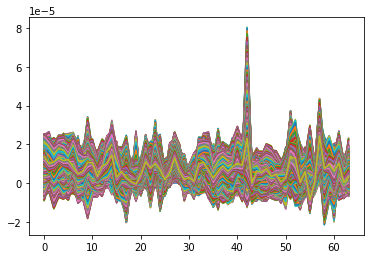

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#data = np.random.randint(3, 7, (10, 1, 1, 80))
newdata = np.squeeze(trials[1]) # Shape is now: (64,6819)
newdata.shape
plt.plot(newdata) # plotting by columns
plt.show()
